In [78]:
# Import packages
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy import ndimage
import scipy.io as sio
from scipy.signal import butter, sosfilt
import skimage.measure

In [79]:
# Check data
base_dir = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence'
data_file = 'Fig3_ver05_221114_data240.anodic.dF,dFF'
# 'Fig3_ver01_221025_data119.cathodic.dF.dFF'  # 10K
# 'Fig3_ver05_221114_data099.cathodic.dF,dFF' # 100K
# 'Fig3_ver05_221114_data101.anodic.dF,dFF' # 150K
# 'Fig3_ver05_221114_data239.cathodic.dF,dFF' # 50K
# 'Fig3_ver05_221114_data240.anodic.dF,dFF' # 60K
# 'Fig3_ver07_221123_data099data119.ImgSig' # W/o subtraction of darkframe values
# 'Fig3_ver08_221212_data211data213_picture,dF,dFF' # 15K 10K

data_dir = os.path.join(os.path.join(base_dir, 'data'), 'Fig3')
data_path = os.path.join(data_dir, data_file)
fig_dir = os.path.join(os.path.join(base_dir, 'figures'), 'Fig3')

test = sio.loadmat(data_path)
test

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Nov 14 16:29:18 2022',
 '__version__': '1.0',
 '__globals__': [],
 'dF': array([[[888.8, 893.8, 900.8, ..., 905.8, 900.8, 902.8],
         [881.6, 891.6, 896.6, ..., 902.6, 895.6, 895.6],
         [895.4, 885.4, 883.4, ..., 893.4, 895.4, 902.4],
         ...,
         [932.8, 937.8, 924.8, ..., 939.8, 931.8, 923.8],
         [898.2, 901.2, 912.2, ..., 903.2, 901.2, 892.2],
         [922.2, 905.2, 916.2, ..., 924.2, 925.2, 924.2]],
 
        [[906.2, 876.2, 895.2, ..., 894.2, 881.2, 886.2],
         [883.8, 882.8, 887.8, ..., 878.8, 891.8, 874.8],
         [879.2, 889.2, 884.2, ..., 883.2, 885.2, 889.2],
         ...,
         [902.2, 910.2, 919.2, ..., 911.2, 912.2, 913.2],
         [907.2, 880.2, 897.2, ..., 894.2, 897.2, 896.2],
         [905.6, 905.6, 906.6, ..., 909.6, 902.6, 896.6]],
 
        [[870.8, 883.8, 894.8, ..., 883.8, 878.8, 878.8],
         [876.6, 898.6, 862.6, ..., 882.6, 885.6, 889.6],
         

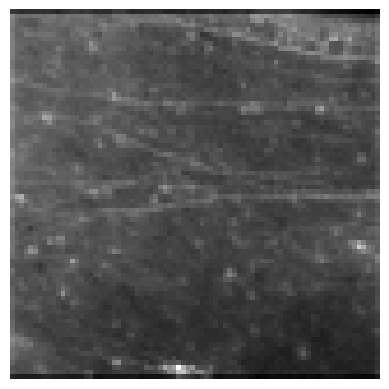

In [80]:
# Check the background image
if data_file == 'Fig3_ver01_221025_data119.cathodic.dF.dFF':
    data_type = 'data119'
    background_path = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\data\\Fig3\\Fig3_ver04_221110_data119.cathodic_picture.txt'
    low_thres, high_thres = 1.5*1e4, 2.5*1e4
elif data_file == 'Fig3_ver05_221114_data099.cathodic.dF,dFF':
    data_type = 'data099'
    background_path = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\data\\Fig3\\Fig3_ver06_221114_data099.cathodic_picture.txt'
    low_thres, high_thres = 4.5*1e6, 6.25*1e6
elif data_file == 'Fig3_ver05_221114_data101.anodic.dF,dFF':
    data_type = 'data101'
    background_path = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\data\\Fig3\\Fig3_ver06_221114_data101.anodic_picture.txt'
    low_thres, high_thres = 4.5*1e6, 6.25*1e6
elif data_file == 'Fig3_ver05_221114_data239.cathodic.dF,dFF':
    data_type = 'data239'
    background_path = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\data\\Fig3\\Fig3_ver06_221114_data239.cathodic_picture.txt'
    low_thres, high_thres = 4.5*1e6, 6.25*1e6
elif data_file == 'Fig3_ver05_221114_data240.anodic.dF,dFF':
    data_type = 'data240'
    background_path = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\data\\Fig3\\Fig3_ver06_221114_data240.anodic_picture.txt'
    low_thres, high_thres = 4.5*1e6, 6.25*1e6
elif data_file == 'Fig3_ver07_221123_data099data119.ImgSig':
    data_type = 'data099' # 'data119'
    background_path = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\data\\Fig3\\Fig3_ver06_221114_data099.cathodic_picture.txt'
    # background_path = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\data\\Fig3\\Fig3_ver04_221110_data119.cathodic_picture.txt'
    low_thres, high_thres = 4.5*1e6, 6.25*1e6
elif data_file == 'Fig3_ver08_221212_data211data213_picture,dF,dFF':
    data_type = 'data211' #  'data211' or 'data213
    background_path = test['data211_cathodic_picture'] # test['data211_cathodic_picture'] or test['data213_anodic_picture']
    low_thres, high_thres = 4.5*1e6, 6.25*1e6

if data_file == 'Fig3_ver01_221025_data119.cathodic.dF.dFF':
    kernel_dim = 3
else:
    kernel_dim = 6

os.makedirs(os.path.join(fig_dir, f'Frames_{data_type}'), exist_ok=True)
os.makedirs(os.path.join(fig_dir, f'Results_{data_type}'), exist_ok=True)

if data_file != 'Fig3_ver08_221212_data211data213_picture,dF,dFF':
    img_data = []
    with open(background_path) as file:
        for (i, line) in enumerate(file):
            row_data = np.expand_dims(np.array(line.split(',')[:-1]).astype('float64'), axis=0)
            if i == 0:
                img_data = row_data
            else:
                img_data = np.concatenate([img_data, row_data], axis=0)
else:
    img_data = background_path

plt.imshow(img_data, cmap='gray')
plt.axis('off')
plt.show()

In [81]:
# Check keys
test.keys()

dict_keys(['__header__', '__version__', '__globals__', 'dF', 'dFF'])

In [82]:
# Print out shapes, min and max values
if data_file == 'Fig3_ver01_221025_data119.cathodic.dF.dFF':
    dF_var = 'data119_cathodic_dF'
    dFF_var = 'data119_cathodic_dFF'
elif data_file == 'Fig3_ver07_221123_data099data119.ImgSig':
    dF_var = 'data099_ImagSig'
    dFF_var = 'data119_ImgSig'
elif data_file == 'Fig3_ver08_221212_data211data213_picture,dF,dFF':
    dF_var = 'data211_cathodic_dF' #'data211_cathodic_dF' # 'data213_anodic_dF'
    dFF_var = 'data211_cathodic_dFF' #'data211_cathodic_dFF' # 'data213_anodic_dFF'
else:
    dF_var = 'dF'
    dFF_var = 'dFF'

print(test[dF_var].shape)
print(test[dF_var].min())
print(test[dF_var].max())

print(test[dFF_var].shape)
print(test[dFF_var].min())
print(test[dFF_var].max())

# The F0 value will be somewhere between these two below values.
print(test[dF_var].max() / test[dFF_var].min())
print(test[dF_var].min() / test[dFF_var].max())

(80, 80, 5000)
829.0
958.0
(80, 80, 5000)
1.940513744930149
19.163934426229527
493.68369716674397
43.25834046193323


In [83]:
# Temporal processing

## Low-pass filtering (10 hz)
if data_file == 'Fig3_ver01_221025_data119.cathodic.dF.dFF':
    lowcut = 10.
    fs = 1000.
    sos = butter(5, [lowcut], 'low', fs=fs, output='sos')
    data = test[dFF_var][:, :, 100:4900]
    temp_data = sosfilt(sos, data)
else:
    temp_data = test[dFF_var][:, :, 100:4900]
print(temp_data.shape)
print(temp_data.min())
print(temp_data.max())

(80, 80, 4800)
1.940513744930149
19.163934426229527


In [84]:
# Spatial processing

## Movie scaling
space_data1_temp = np.swapaxes(temp_data, 0, -1)
space_data1 = (space_data1_temp - space_data1_temp.min(axis=0)) / (space_data1_temp.max(axis=0) - space_data1_temp.min(axis=0))
space_data1 *= 255

## Low-pass filtering (kernel x kernel mean)
iter_num = 3
kernel = np.ones((kernel_dim, kernel_dim)) 
space_data2 = np.zeros(space_data1.shape)
for frame_num in range(space_data2.shape[0]):
    space_data2[frame_num, :, :] = ndimage.convolve(space_data1[frame_num, :, :], kernel)
    for i in range(iter_num - 1):
        space_data2[frame_num, :, :] = ndimage.convolve(space_data2[frame_num, :, :], kernel)

## Coloring
space_data3 = np.zeros(space_data2.shape)
if data_file == 'Fig3_ver01_221025_data119.cathodic.dF.dFF':
    level_num = 5.
    for frame_num in range(space_data3.shape[0]):
        if np.unique(space_data2[frame_num, :, :]).shape[0] == 1:
            space_data3[frame_num, :, :] = np.zeros(space_data2[frame_num, :, :].shape)
        else:
            min = space_data2[frame_num, :, :].min()
            max = space_data2[frame_num, :, :].max()
            one_interval = (max - min) / level_num

            space_data3[frame_num, :, :] = (space_data2[frame_num, :, :] - min) / one_interval
            space_data3[frame_num, :, :] = np.floor(space_data3[frame_num, :, :])
            space_data3[frame_num, :, :][space_data3[frame_num, :, :] >= level_num] = level_num - 1
            space_data3[frame_num, :, :] *= one_interval
            space_data3[frame_num, :, :] += (one_interval / 2)
else:
    for x_coord in tqdm(range(space_data2.shape[1])):
        for y_coord in range(space_data2.shape[-1]):
            space_data3[:, x_coord, y_coord] = space_data2[:, x_coord, y_coord] - np.flip(np.repeat(np.exp(range(10, 15)), space_data2.shape[0] / 5))

print(space_data1.shape)
print(space_data1.min())
print(space_data1.max())
print(space_data2.shape)
print(space_data2.min())
print(space_data2.max())
print(space_data3.shape)
print(space_data3.min())
print(space_data3.max())

100%|██████████| 80/80 [00:03<00:00, 25.49it/s]


(4800, 80, 80)
0.0
255.0
(4800, 80, 80)
3165864.183223157
7667322.01418644
(4800, 80, 80)
2723450.7912142365
7504567.222767436


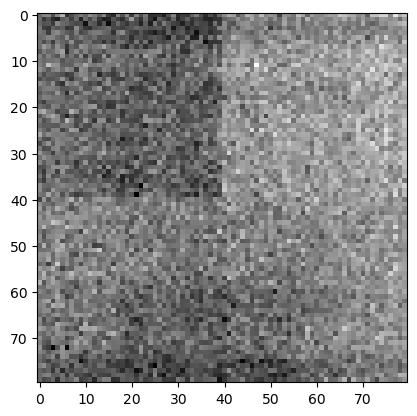

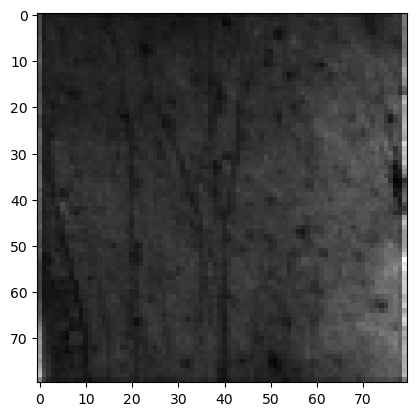

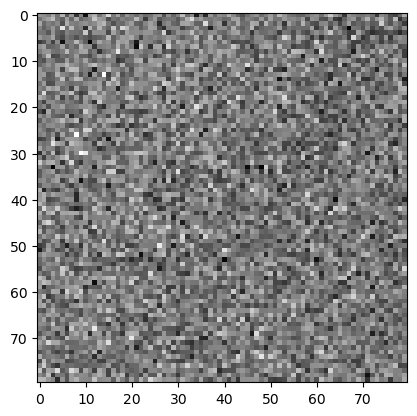

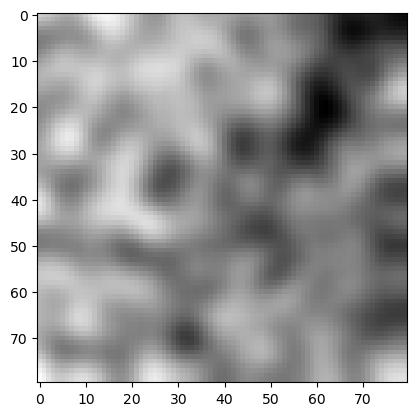

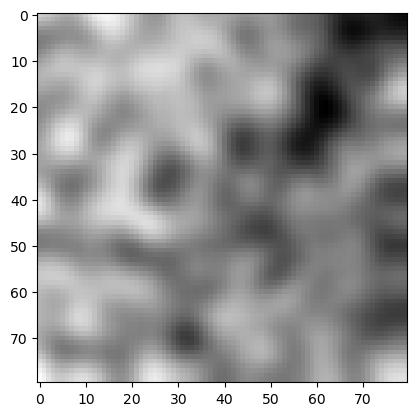

In [85]:
# Visualize one frame for full processing steps
frame_num = 1500 # 1447 or frame_num

plt.imshow(test[dF_var][:, :, frame_num], cmap='gray')
plt.show()

plt.imshow(temp_data[:, :, frame_num], cmap='gray')
plt.show()

plt.imshow(space_data1[frame_num, :, :], cmap='gray')
plt.show()

plt.imshow(space_data2[frame_num, :, :], cmap='gray')
plt.show()

plt.imshow(space_data3[frame_num, :, :], cmap='gray')
plt.show()

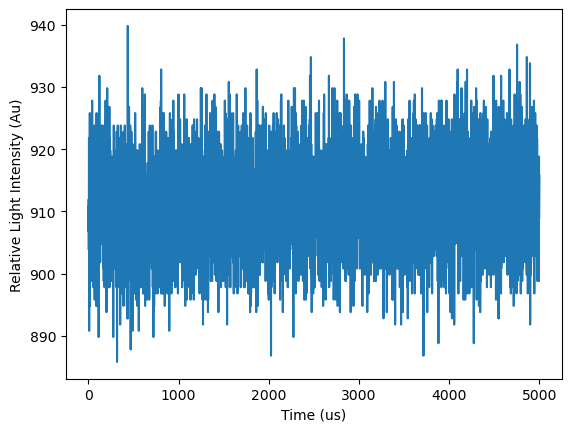

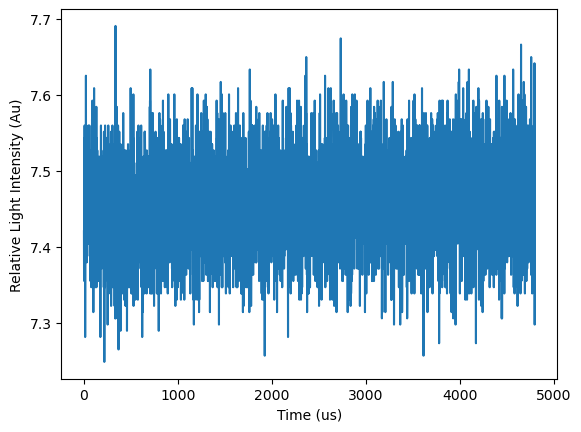

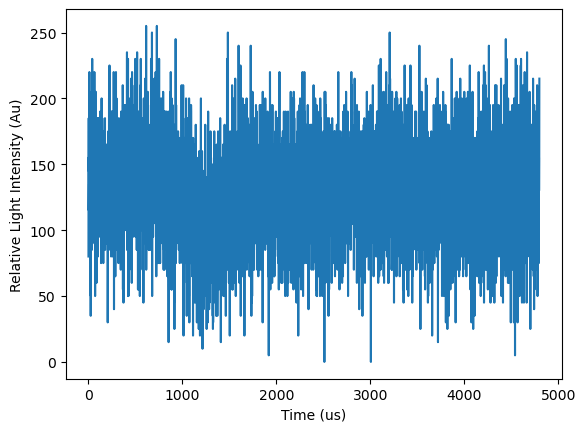

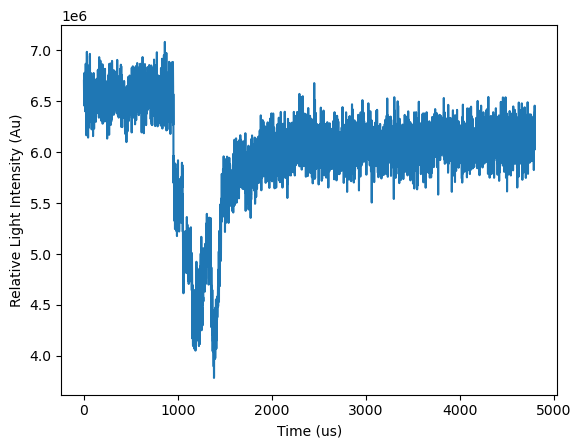

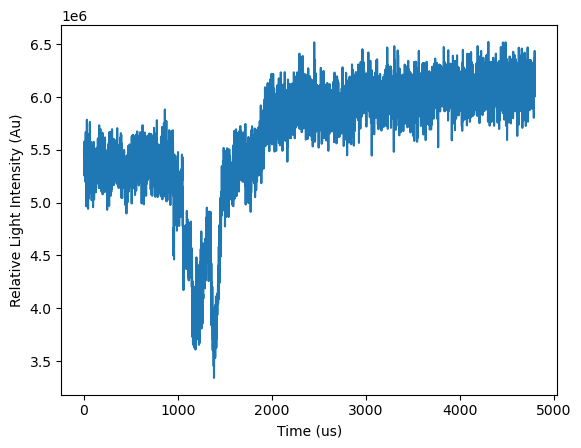

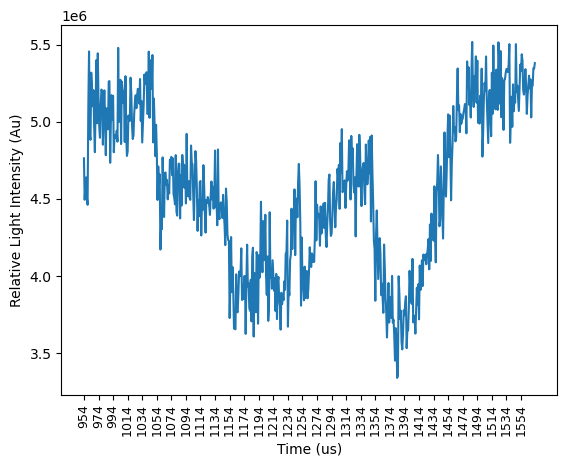

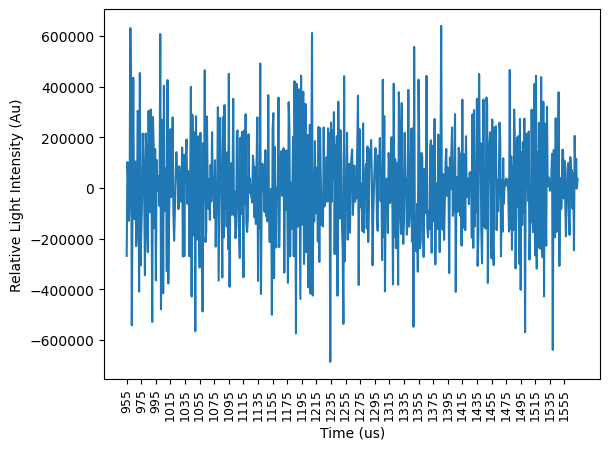

In [86]:
x_coord, y_coord = 30, 70 # 65, 45 # 10, 10 # 

plt.plot(range(test[dF_var].shape[-1]), test[dF_var][x_coord, y_coord, :])
plt.xlabel('Time (us)')
plt.ylabel('Relative Light Intensity (Au)')
plt.show()

plt.plot(range(temp_data.shape[-1]), temp_data[x_coord, y_coord, :])
plt.xlabel('Time (us)')
plt.ylabel('Relative Light Intensity (Au)')
plt.show()

plt.plot(range(space_data1.shape[0]), space_data1[:, x_coord, y_coord])
plt.xlabel('Time (us)')
plt.ylabel('Relative Light Intensity (Au)')
plt.show()

plt.plot(range(space_data2.shape[0]), space_data2[:, x_coord, y_coord])
plt.xlabel('Time (us)')
plt.ylabel('Relative Light Intensity (Au)')
plt.show()

plt.plot(range(space_data3.shape[0]), space_data3[:, x_coord, y_coord])
plt.xlabel('Time (us)')
plt.ylabel('Relative Light Intensity (Au)')
plt.show()

# Partial plots
plt.plot(range(954, 1574), space_data3[954:1574, x_coord, y_coord])
plt.xticks(range(954, 1574, 20), fontsize=9, rotation=90)
plt.xlabel('Time (us)')
plt.ylabel('Relative Light Intensity (Au)')
plt.show()

plt.plot(range(955, 1574), np.diff(space_data3[954:1574, x_coord, y_coord]))
plt.xticks(range(955, 1574, 20), fontsize=9, rotation=90)
plt.xlabel('Time (us)')
plt.ylabel('Relative Light Intensity (Au)')
plt.show()

- Save processed images

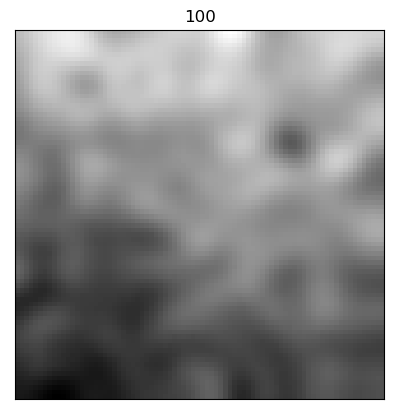

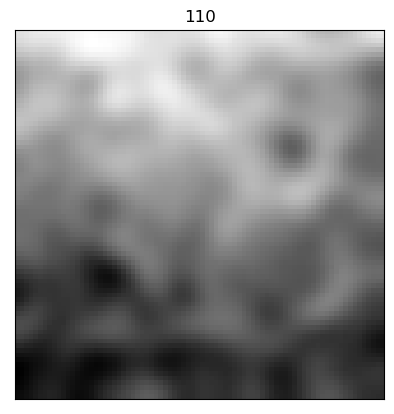

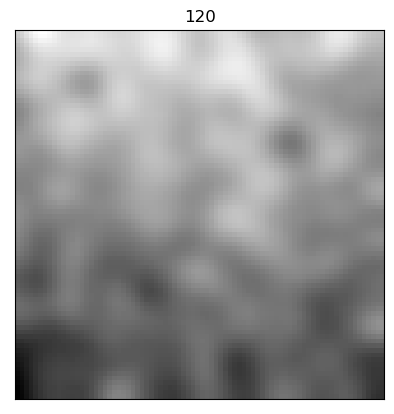

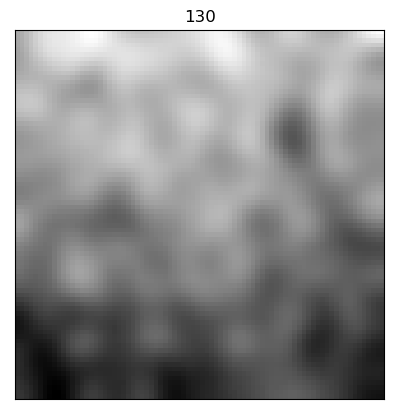

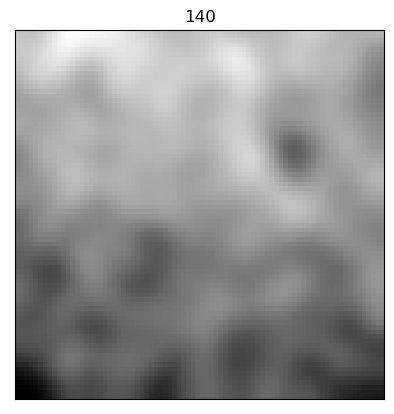

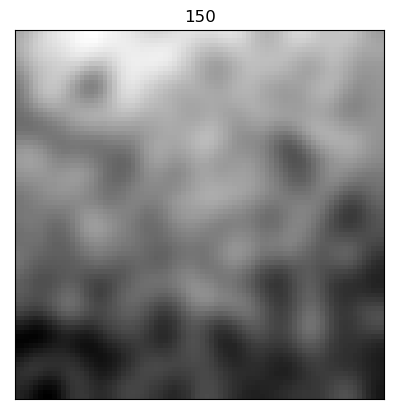

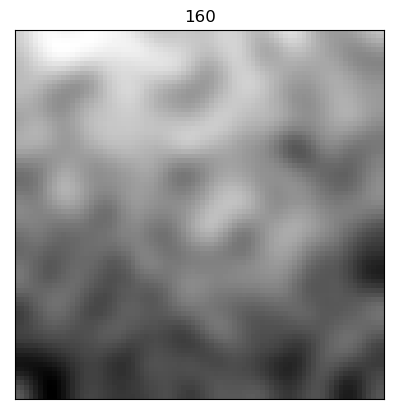

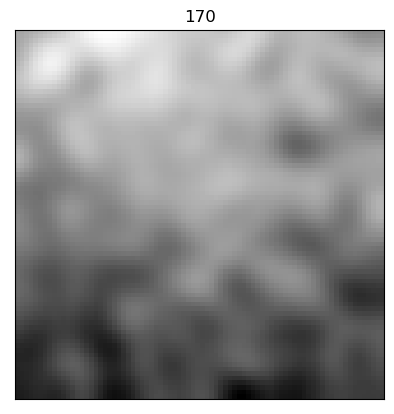

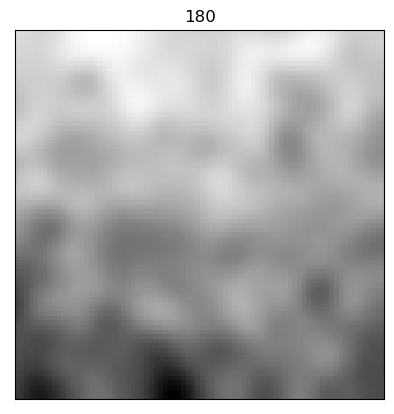

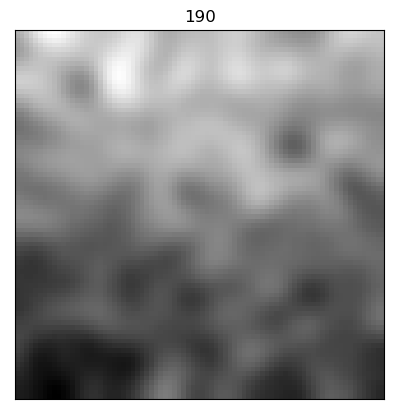

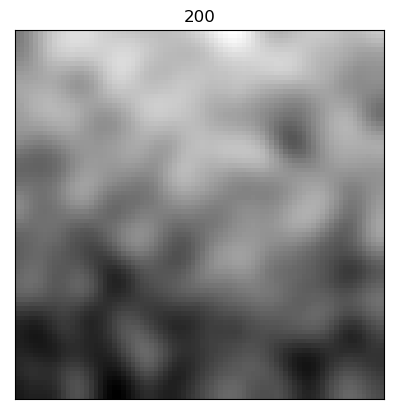

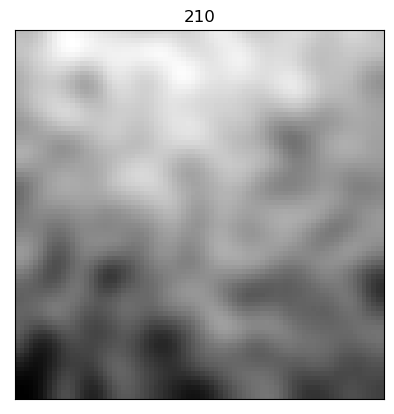

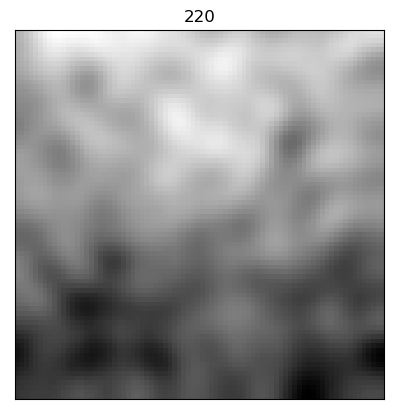

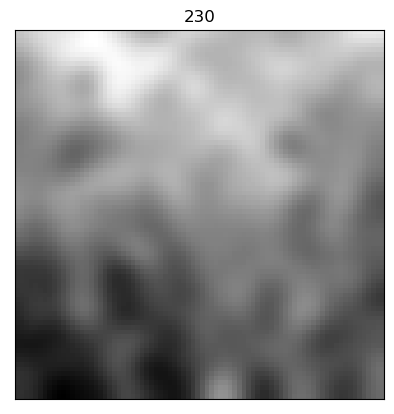

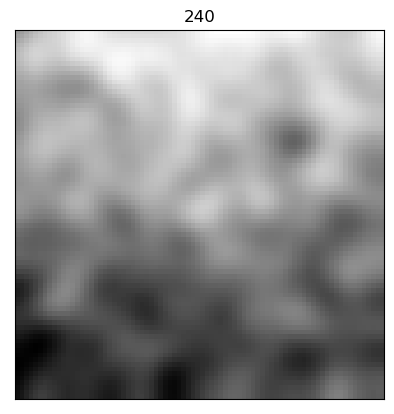

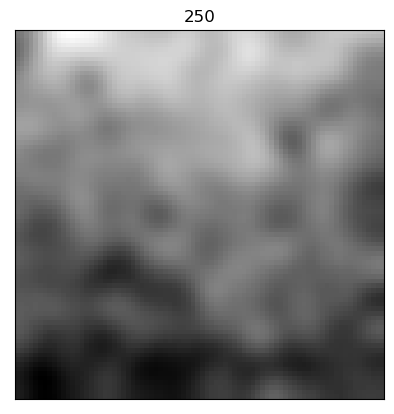

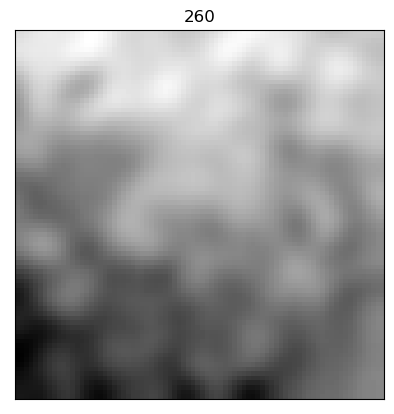

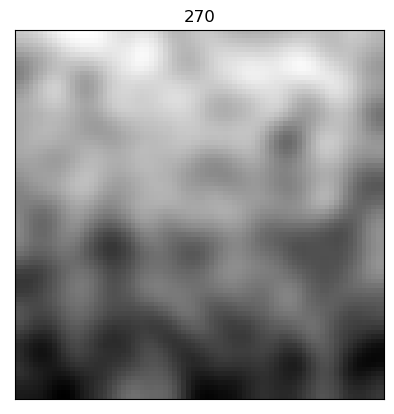

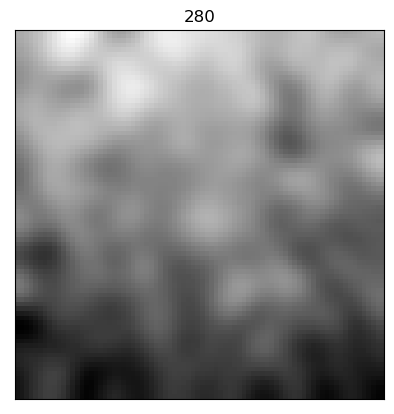

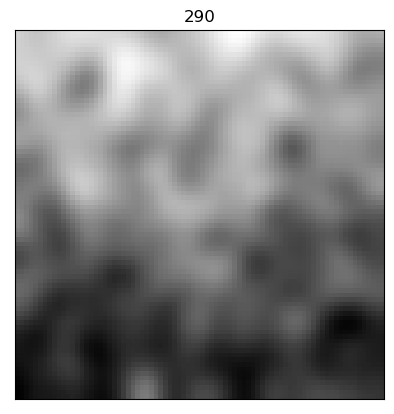

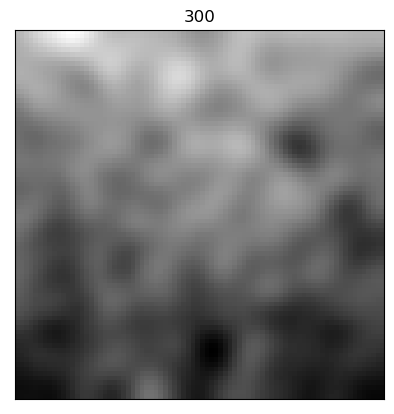

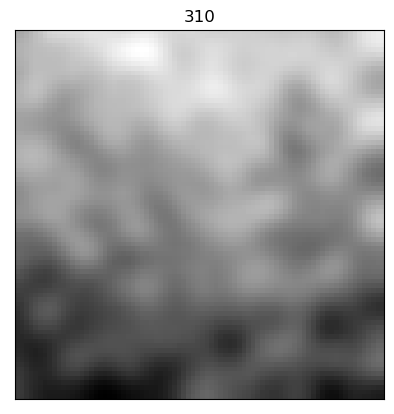

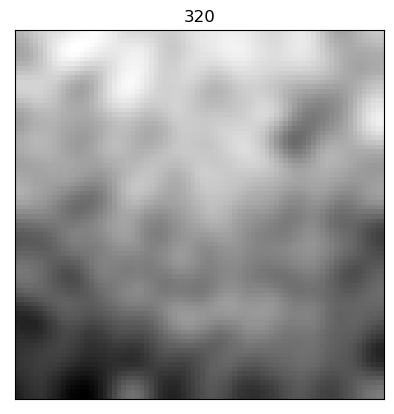

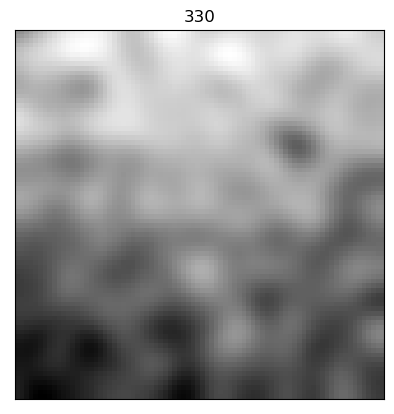

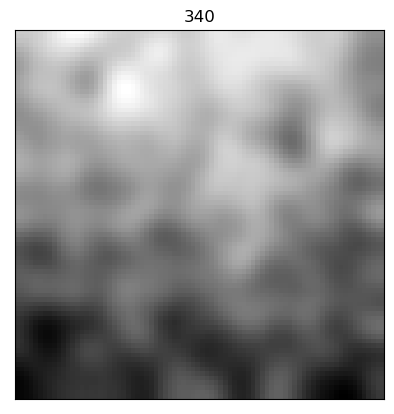

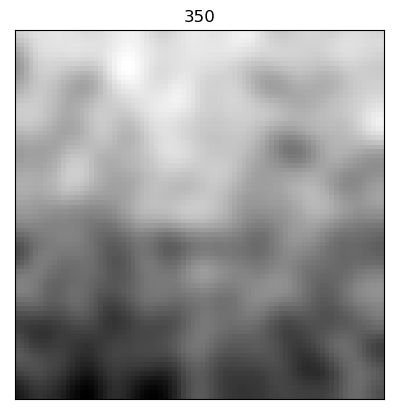

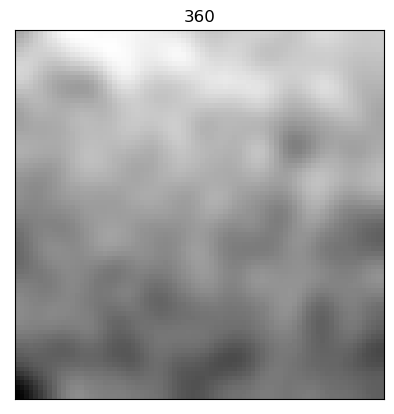

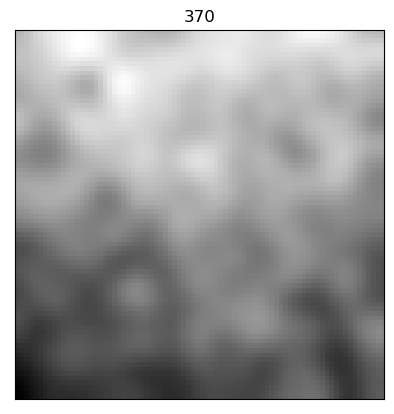

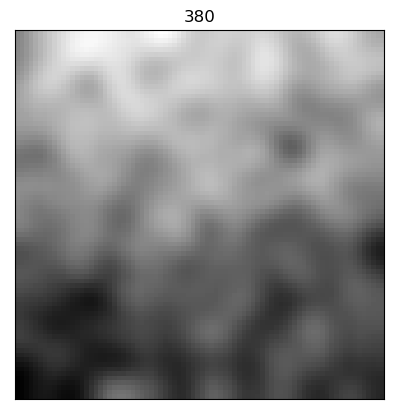

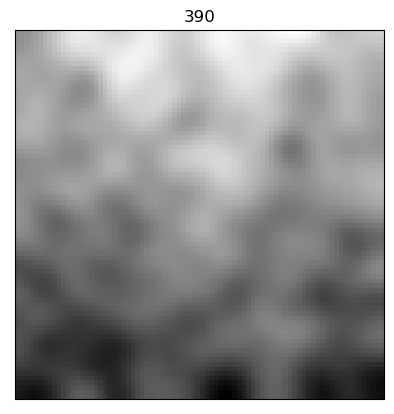

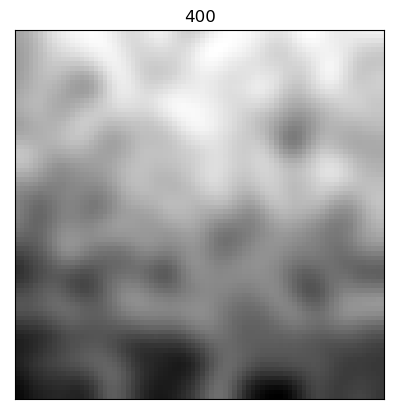

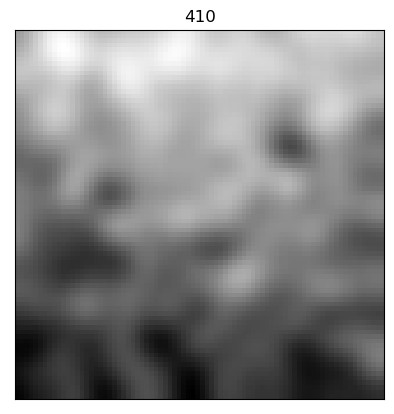

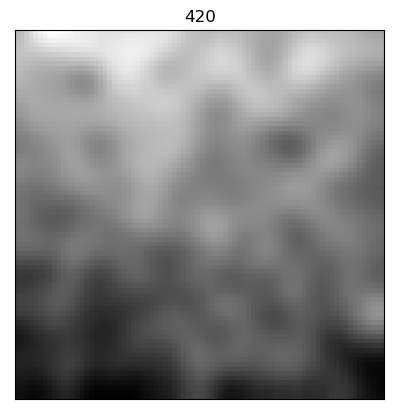

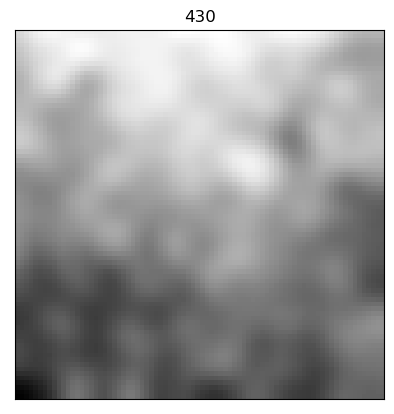

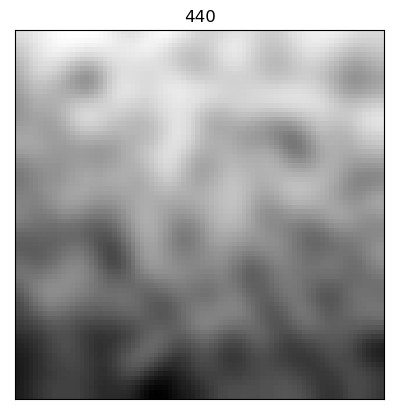

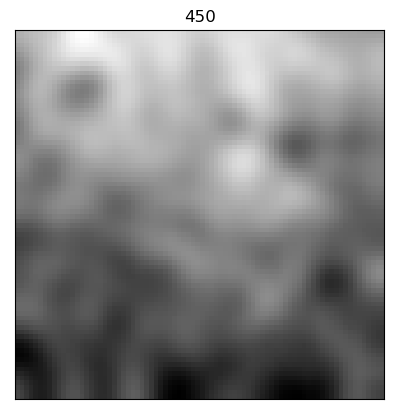

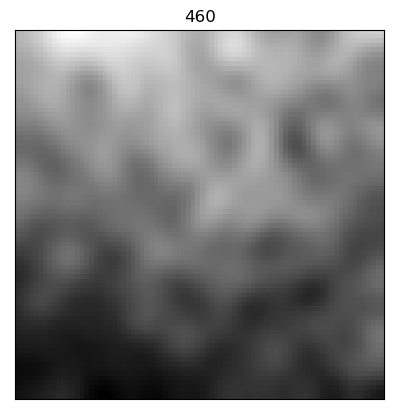

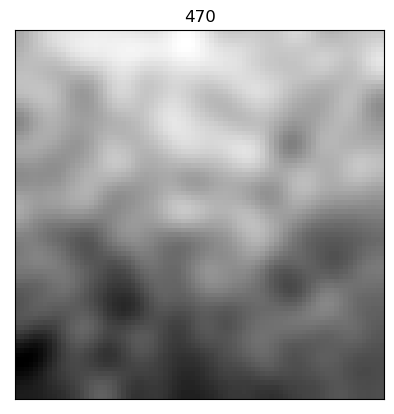

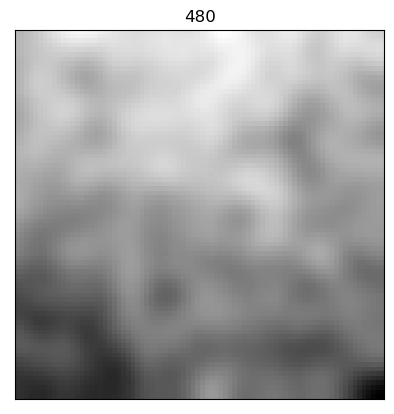

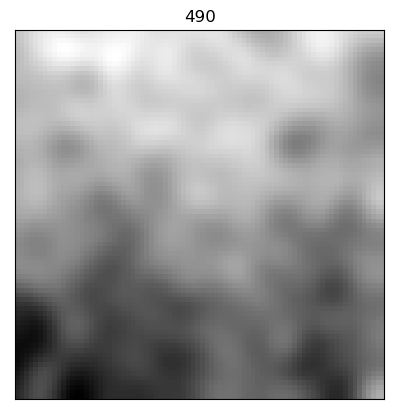

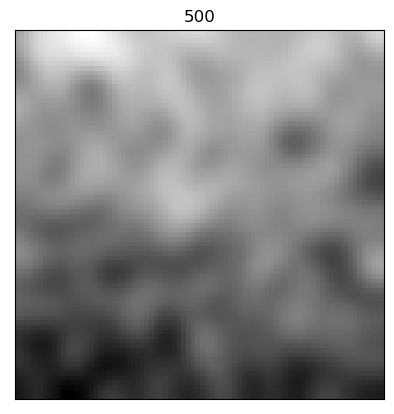

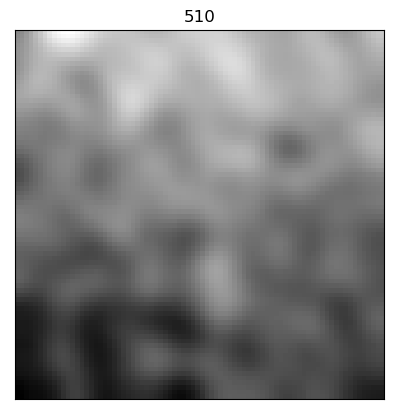

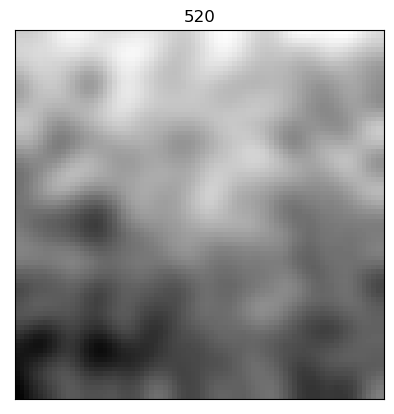

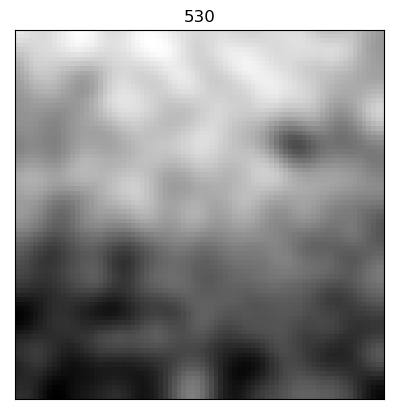

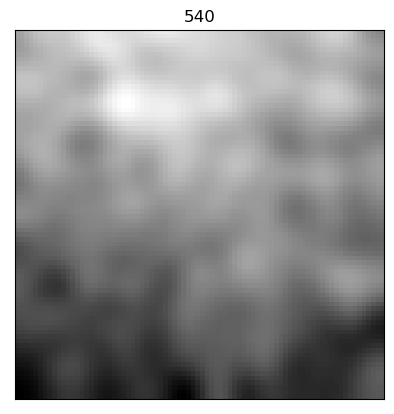

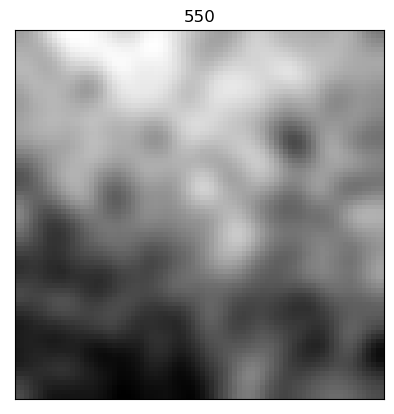

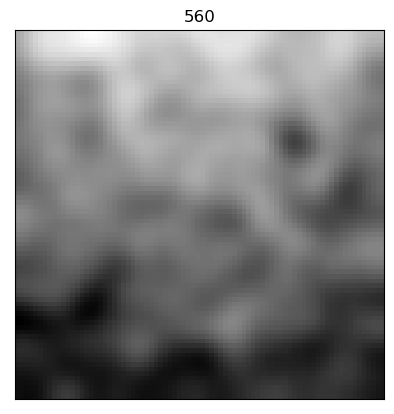

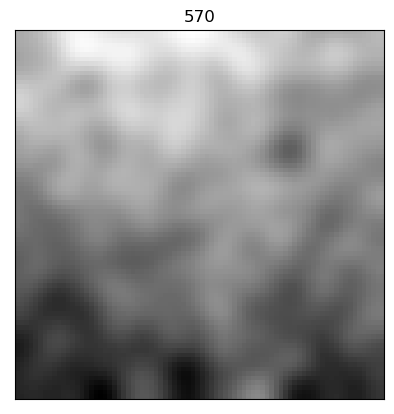

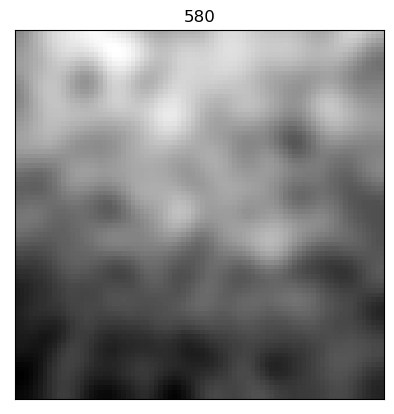

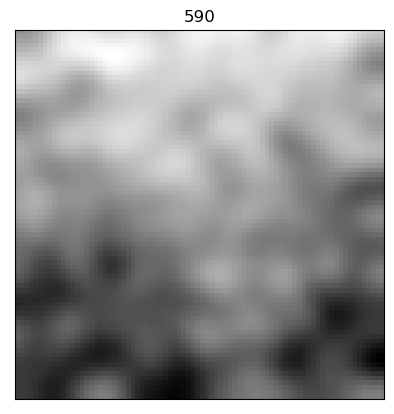

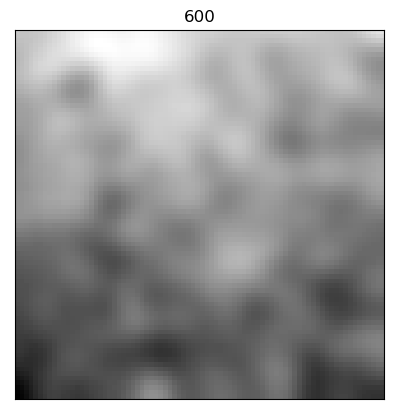

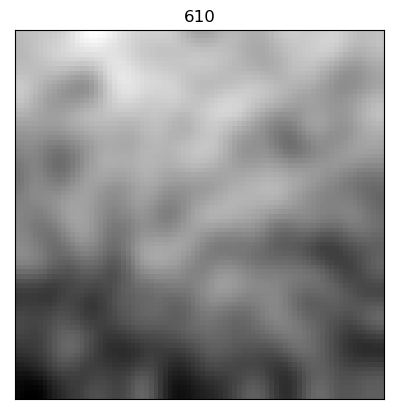

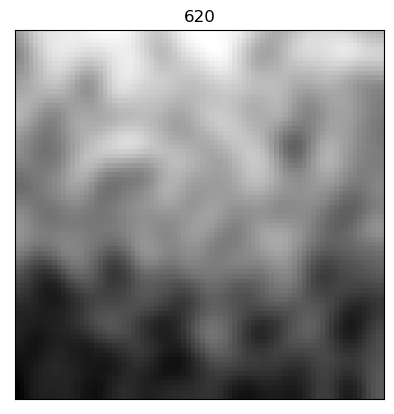

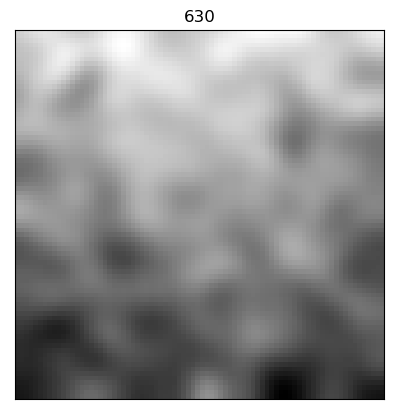

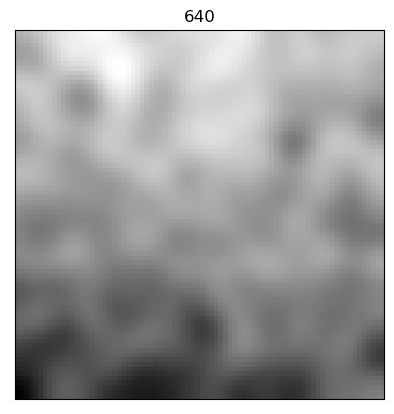

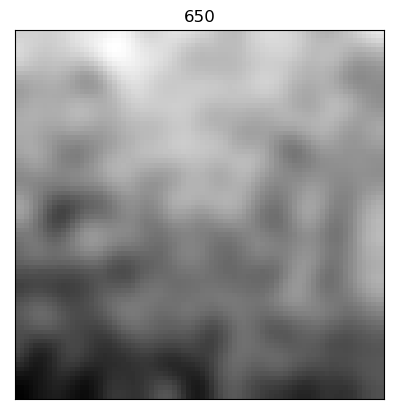

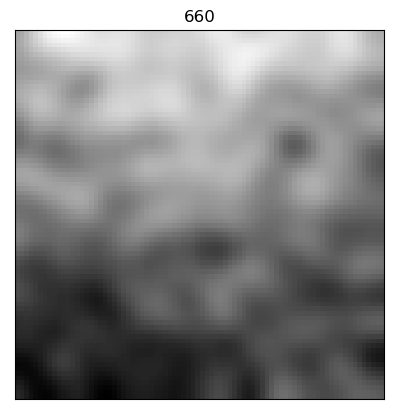

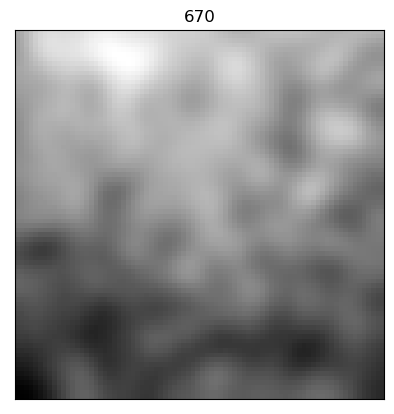

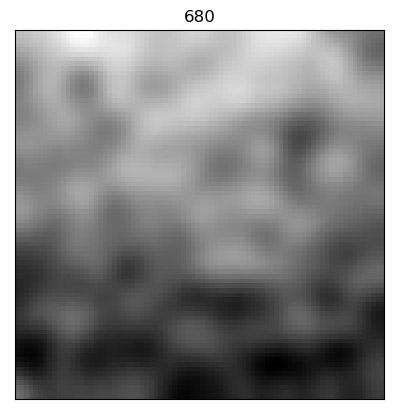

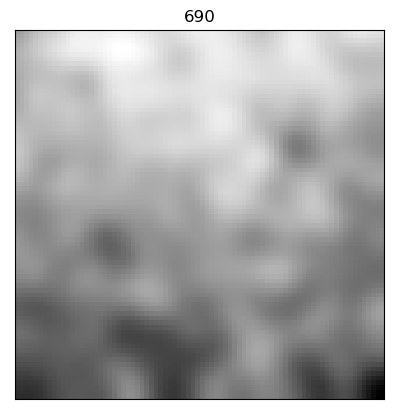

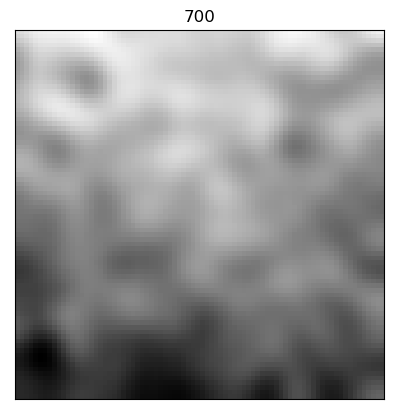

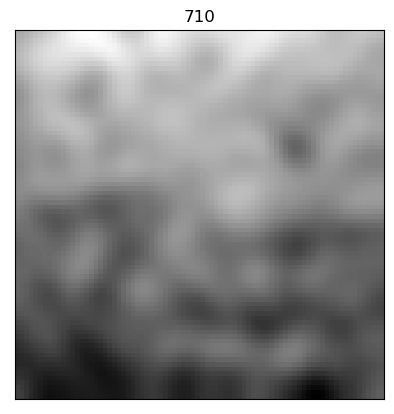

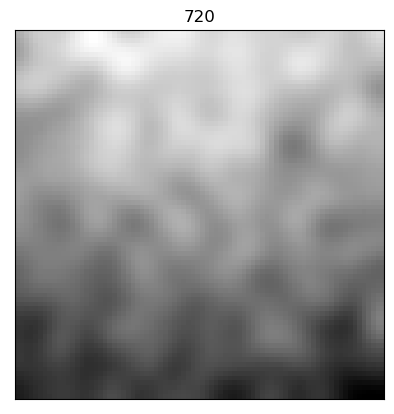

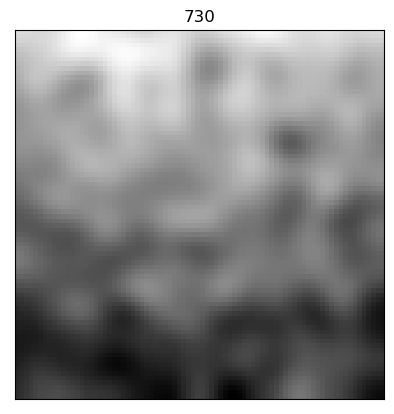

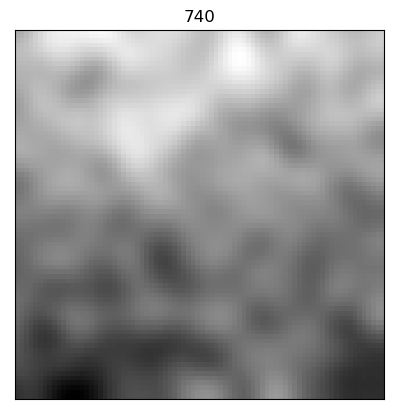

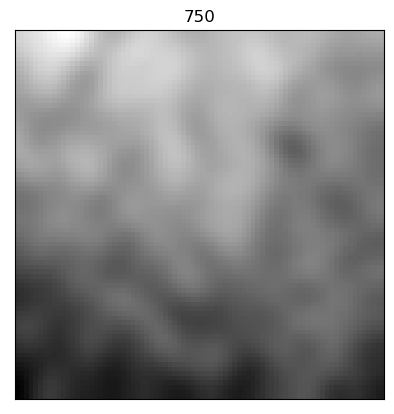

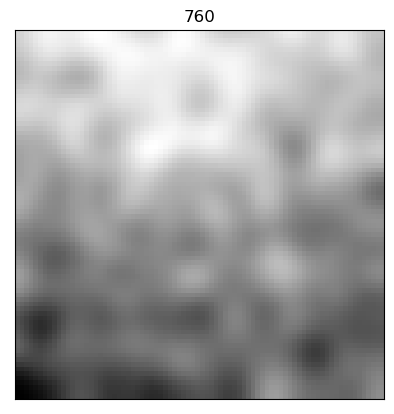

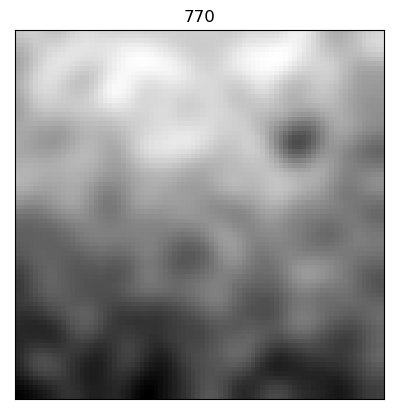

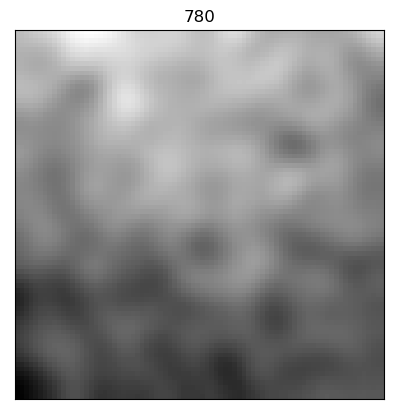

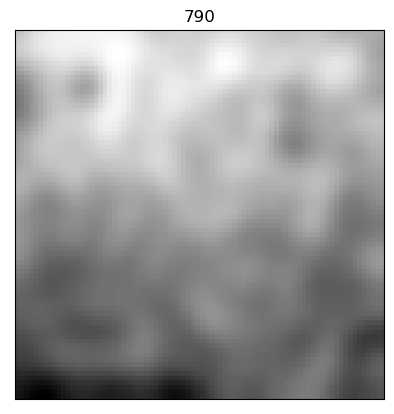

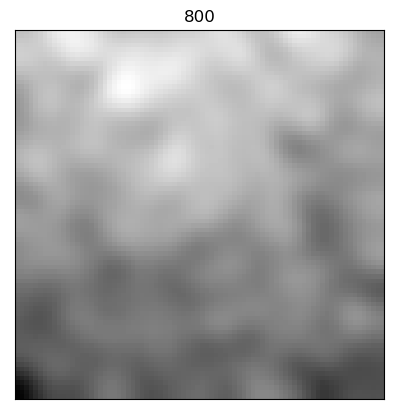

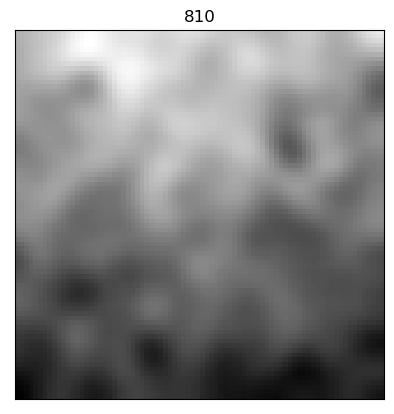

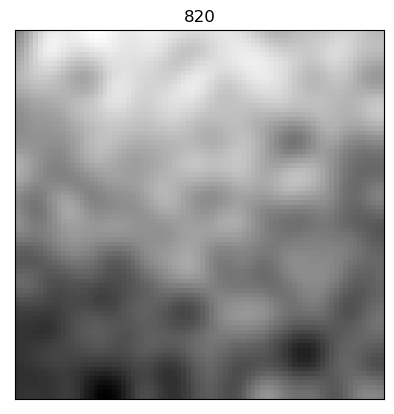

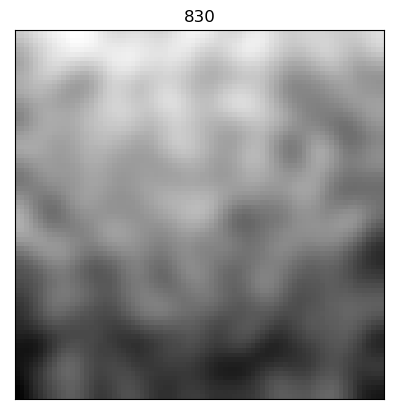

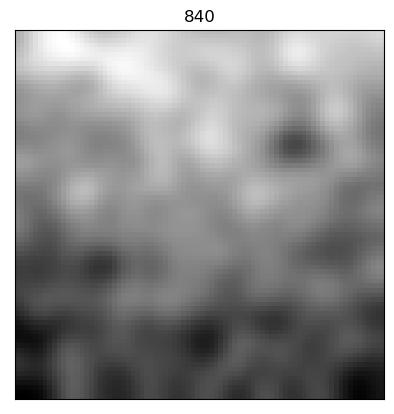

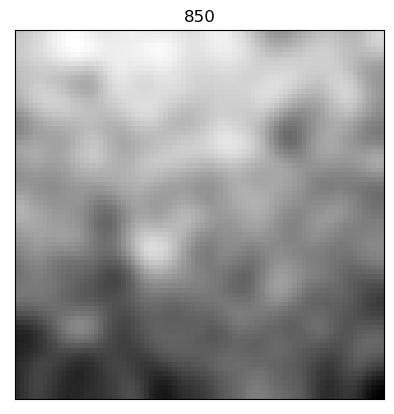

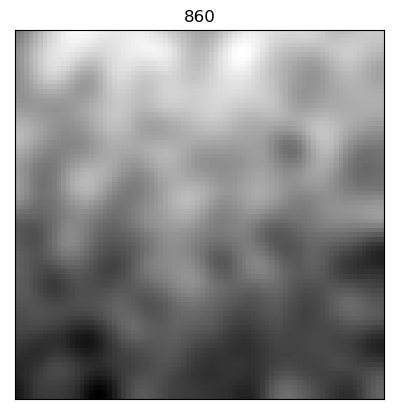

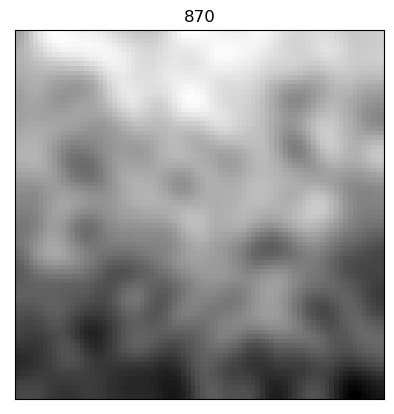

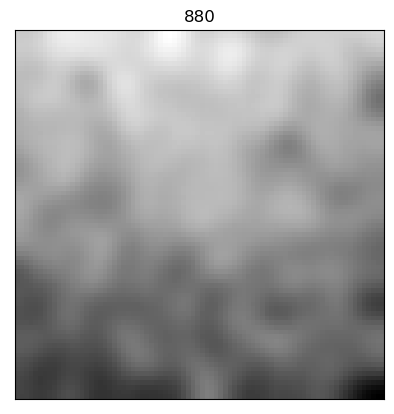

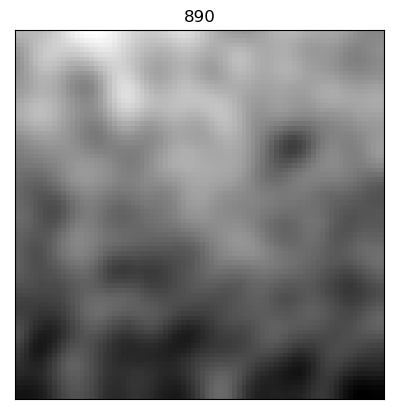

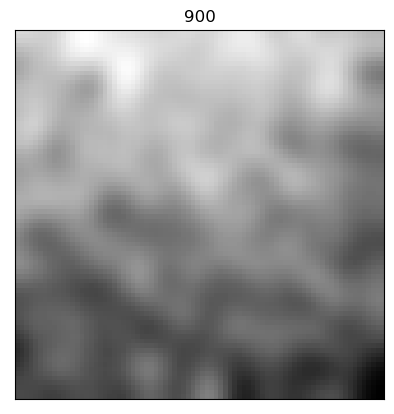

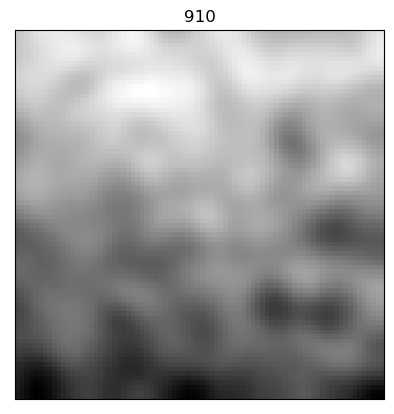

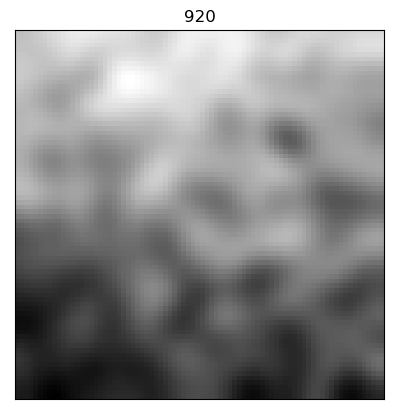

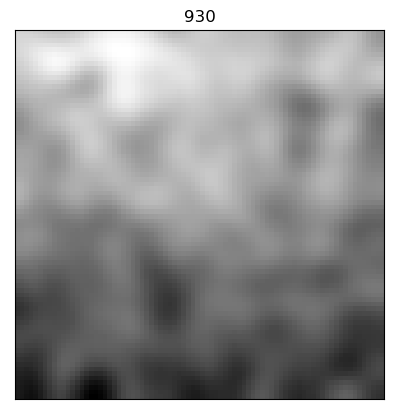

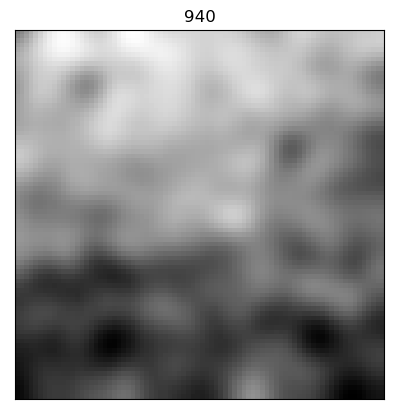

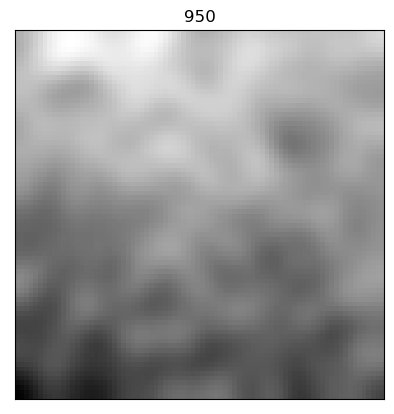

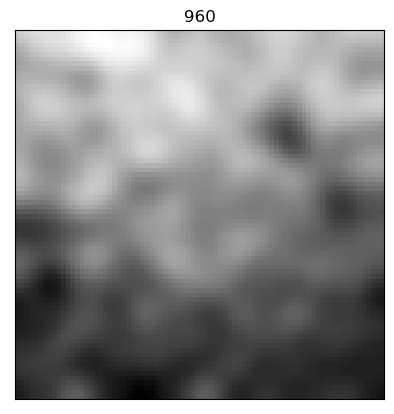

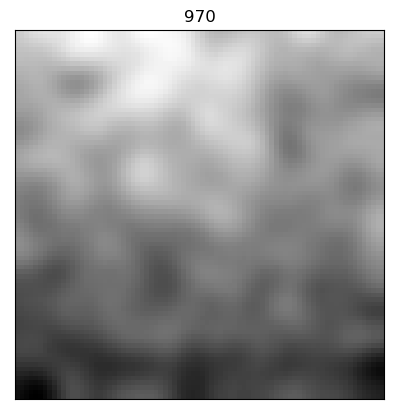

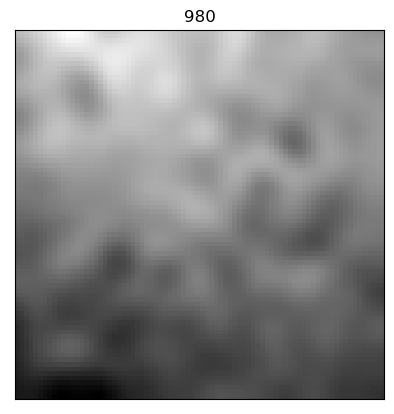

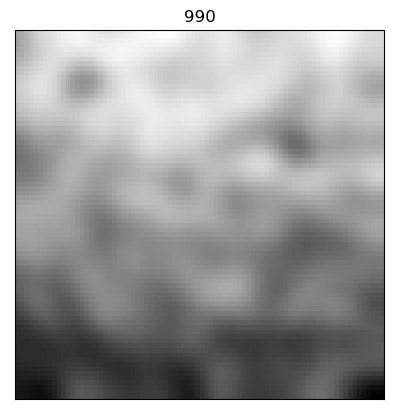

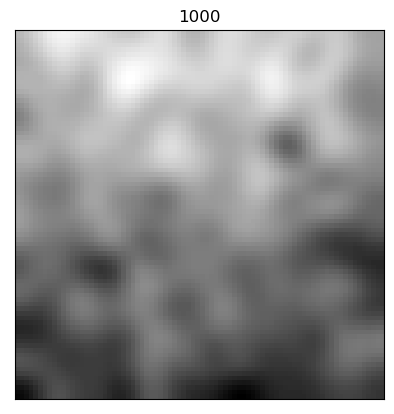

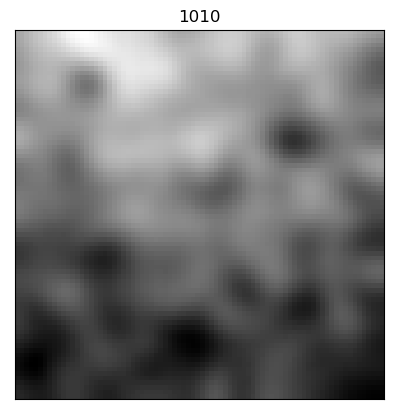

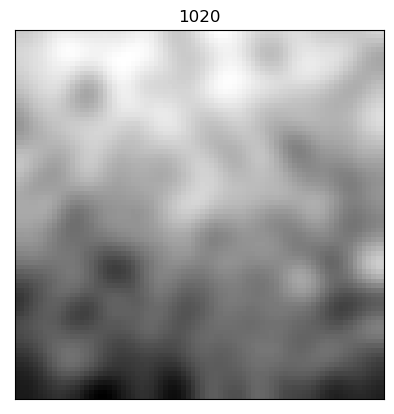

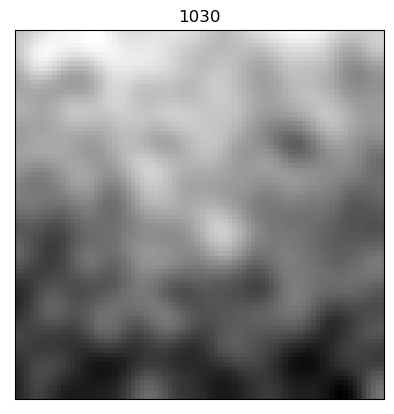

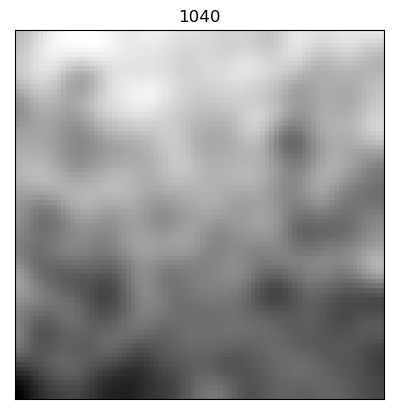

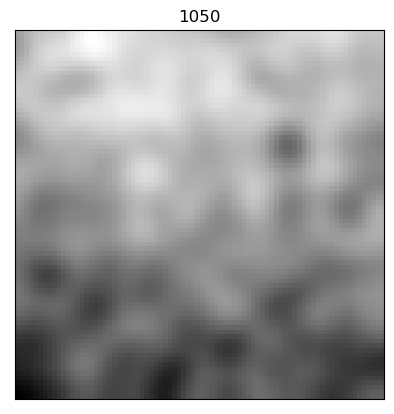

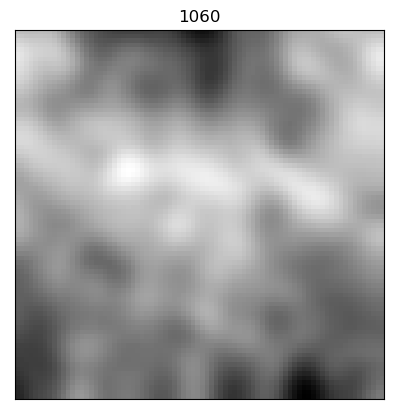

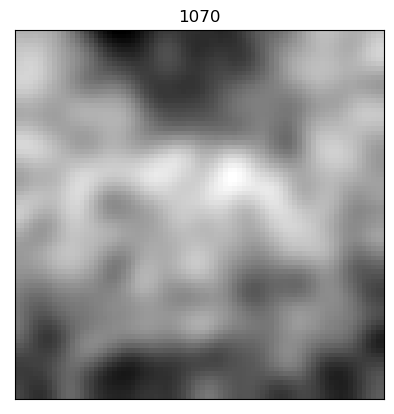

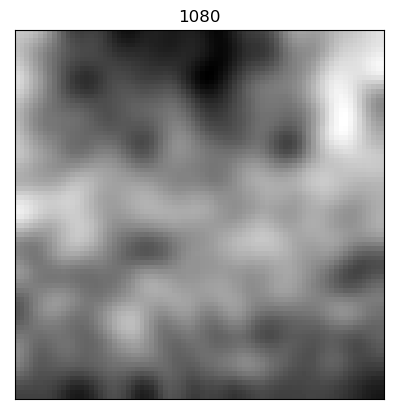

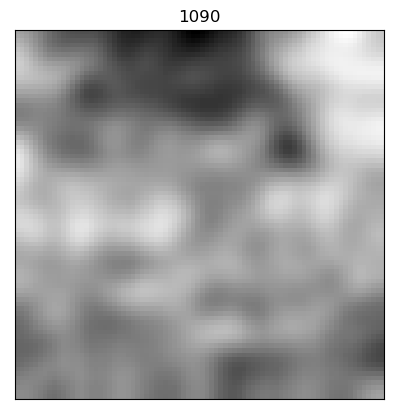

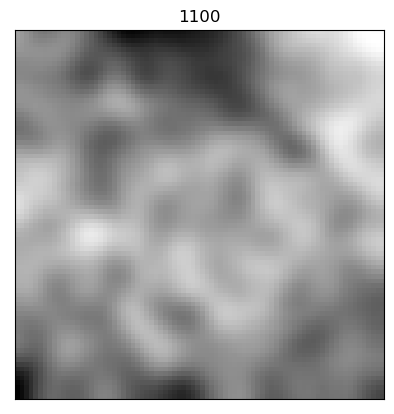

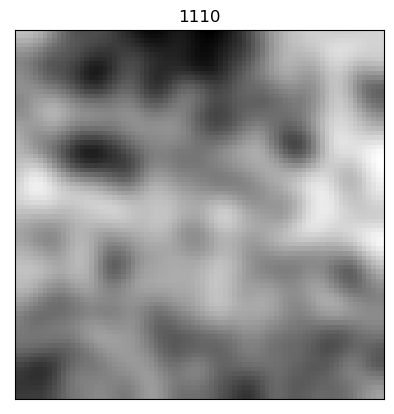

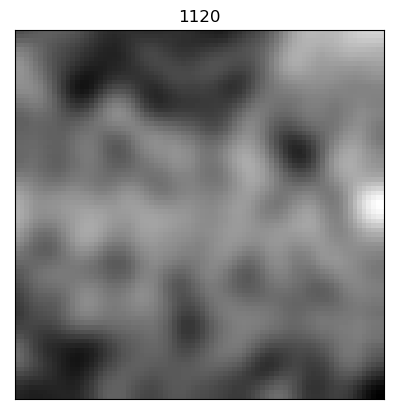

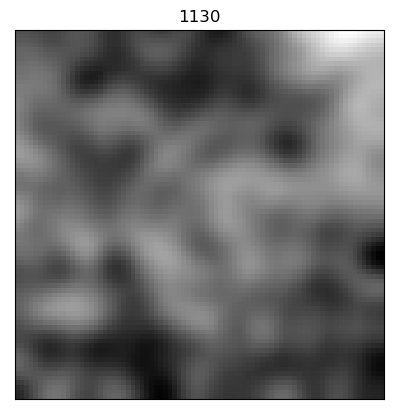

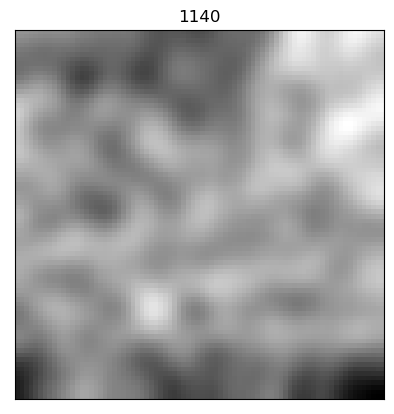

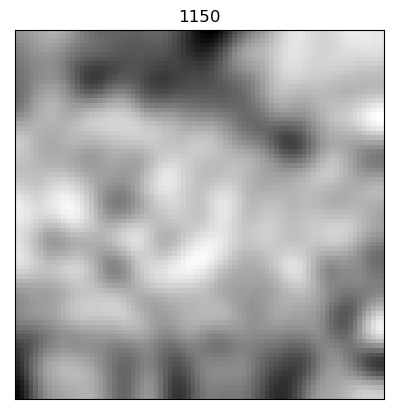

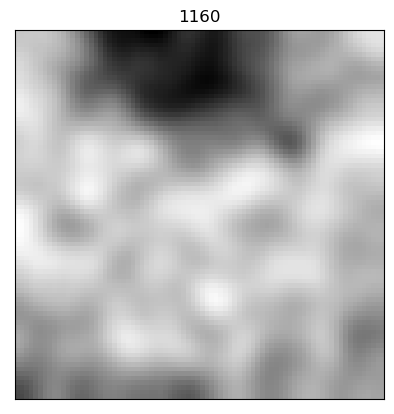

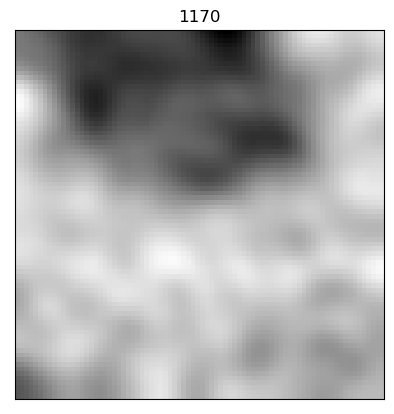

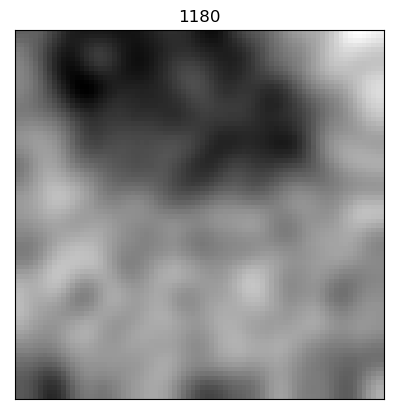

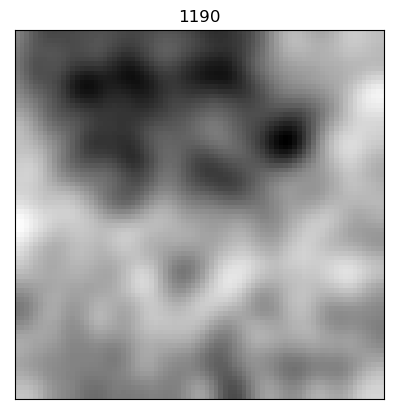

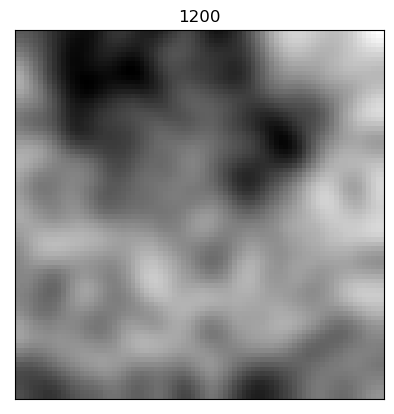

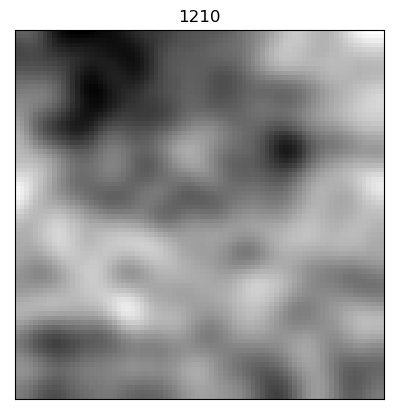

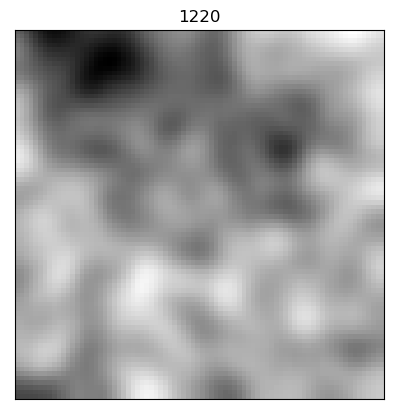

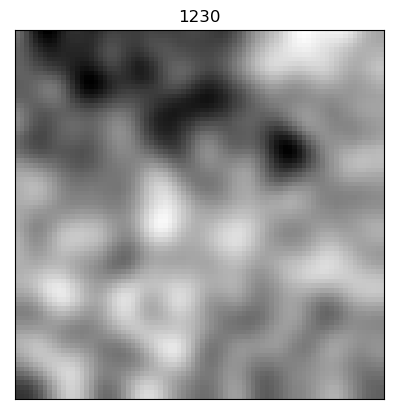

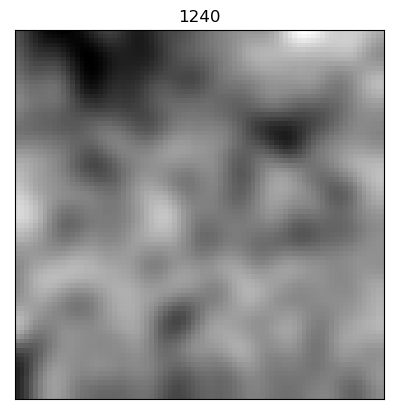

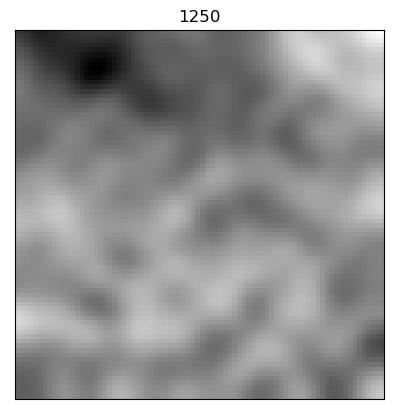

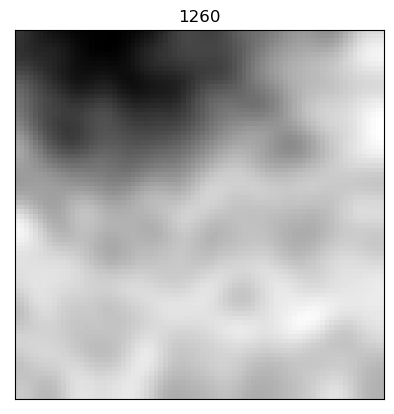

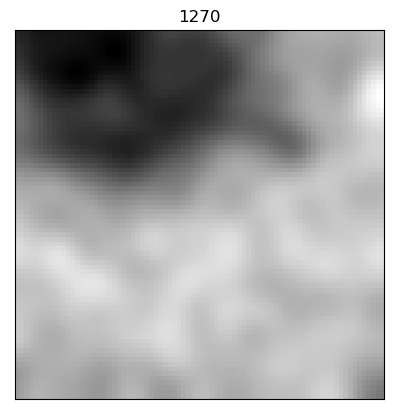

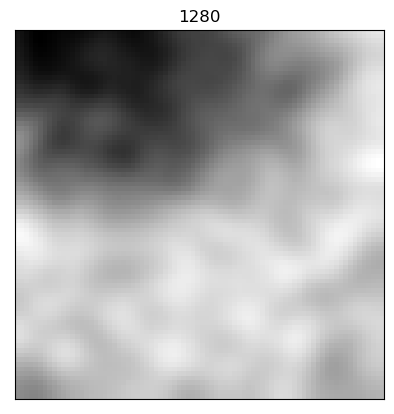

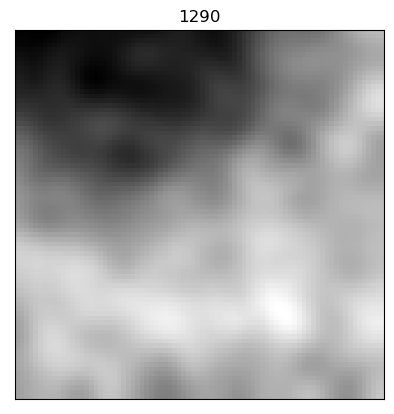

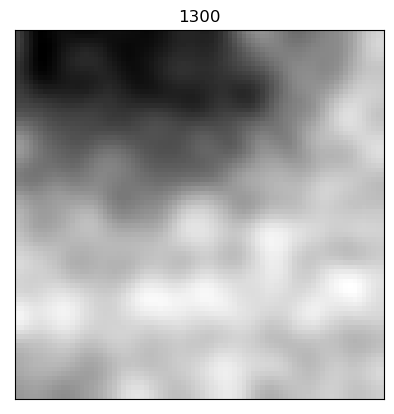

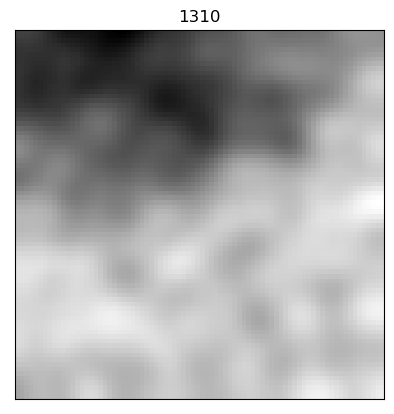

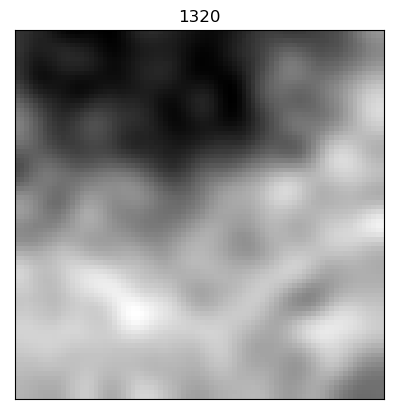

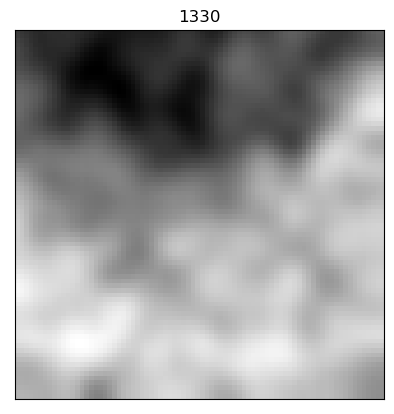

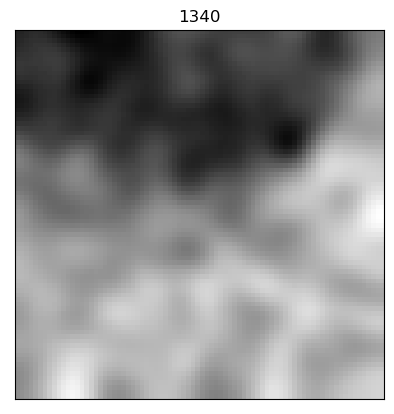

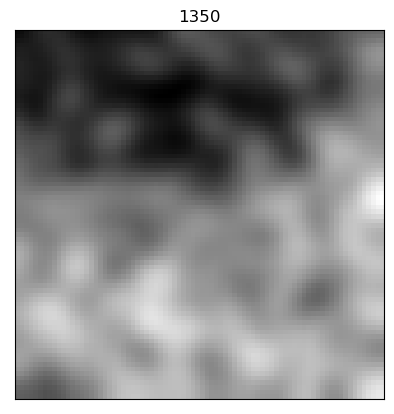

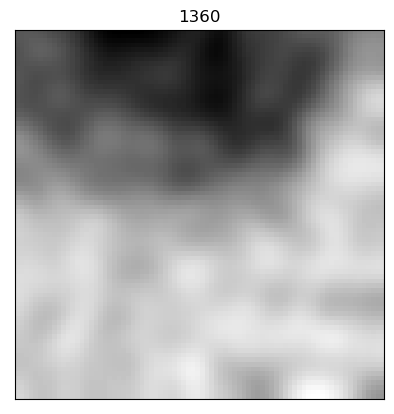

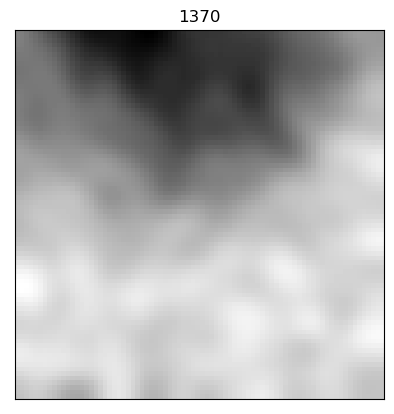

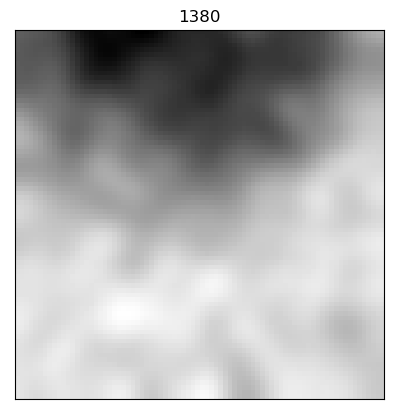

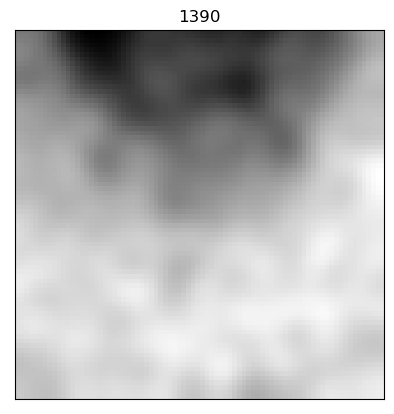

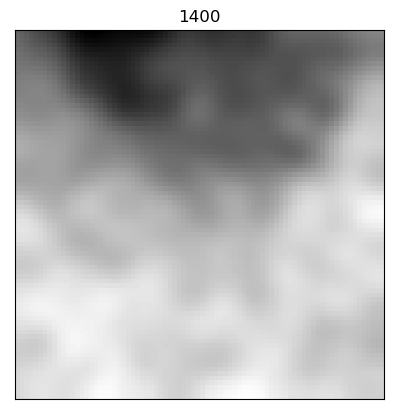

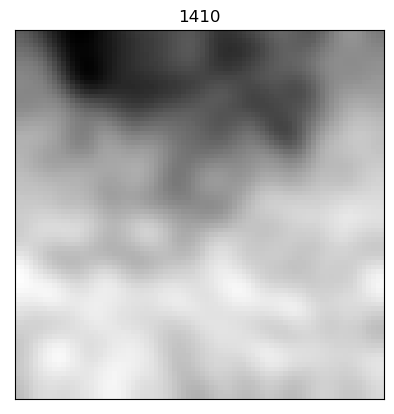

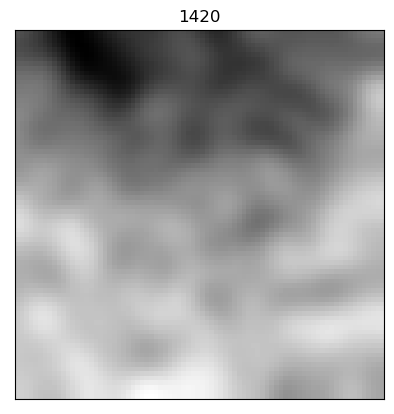

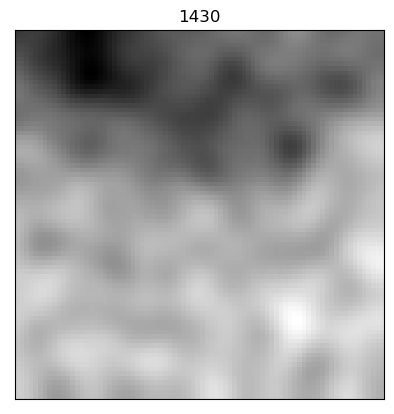

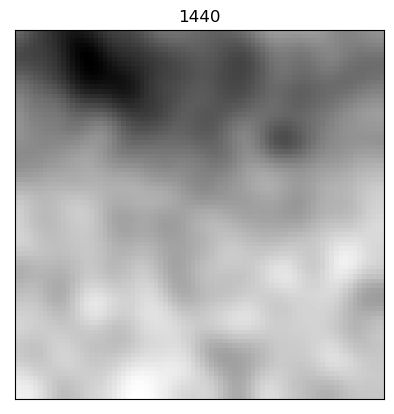

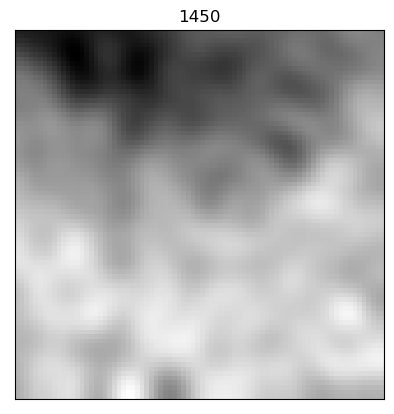

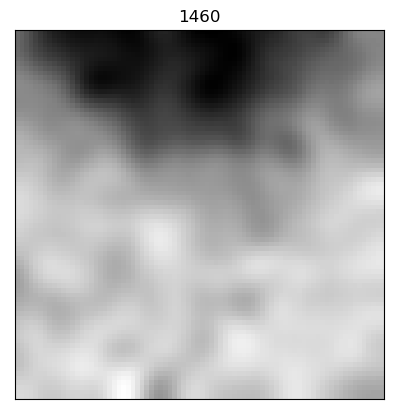

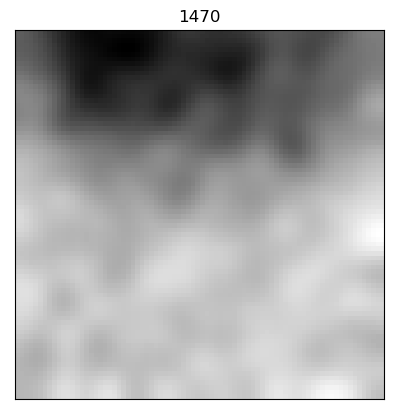

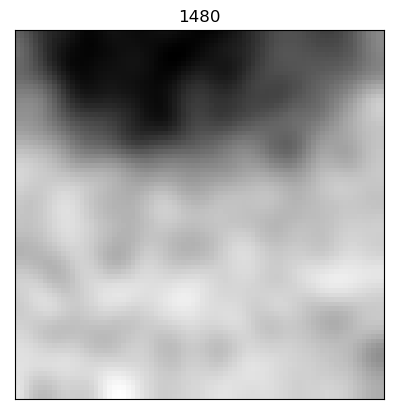

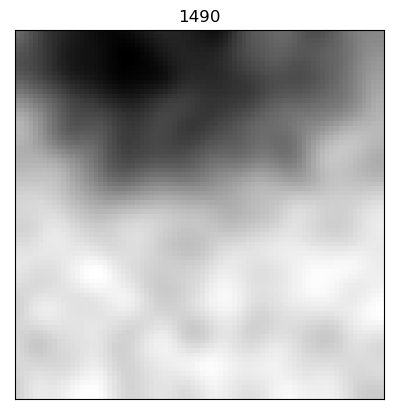

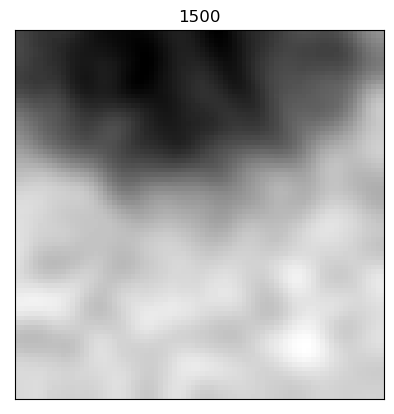

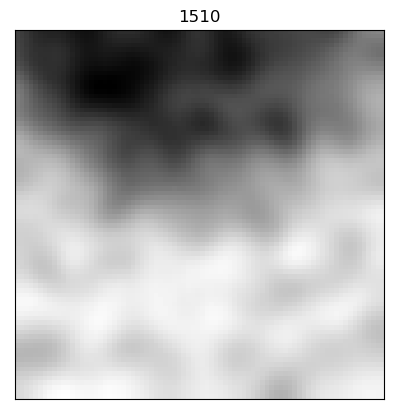

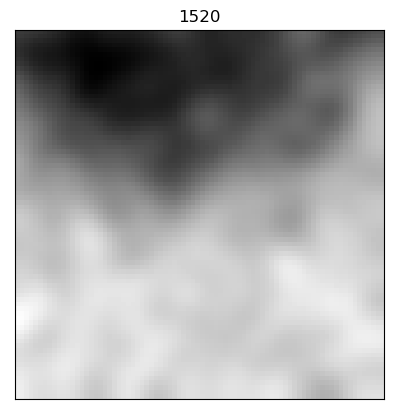

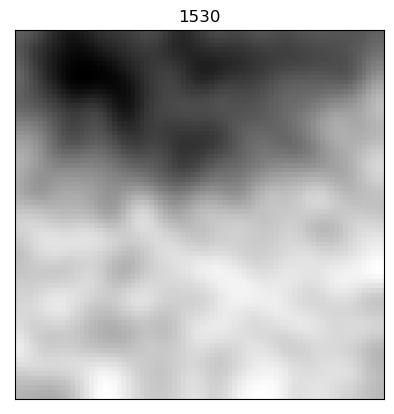

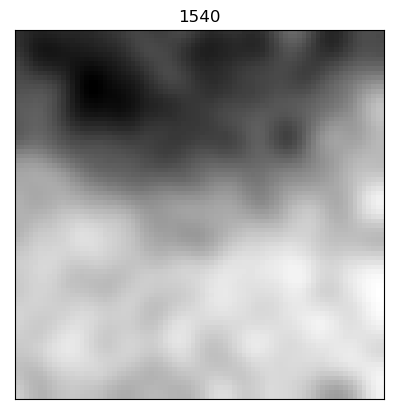

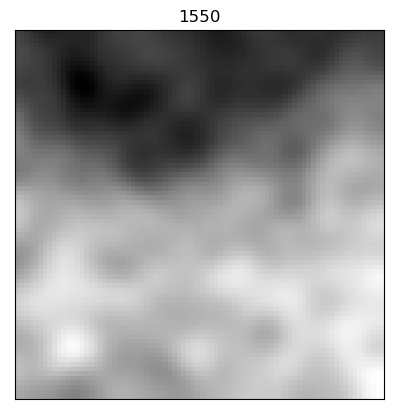

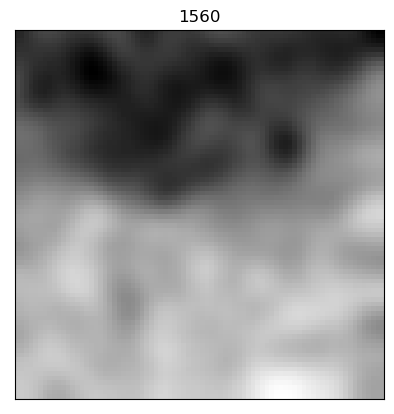

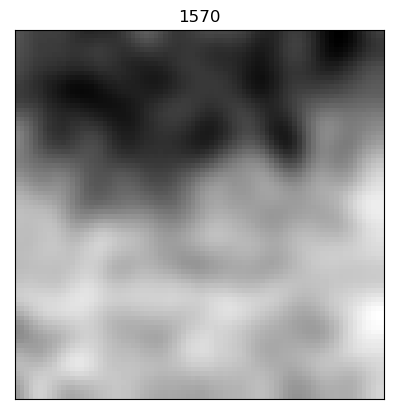

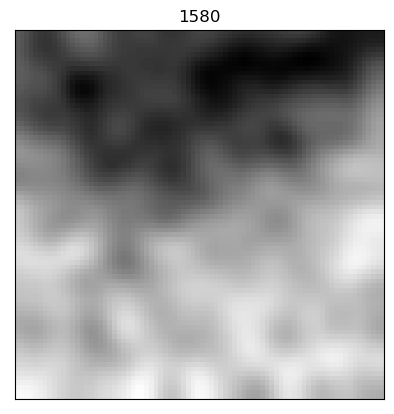

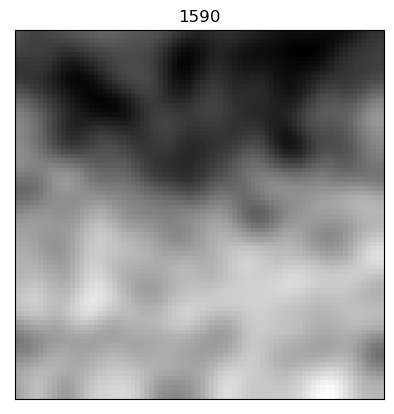

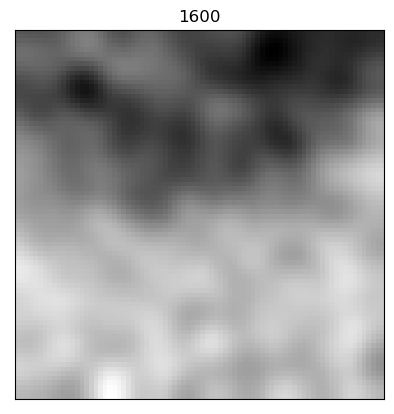

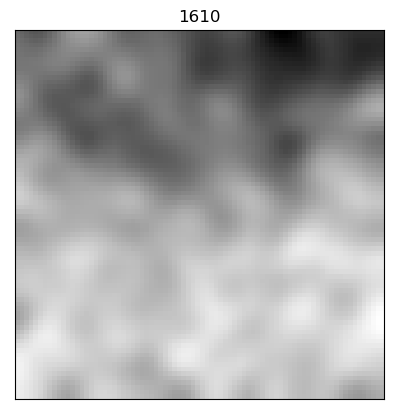

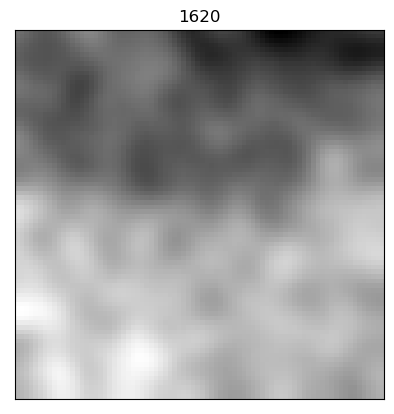

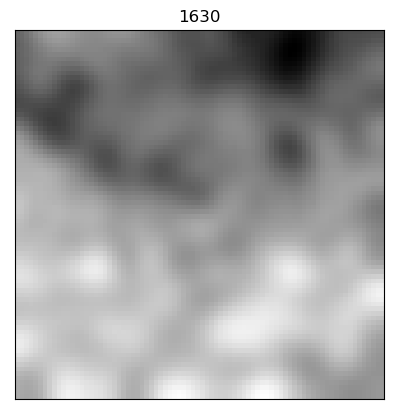

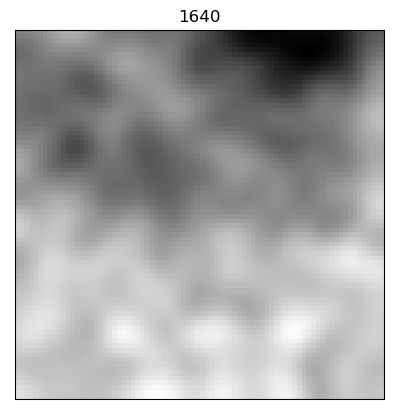

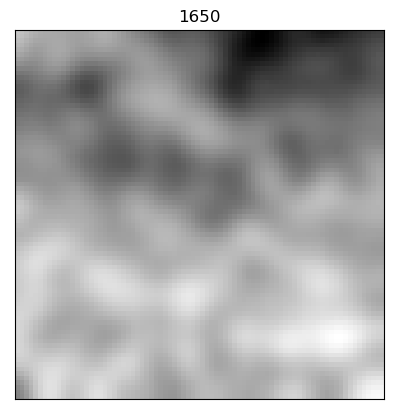

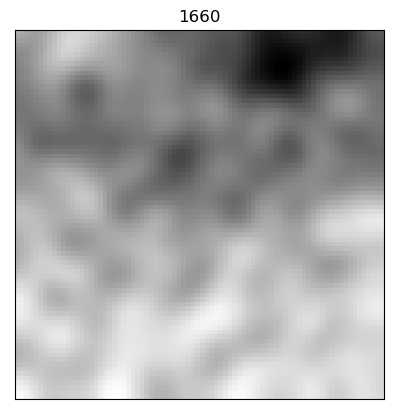

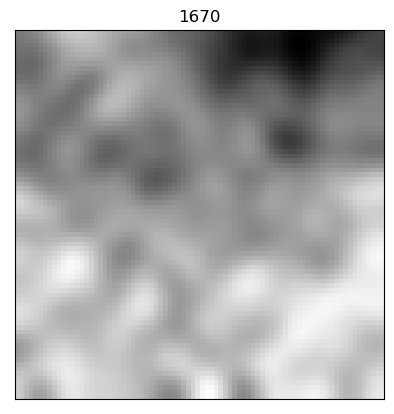

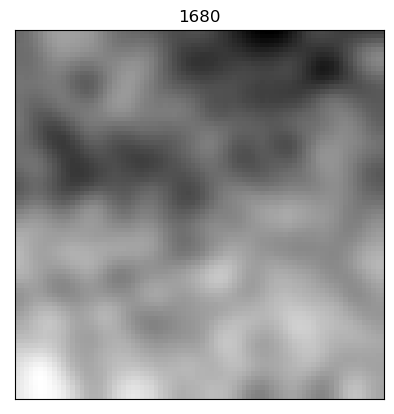

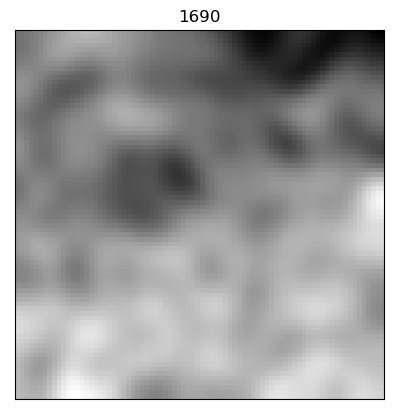

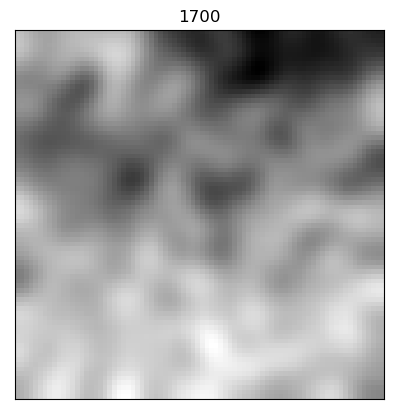

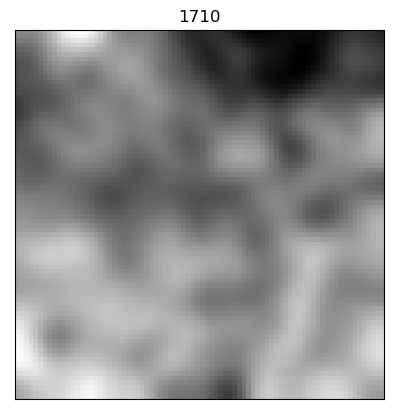

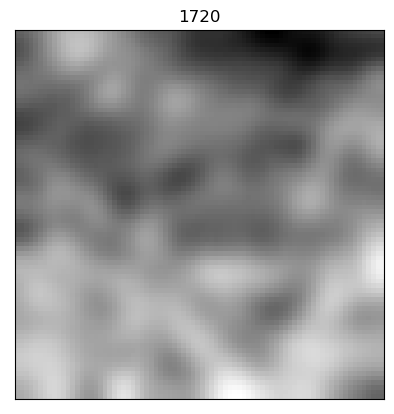

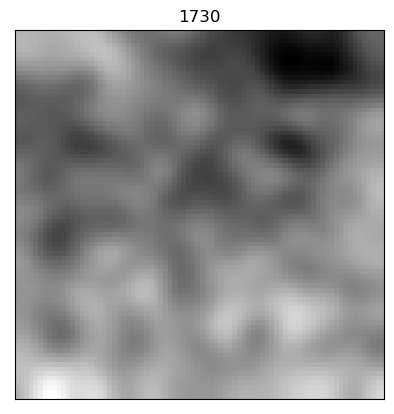

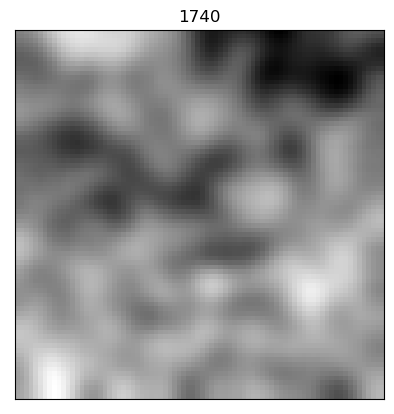

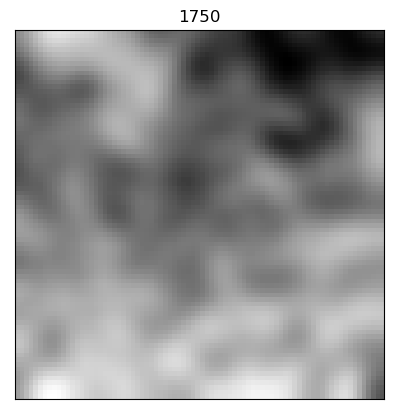

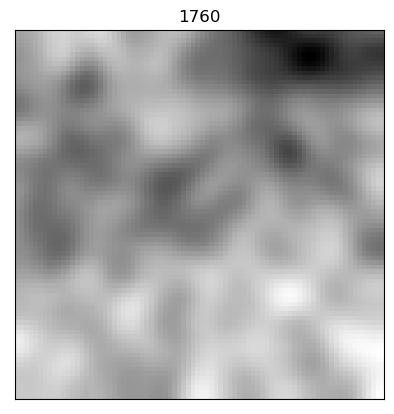

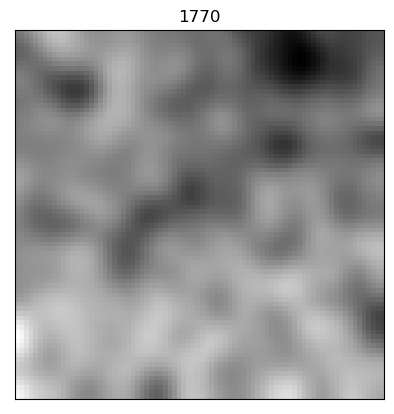

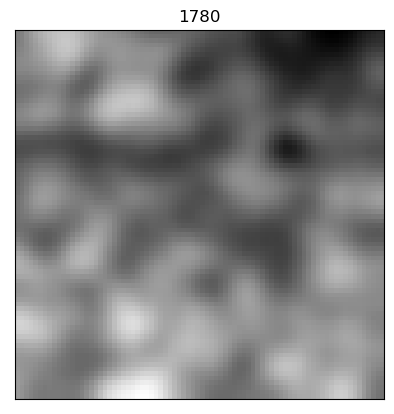

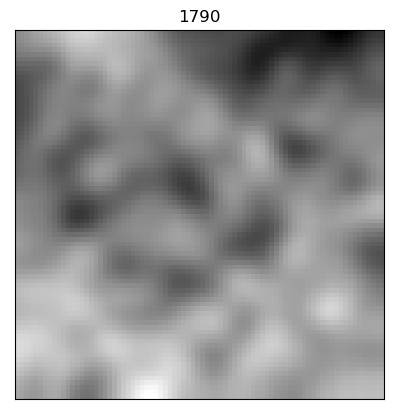

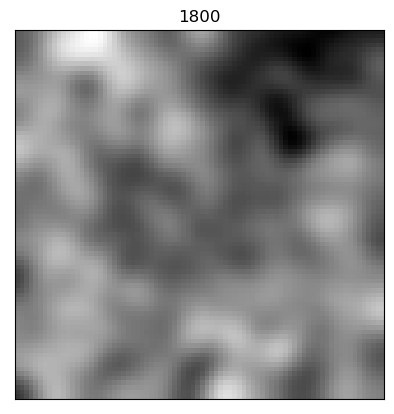

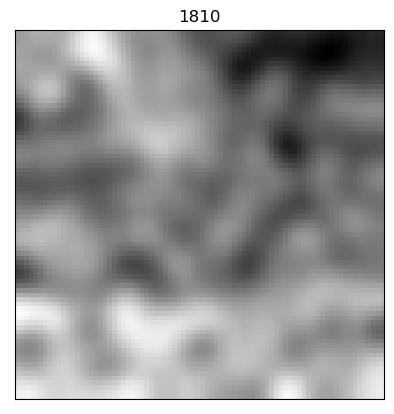

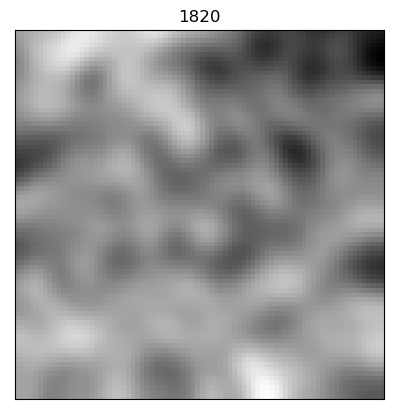

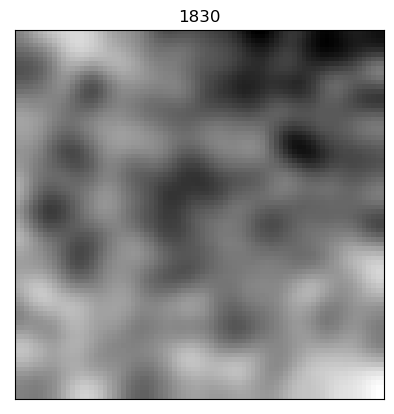

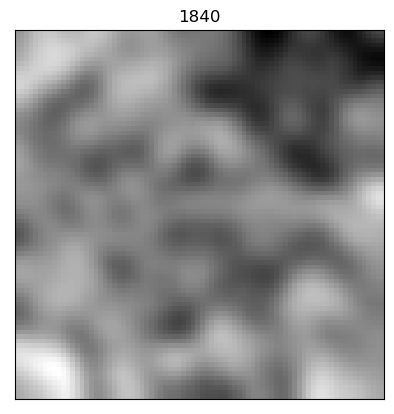

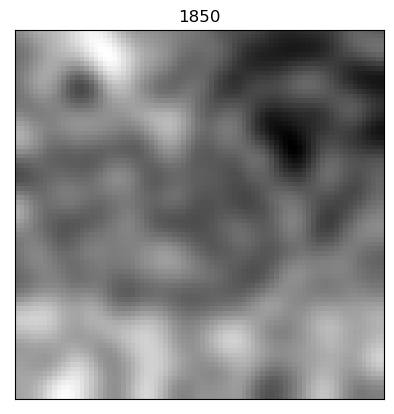

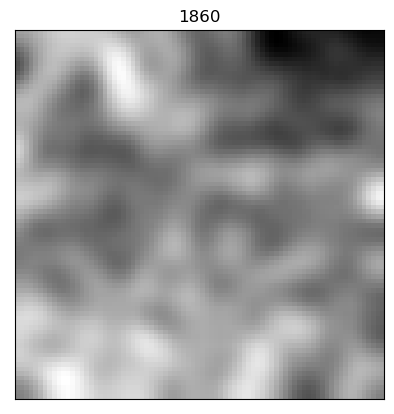

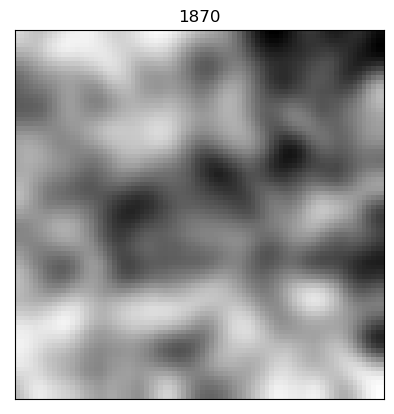

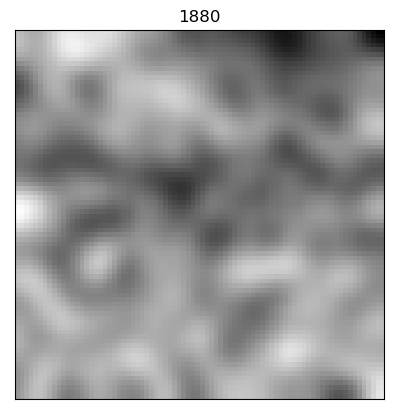

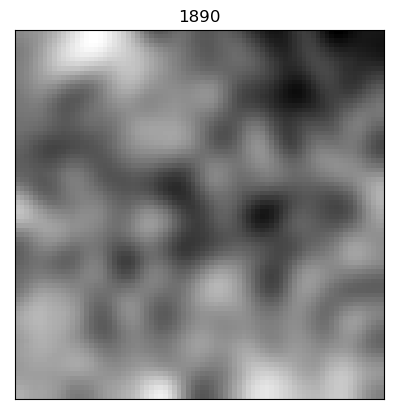

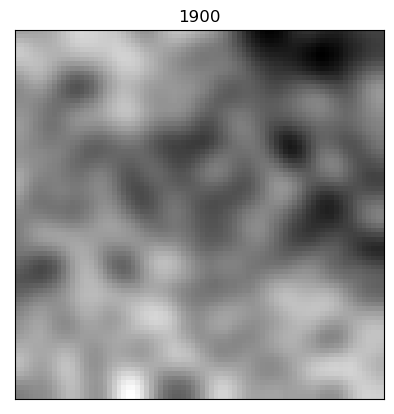

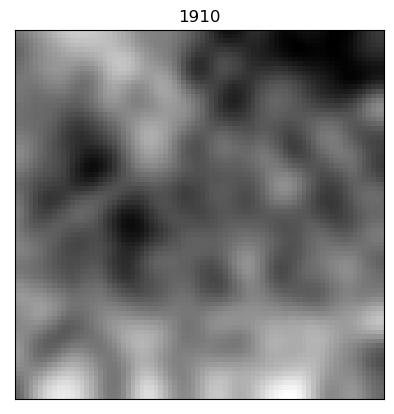

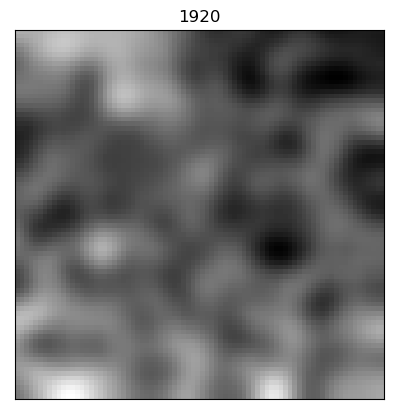

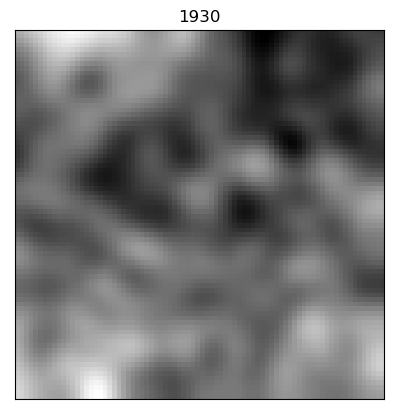

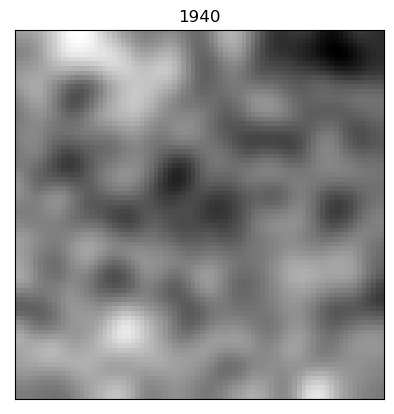

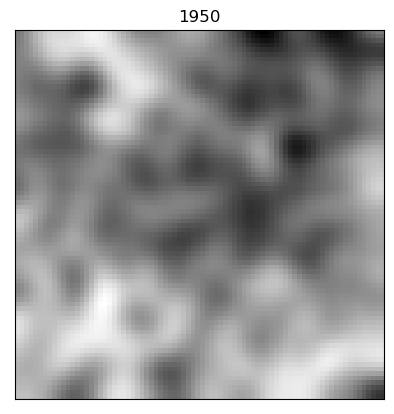

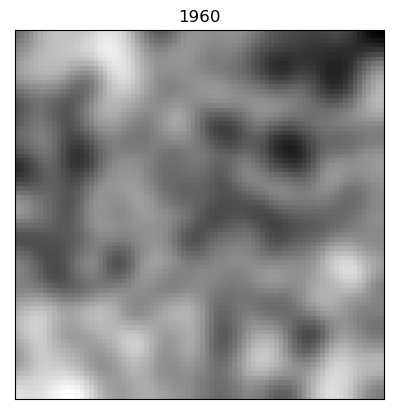

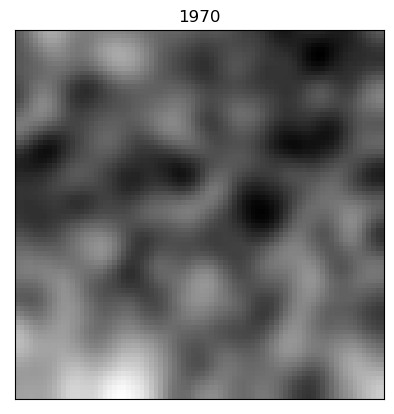

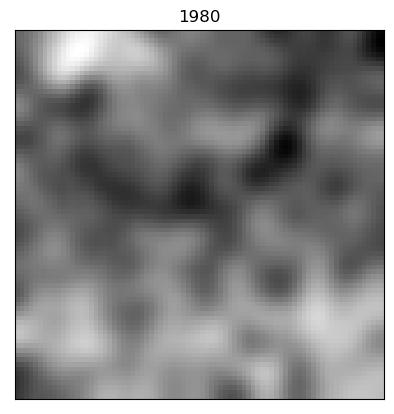

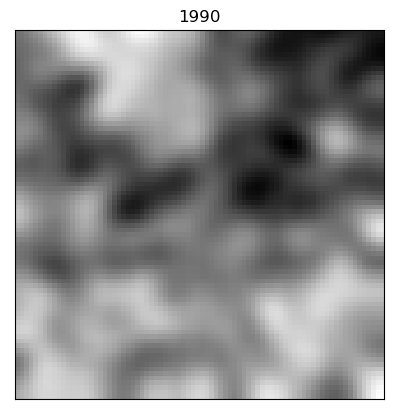

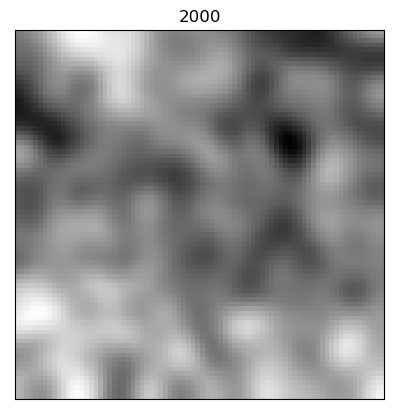

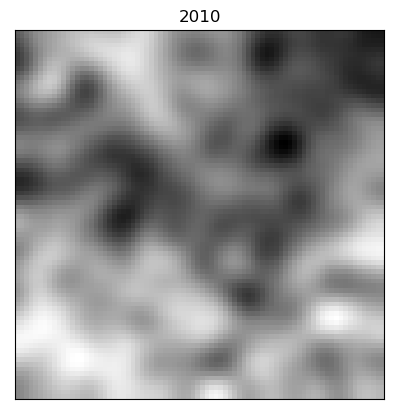

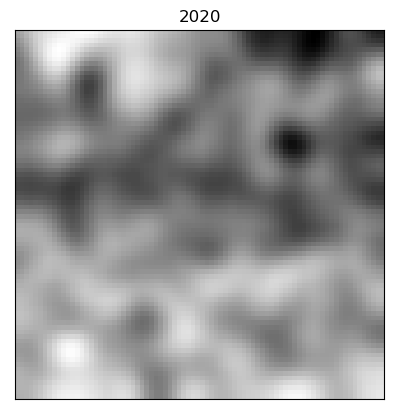

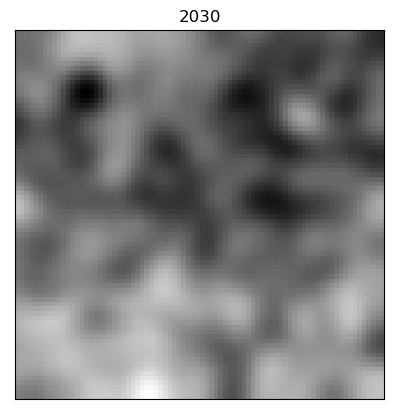

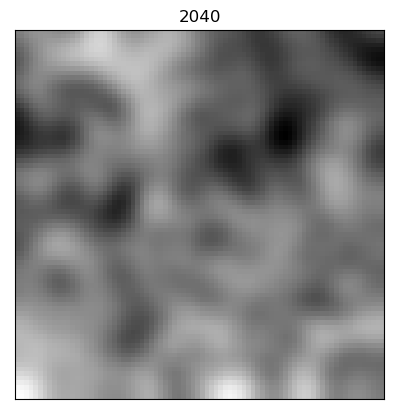

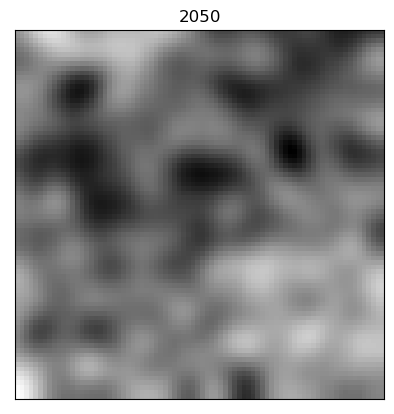

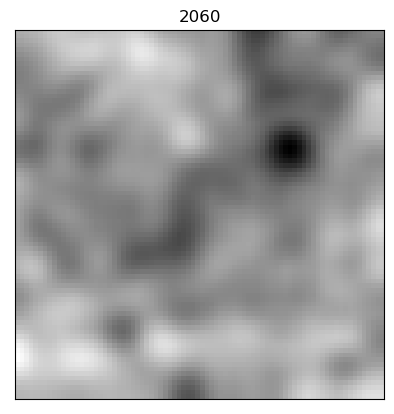

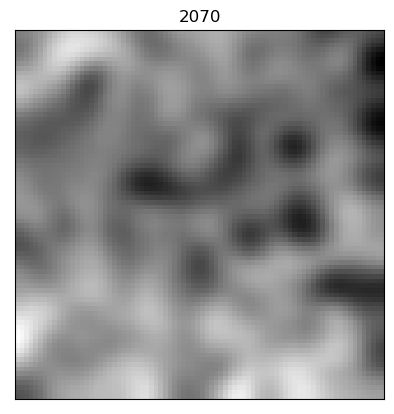

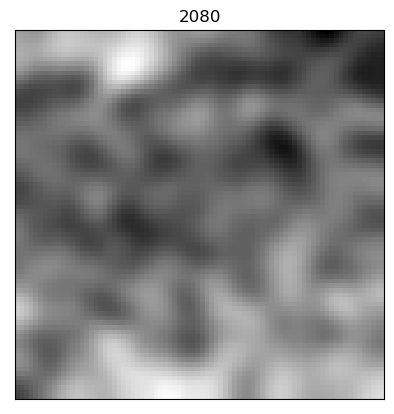

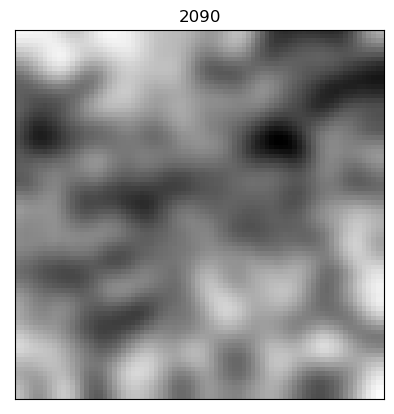

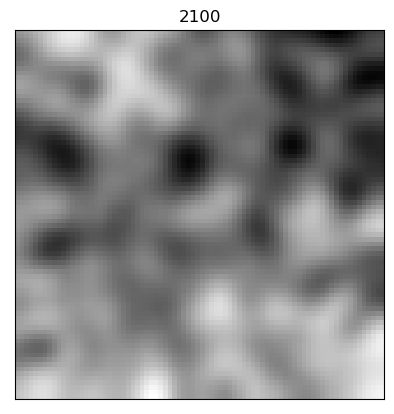

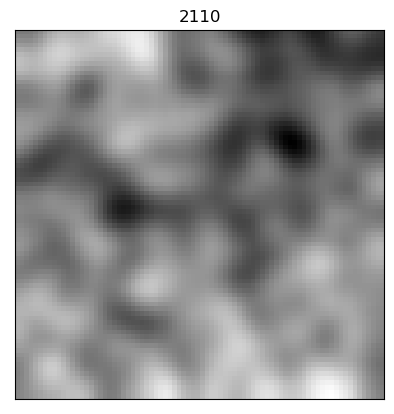

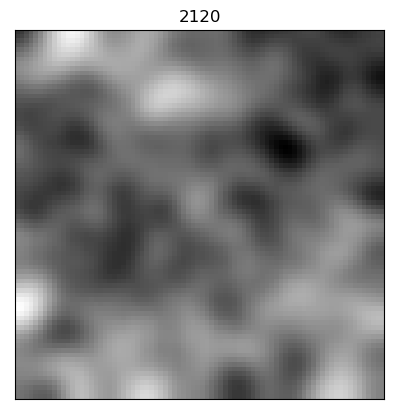

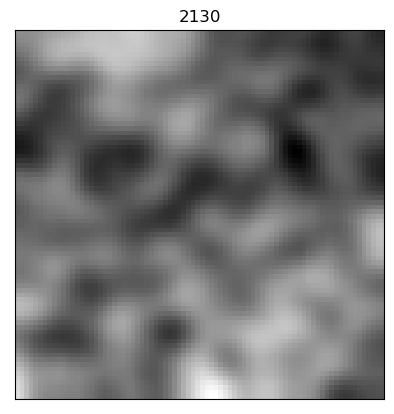

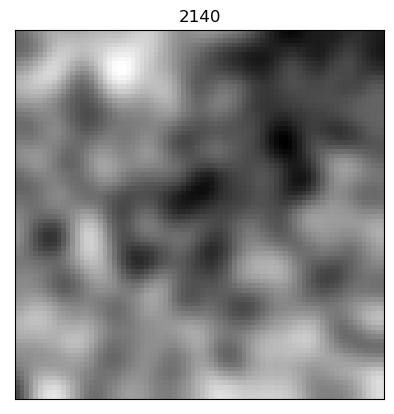

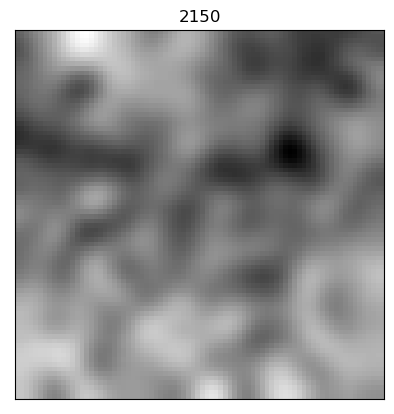

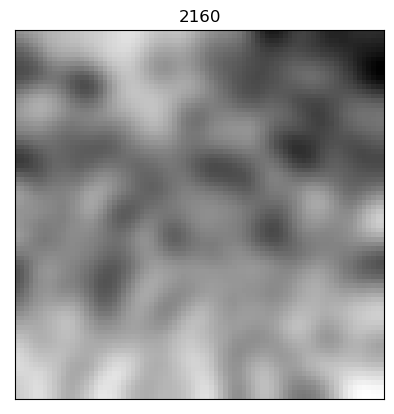

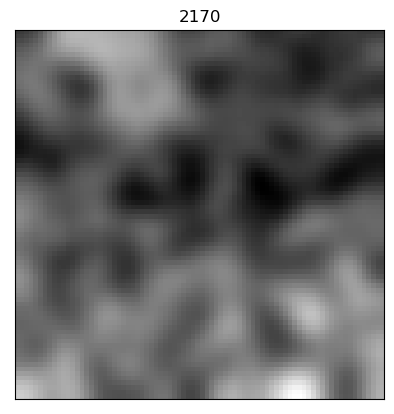

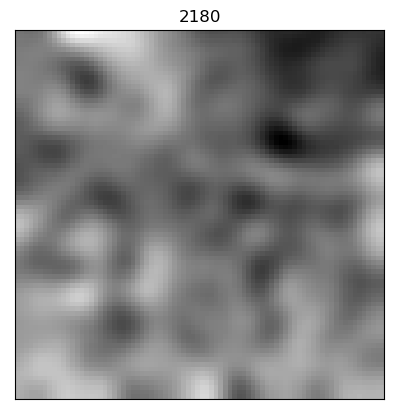

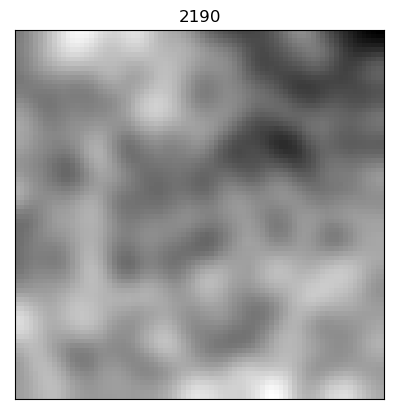

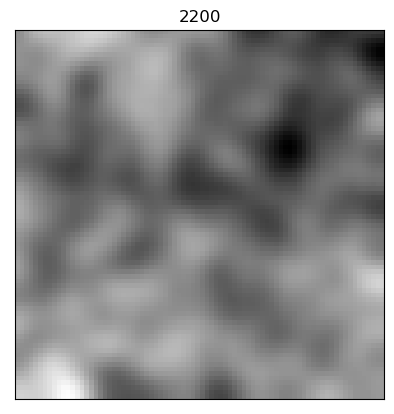

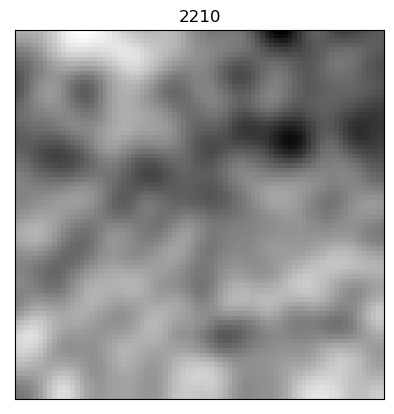

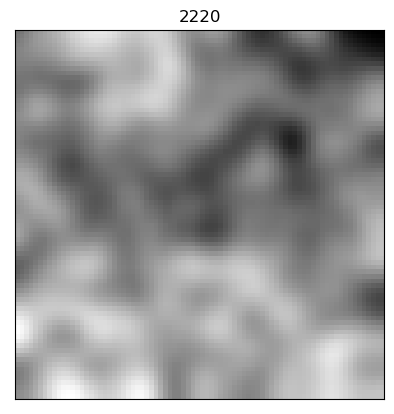

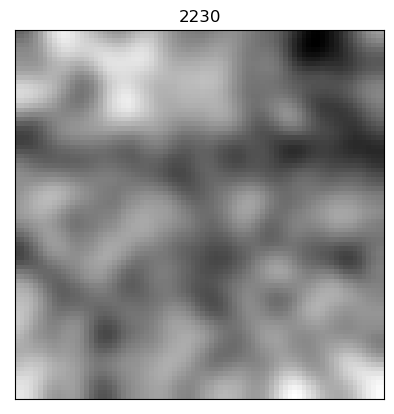

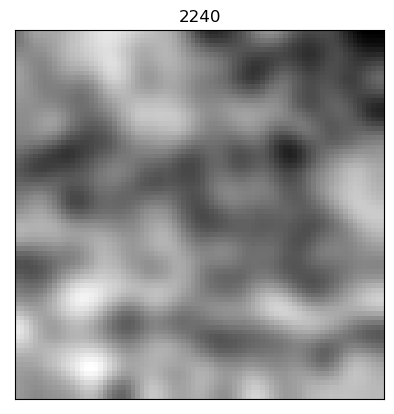

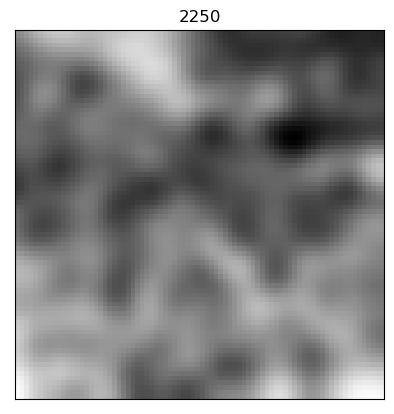

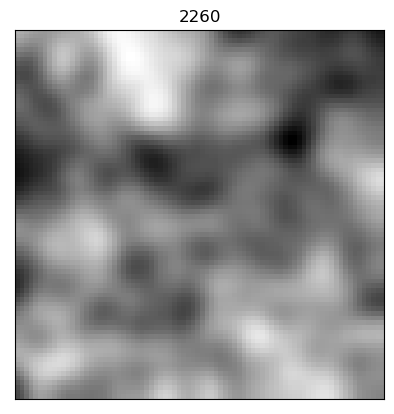

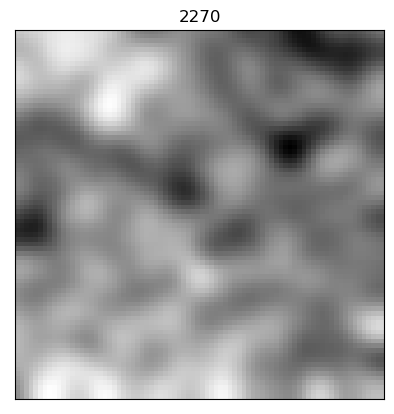

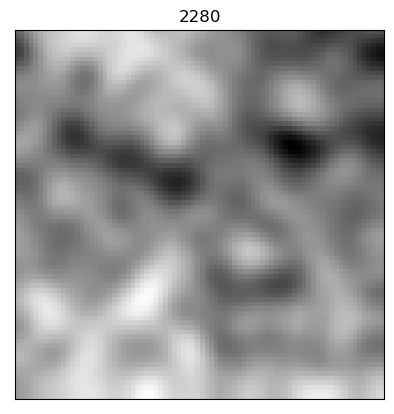

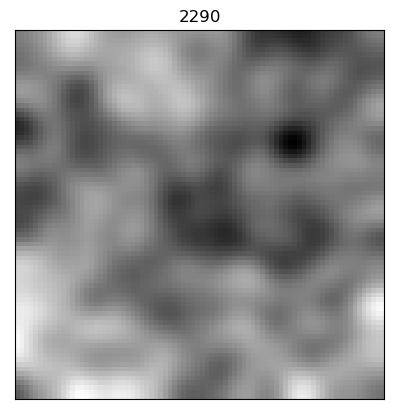

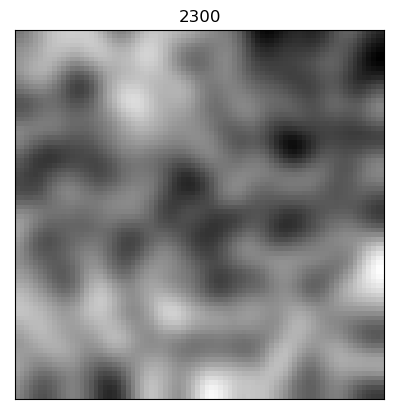

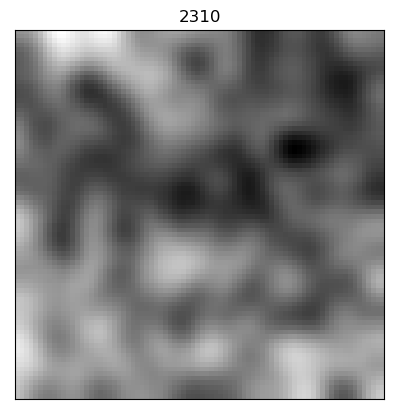

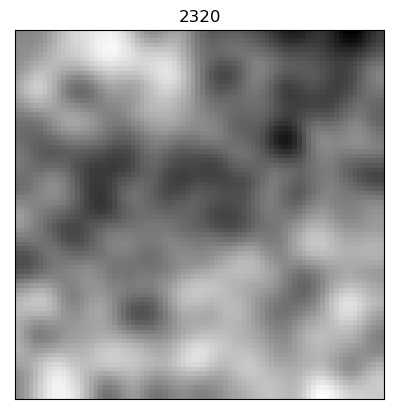

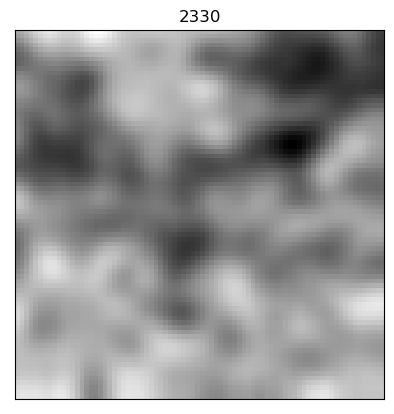

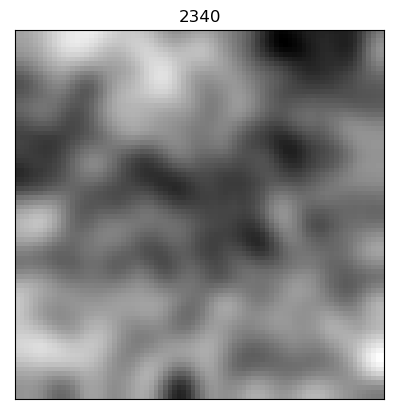

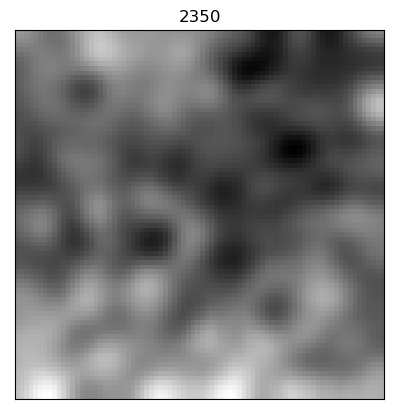

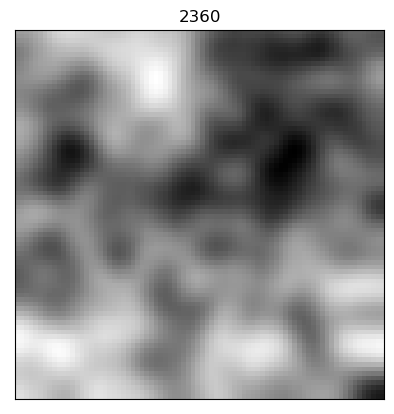

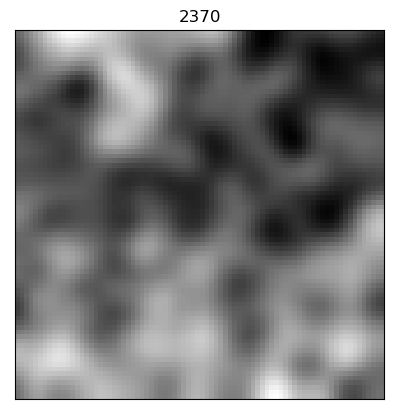

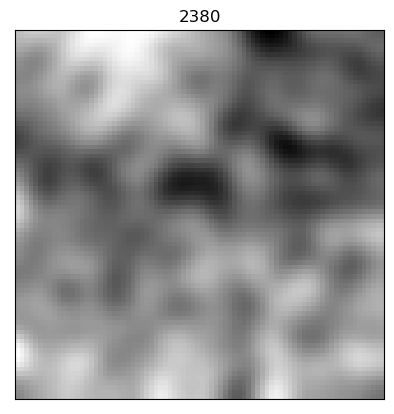

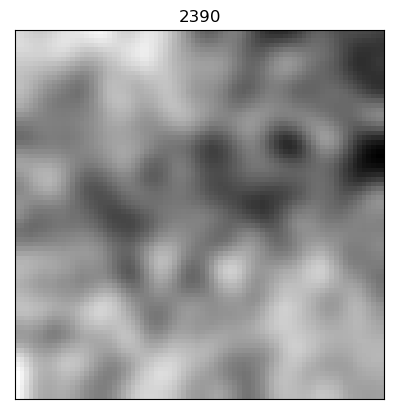

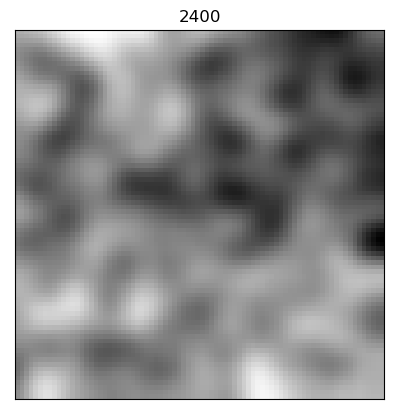

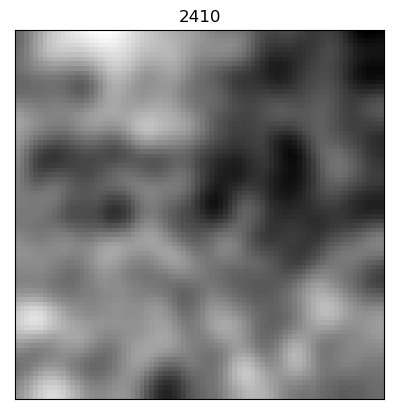

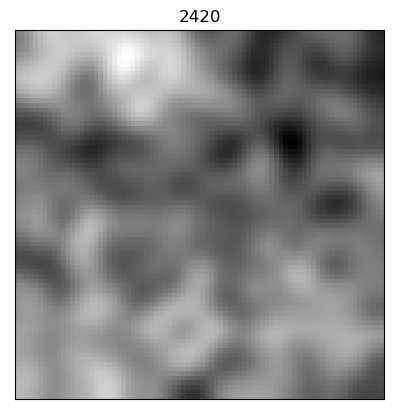

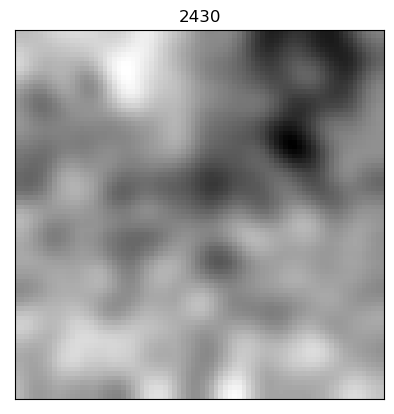

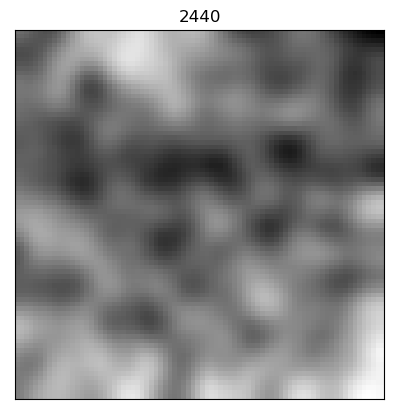

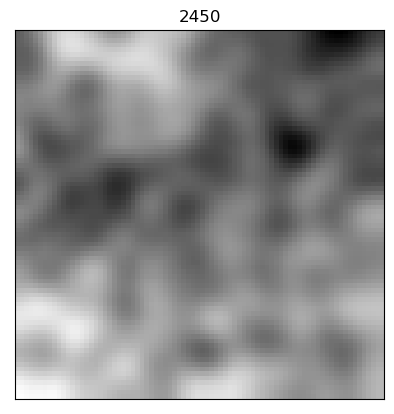

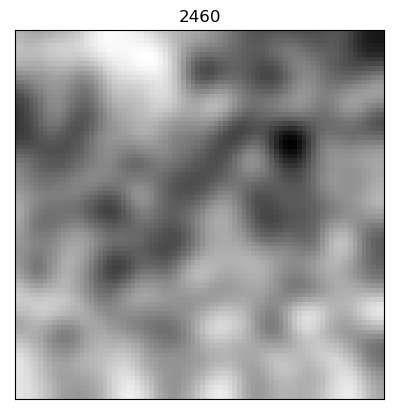

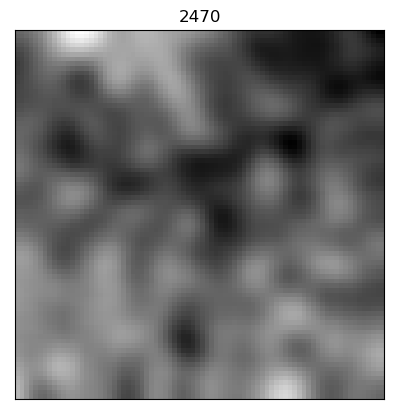

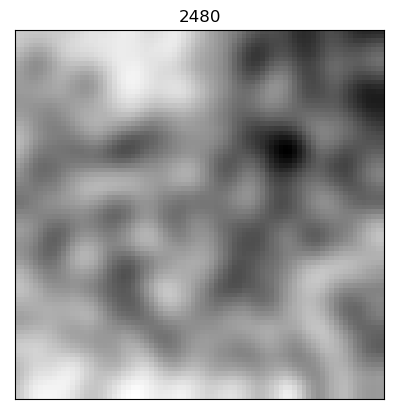

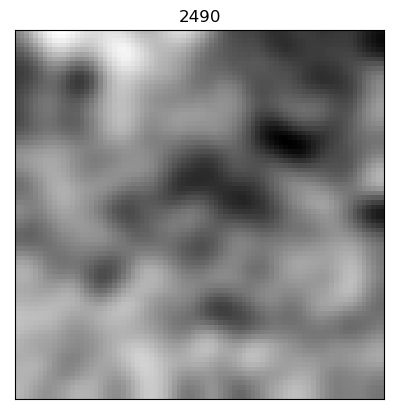

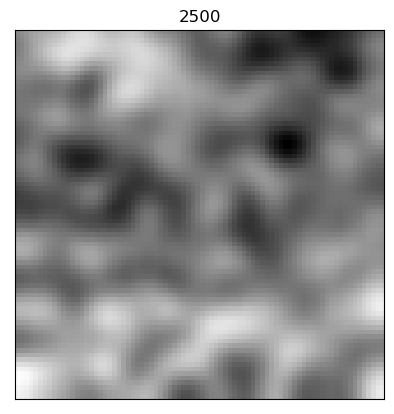

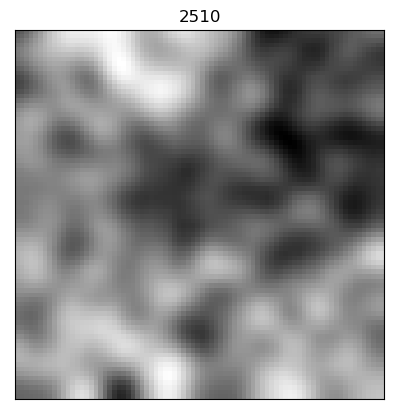

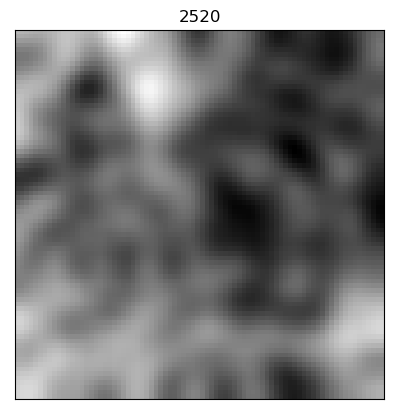

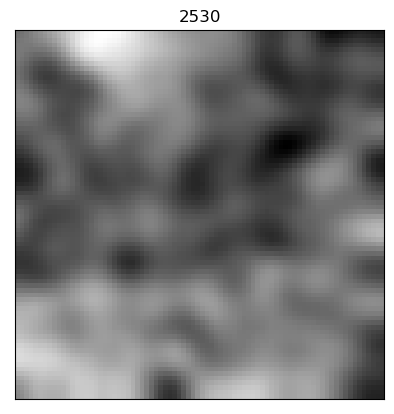

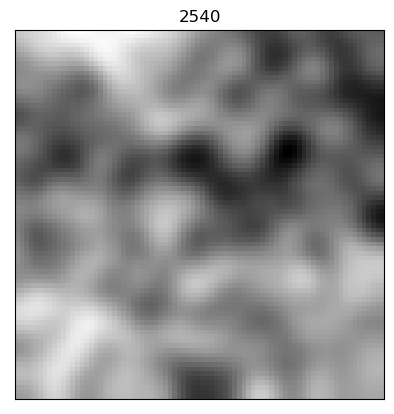

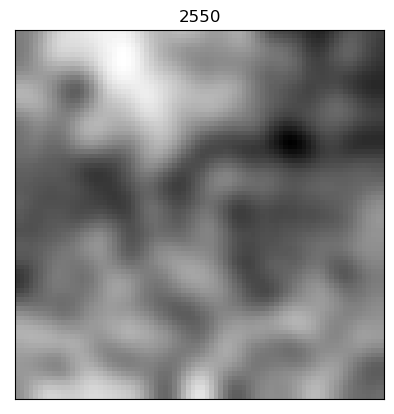

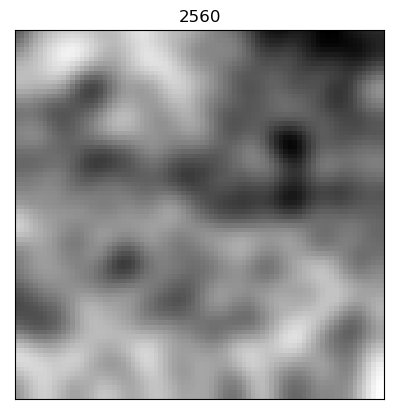

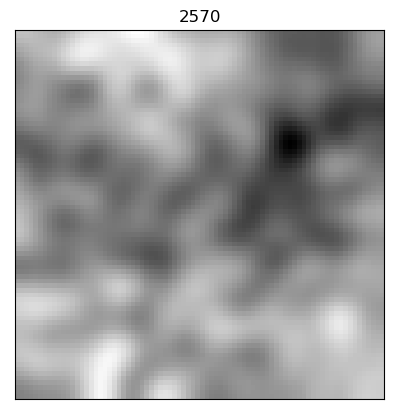

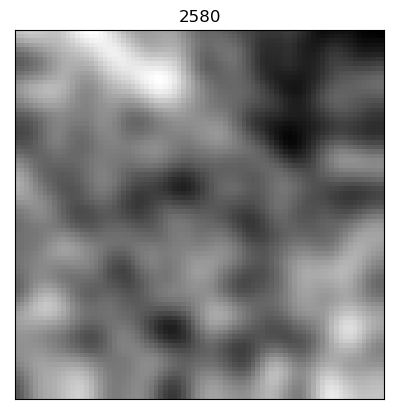

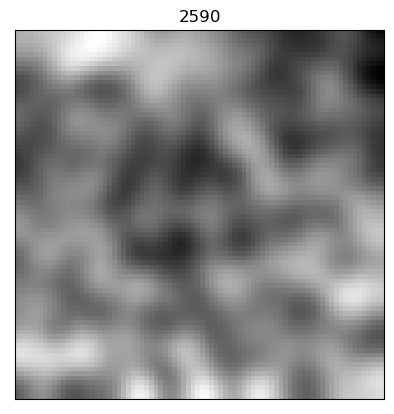

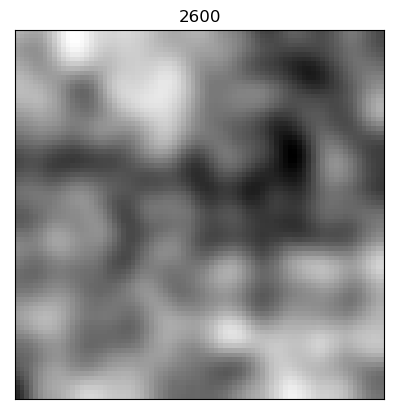

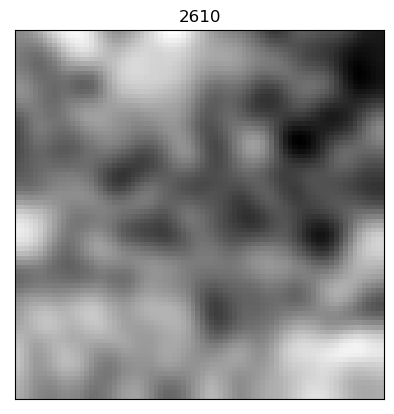

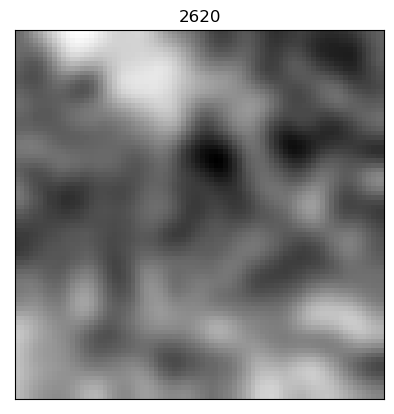

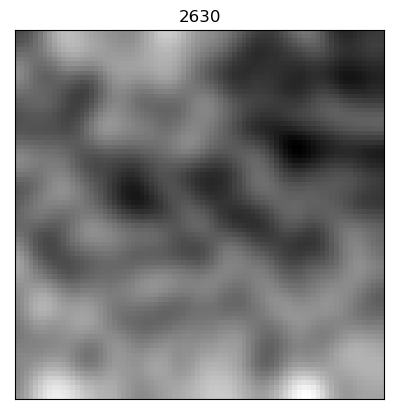

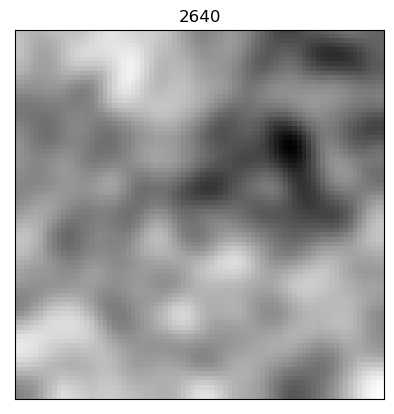

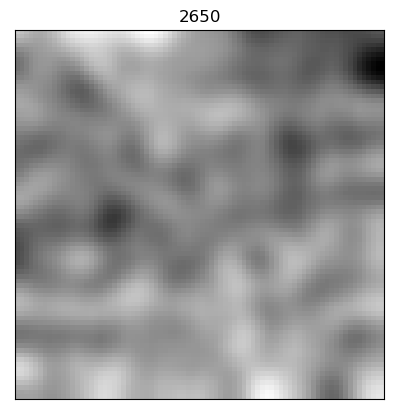

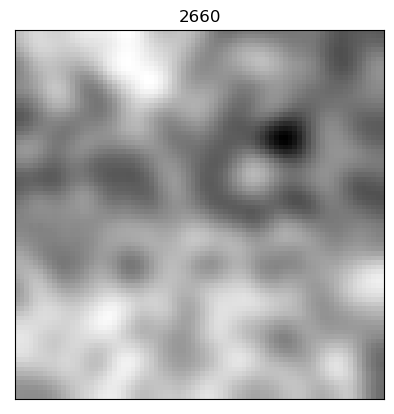

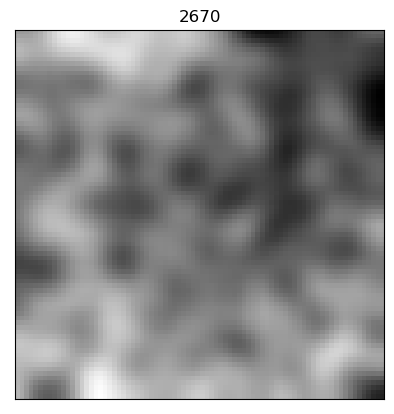

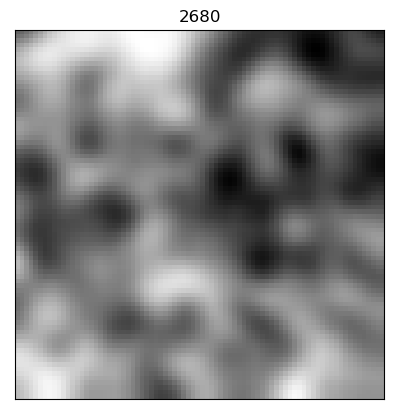

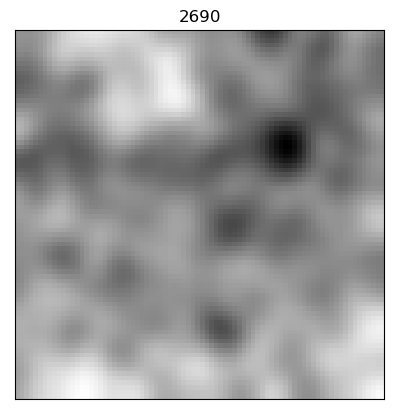

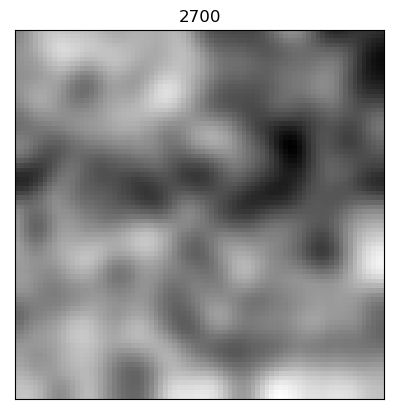

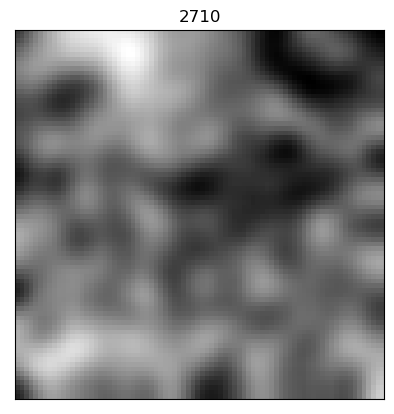

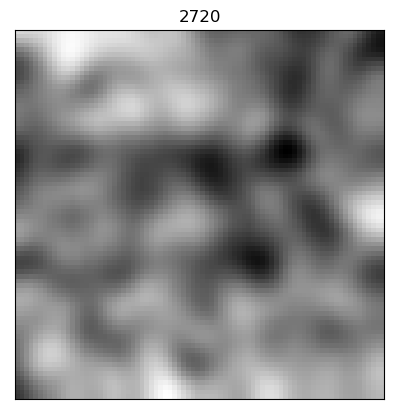

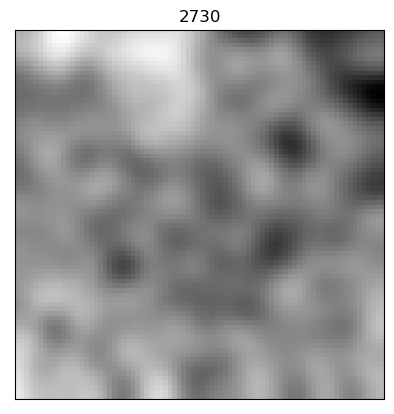

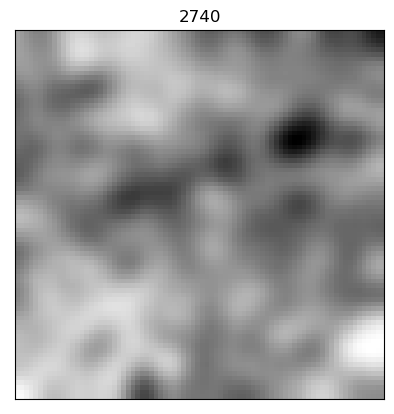

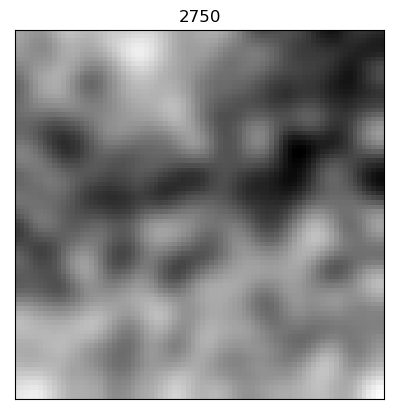

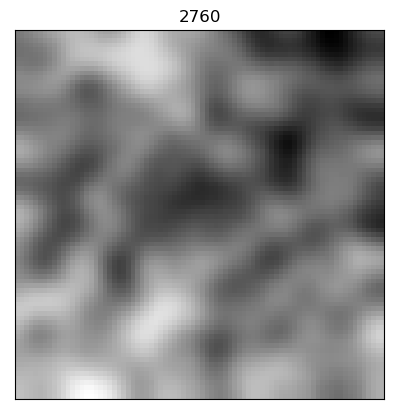

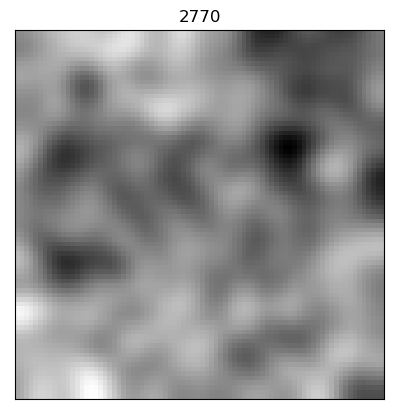

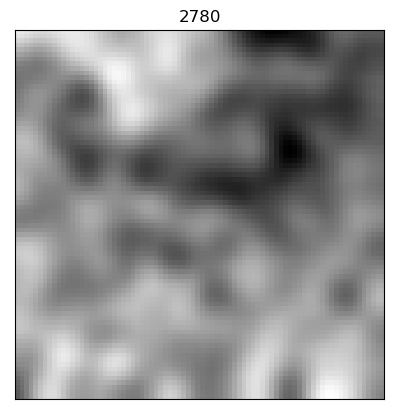

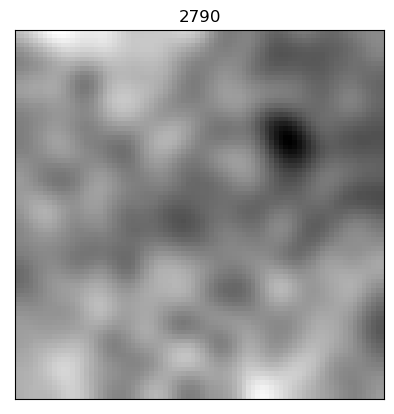

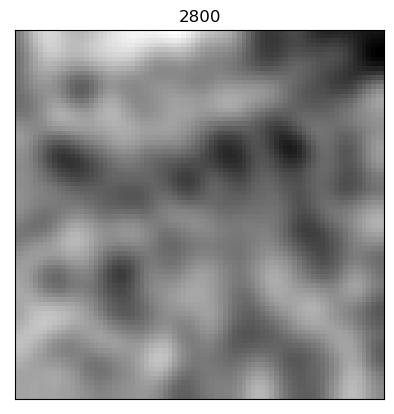

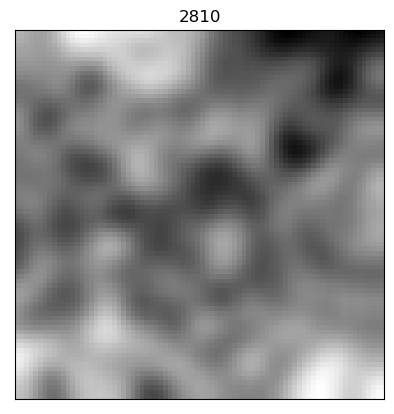

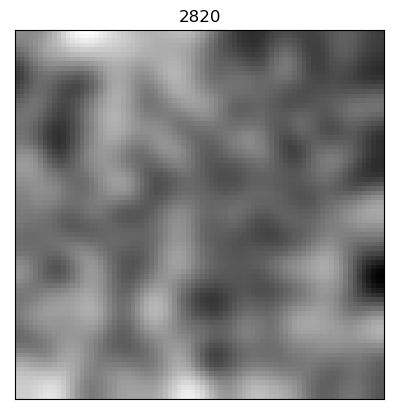

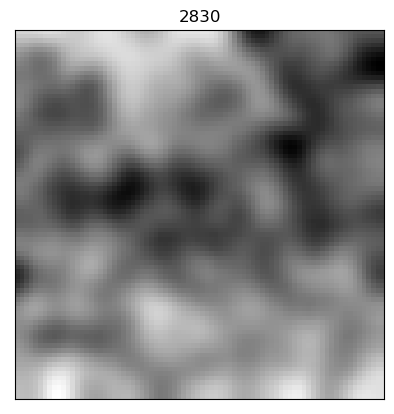

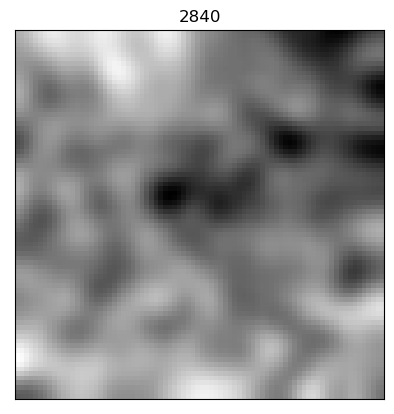

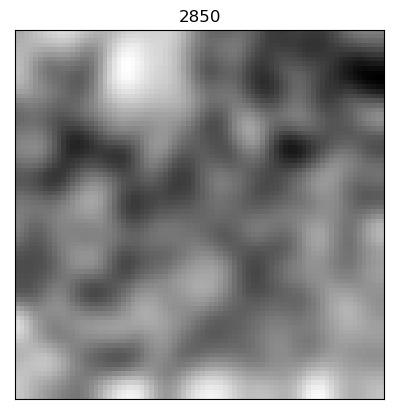

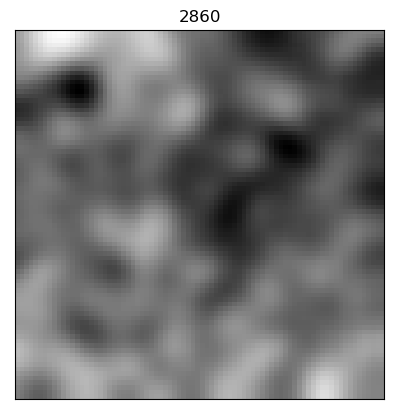

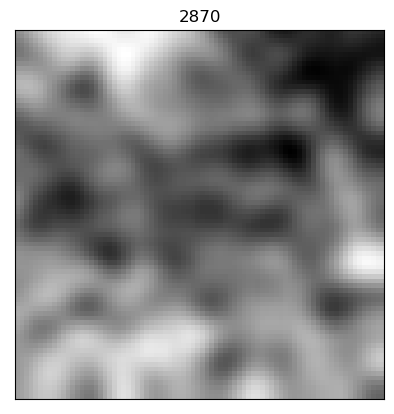

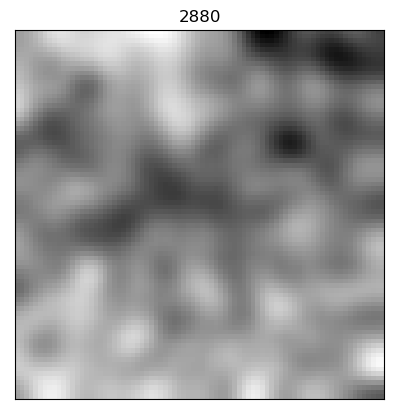

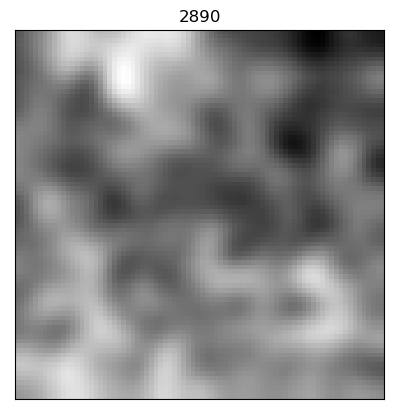

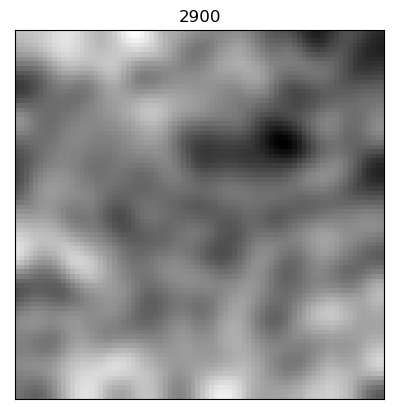

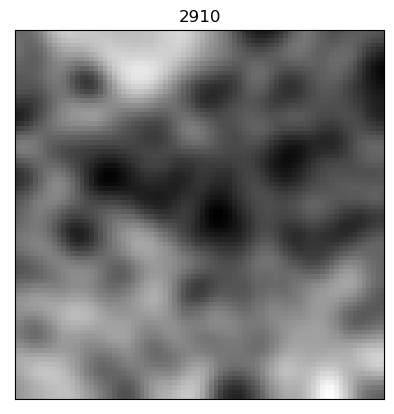

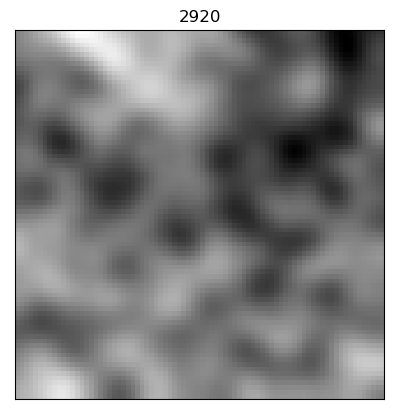

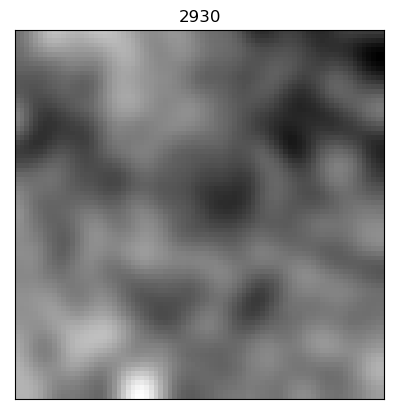

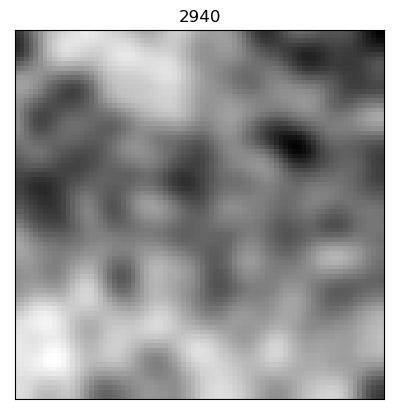

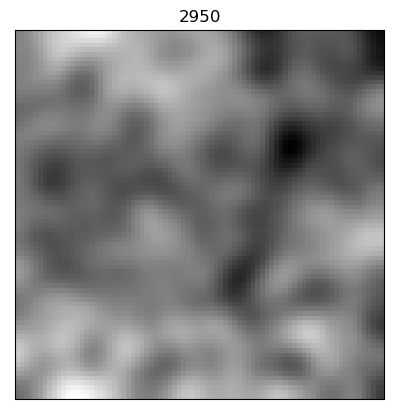

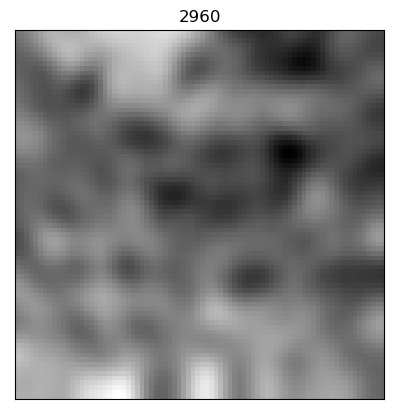

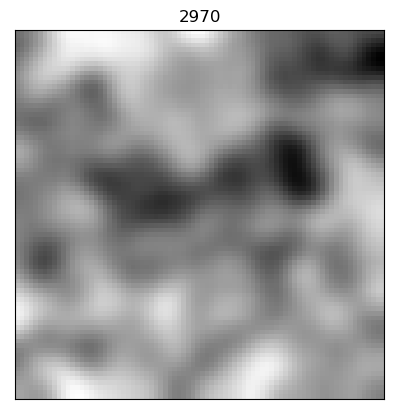

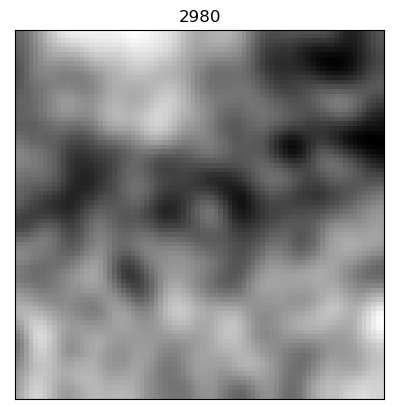

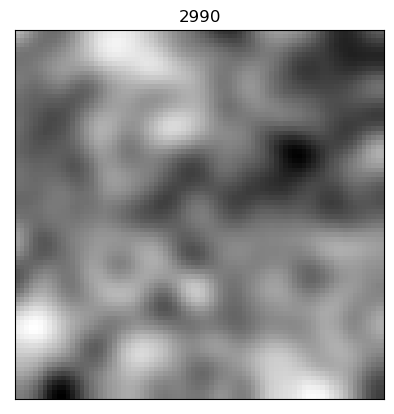

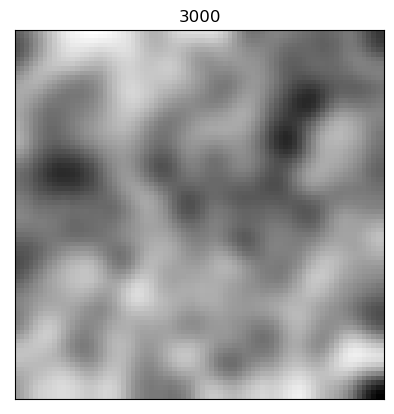

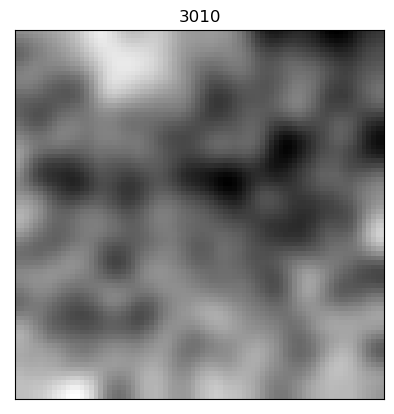

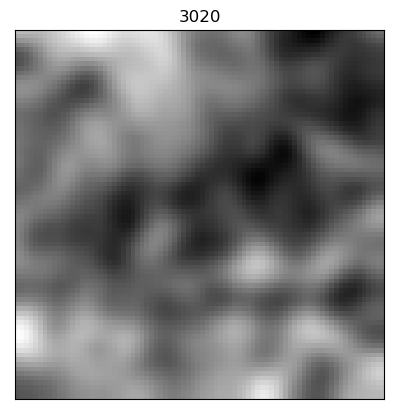

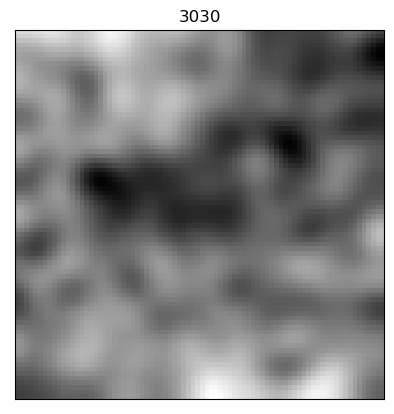

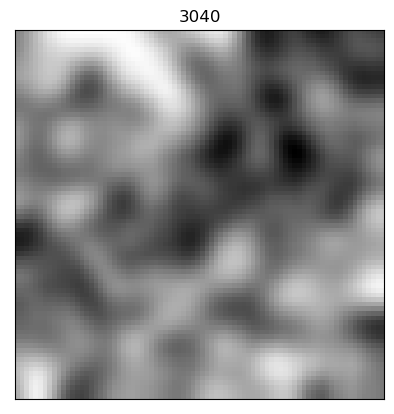

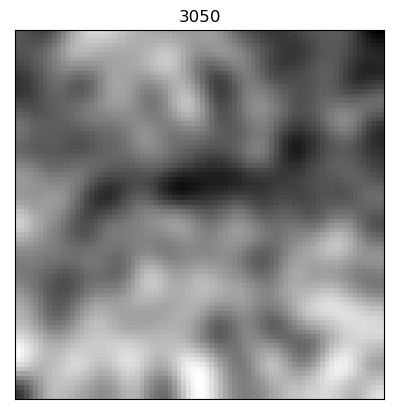

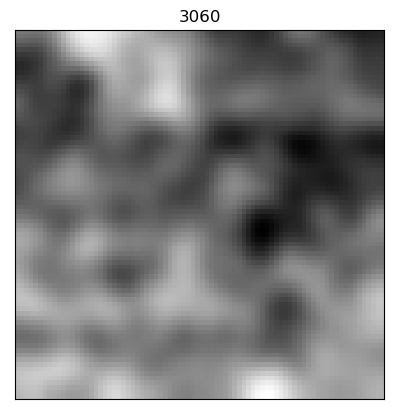

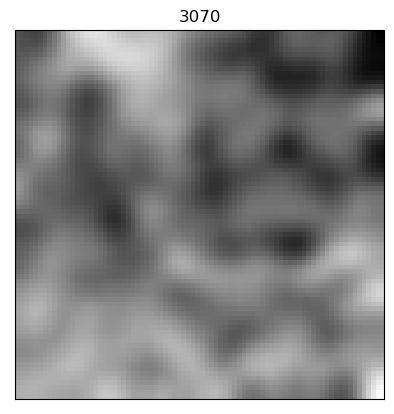

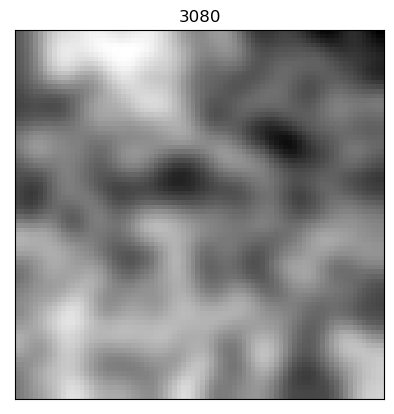

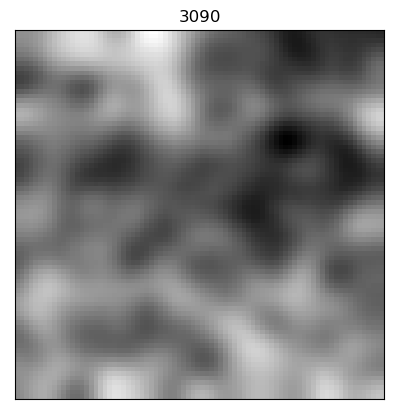

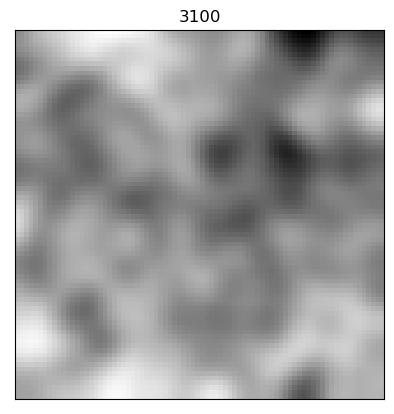

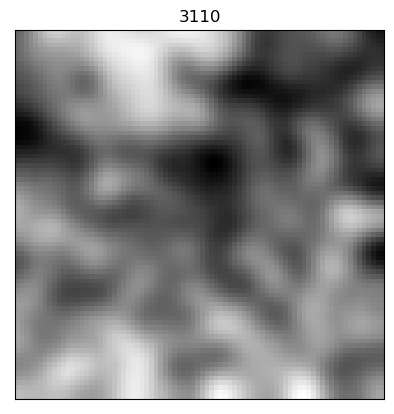

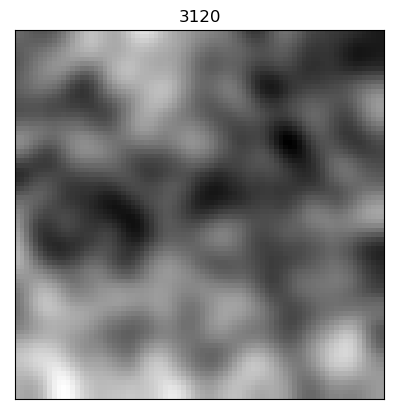

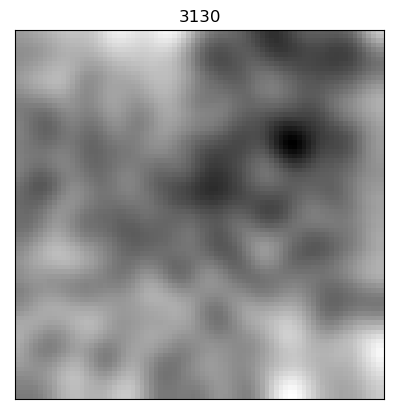

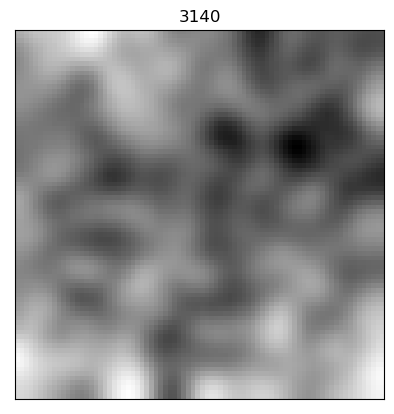

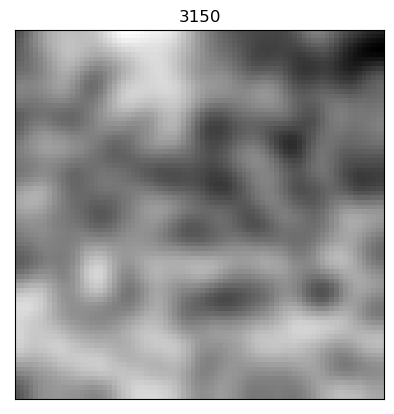

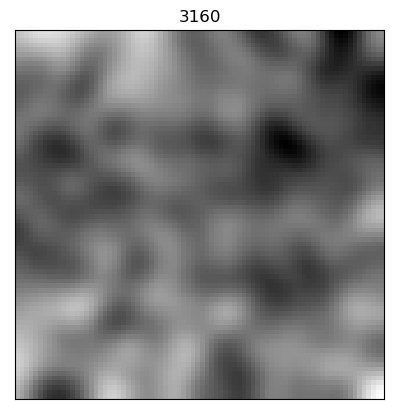

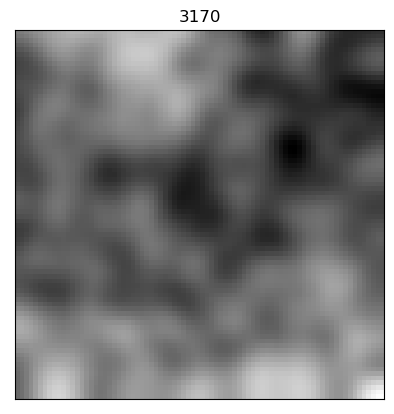

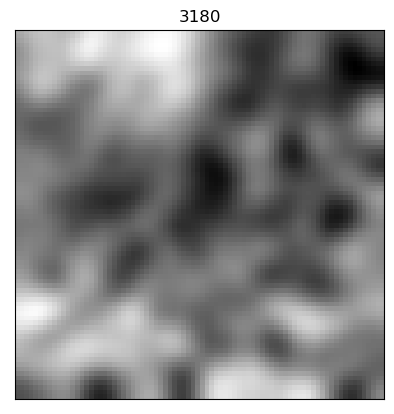

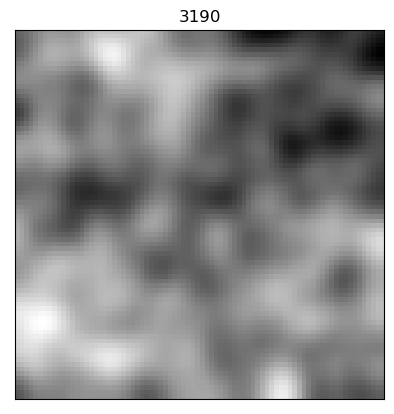

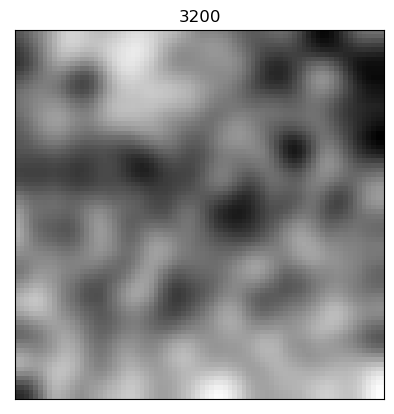

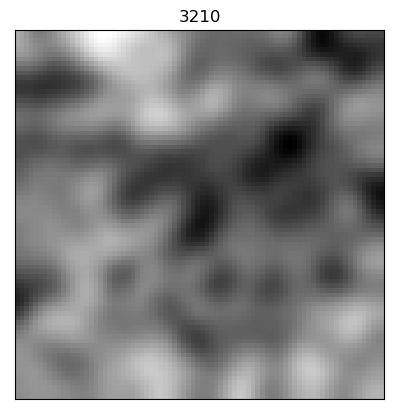

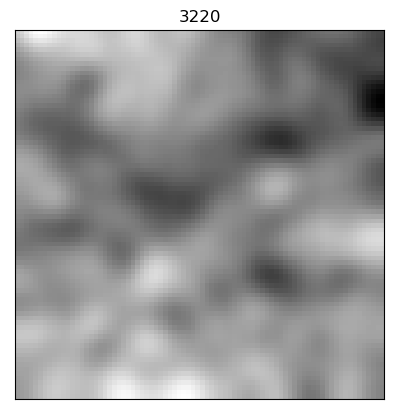

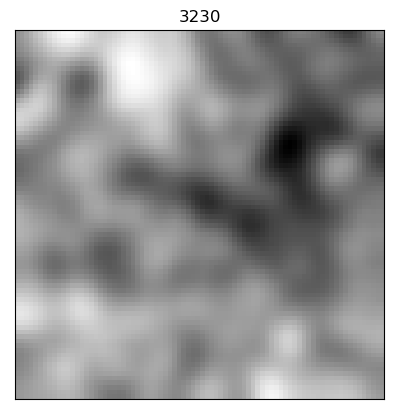

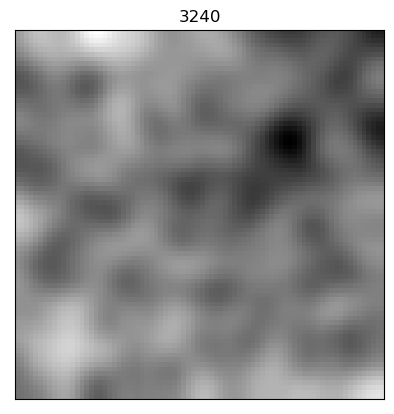

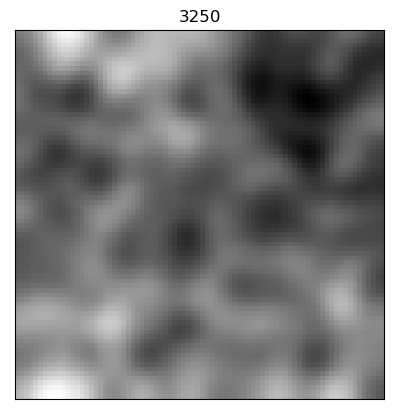

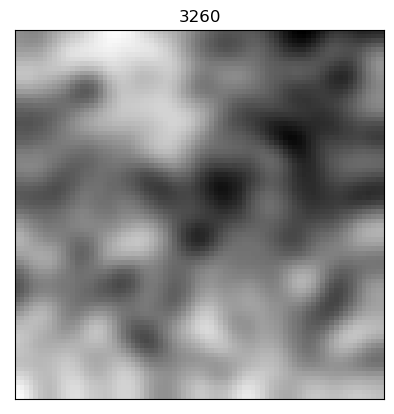

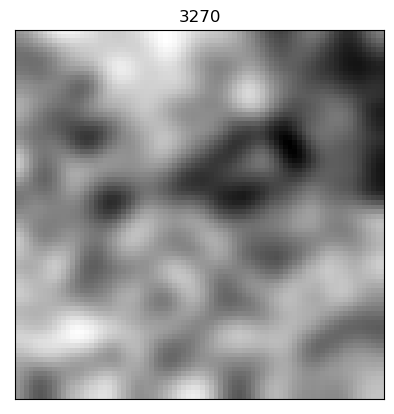

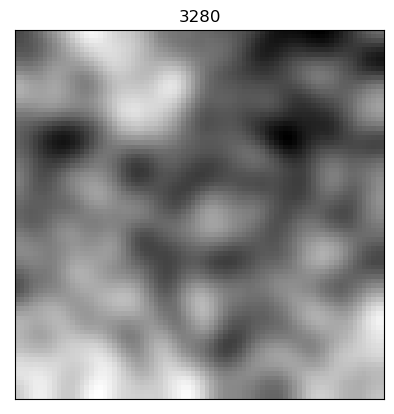

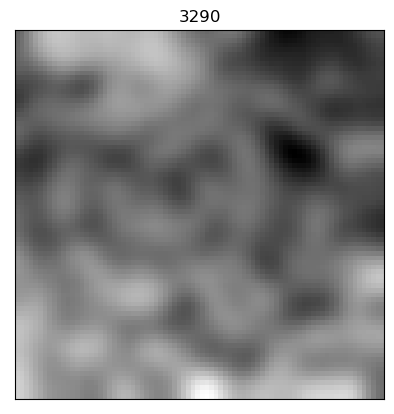

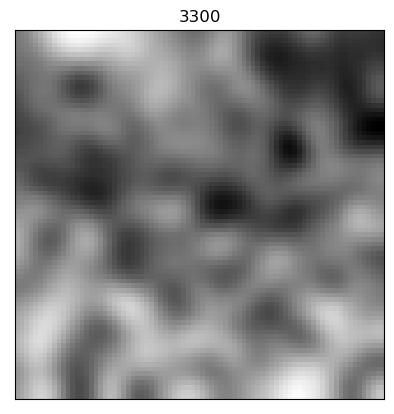

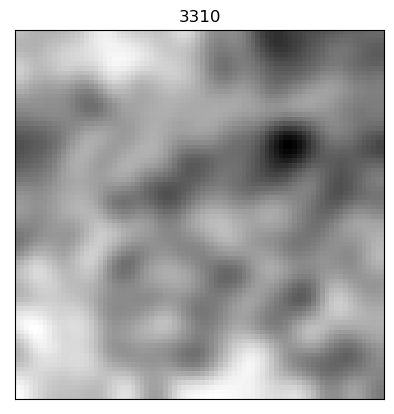

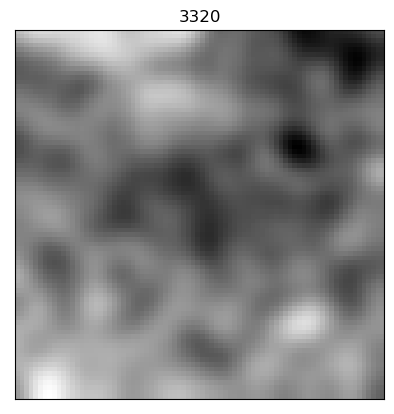

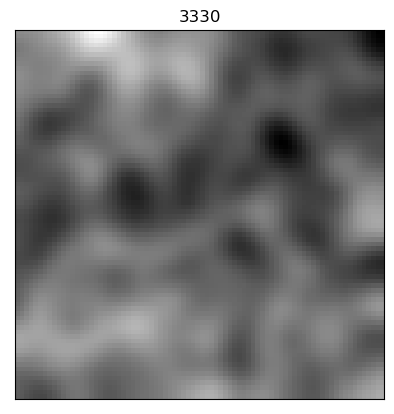

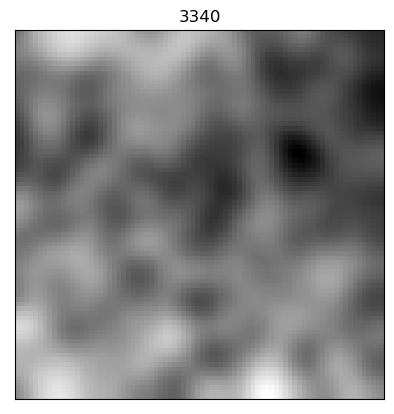

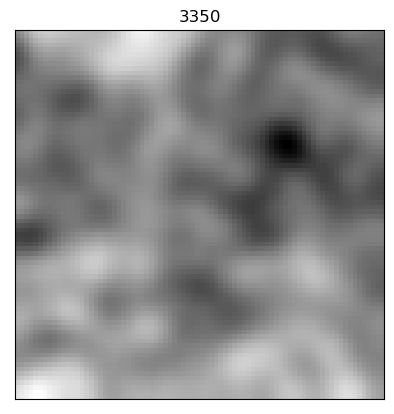

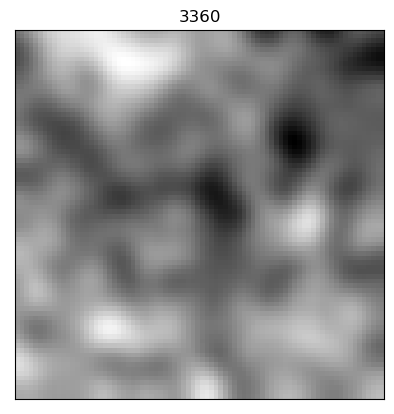

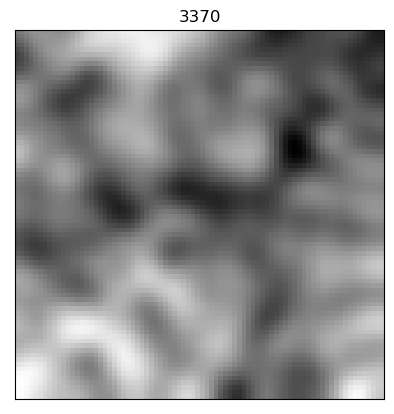

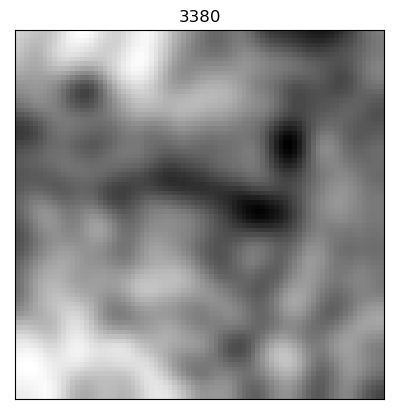

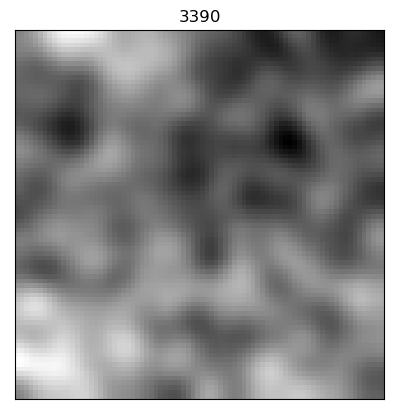

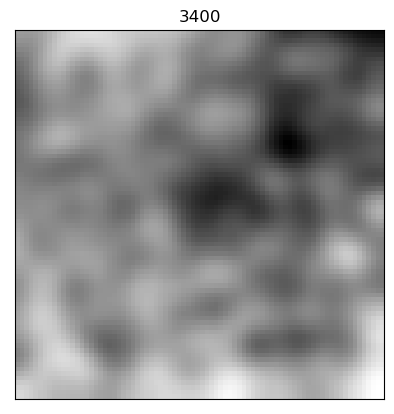

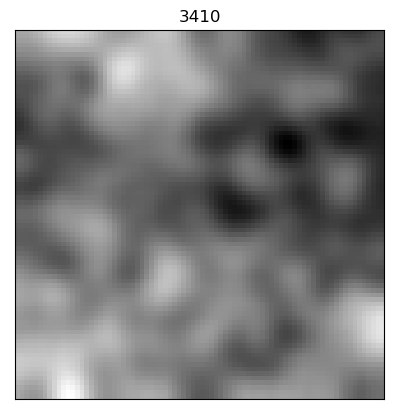

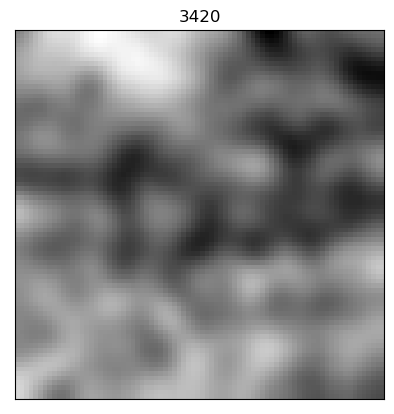

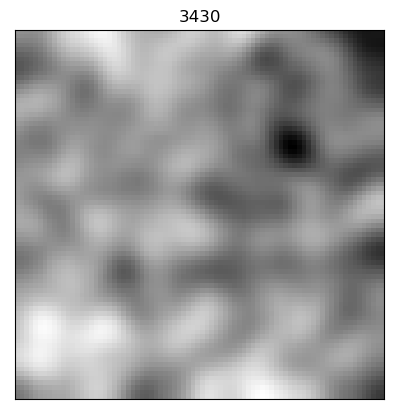

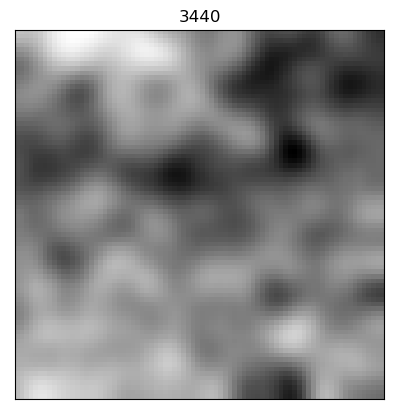

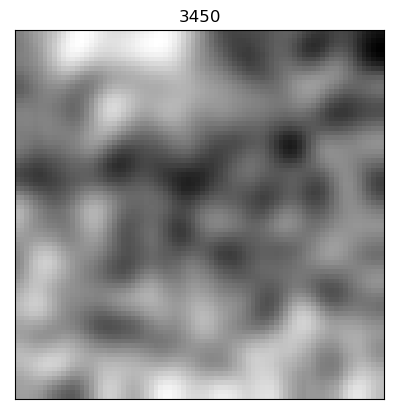

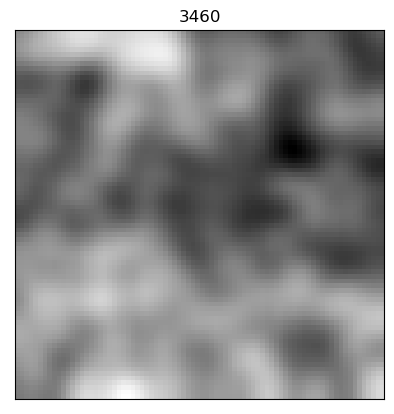

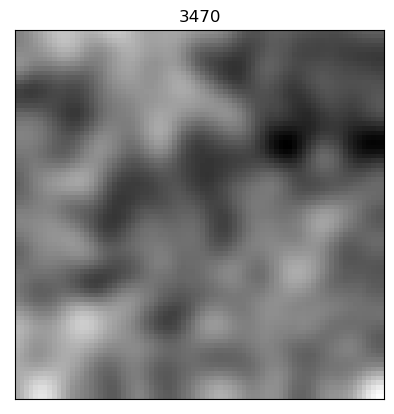

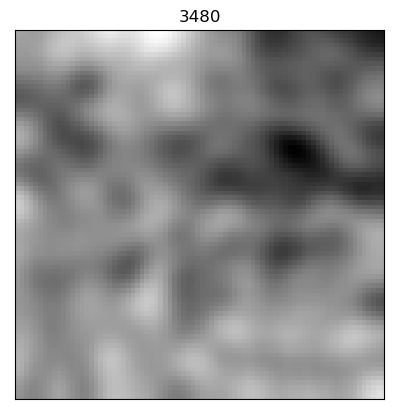

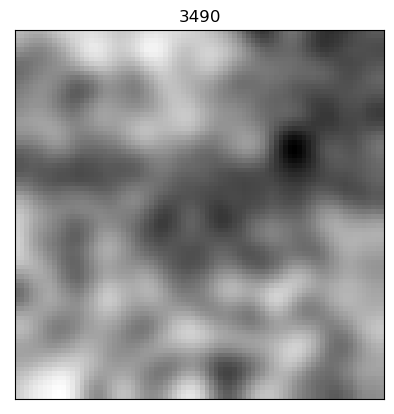

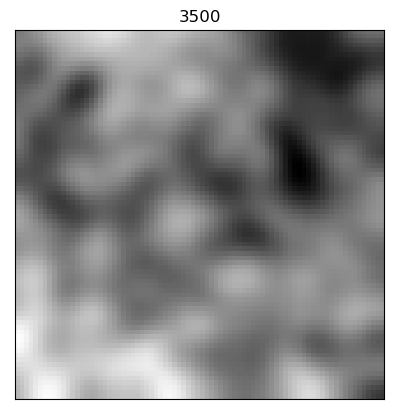

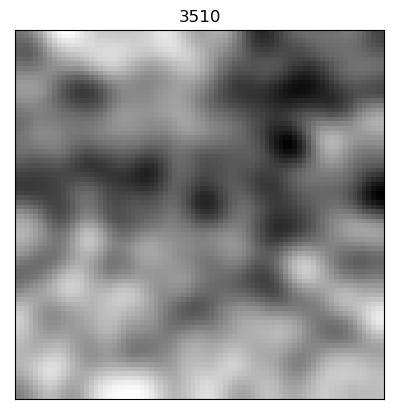

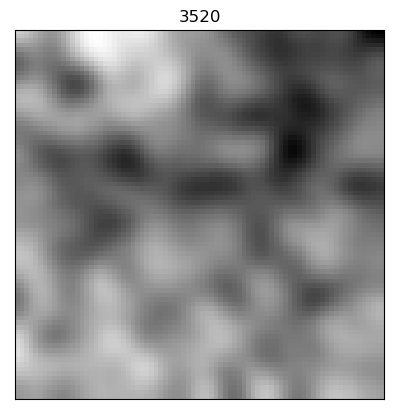

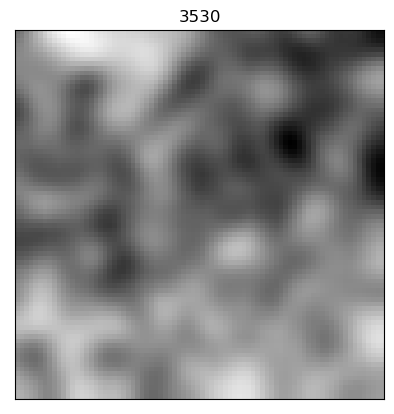

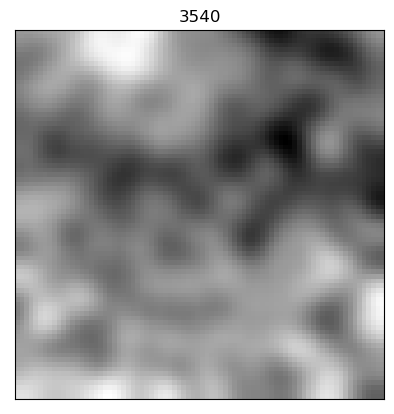

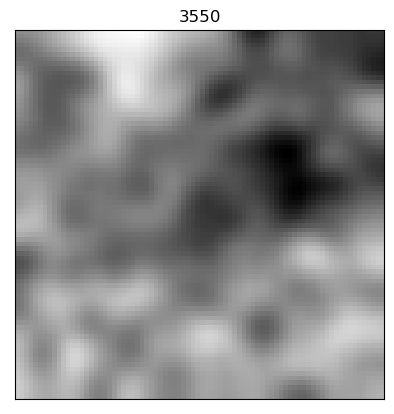

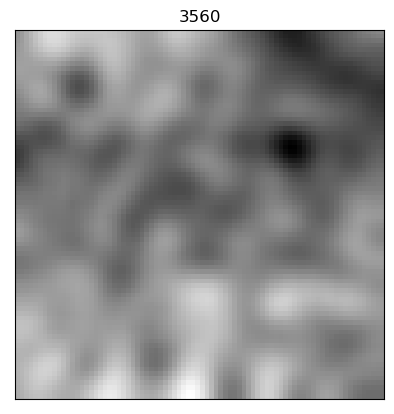

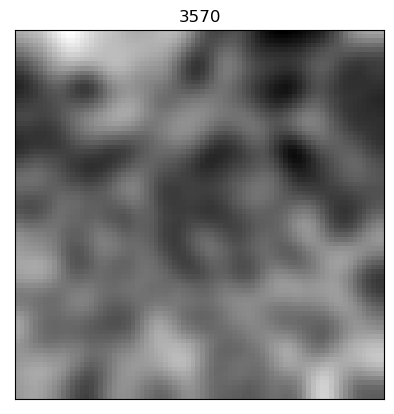

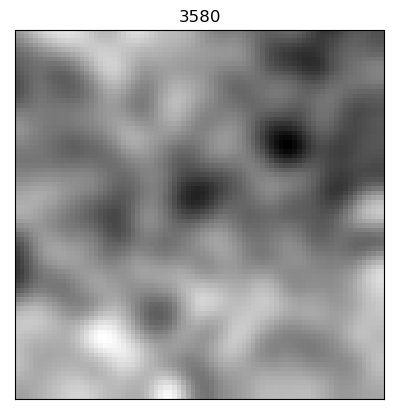

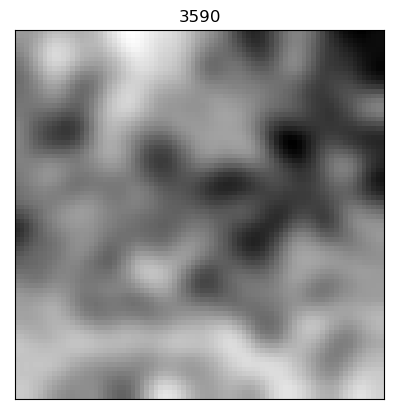

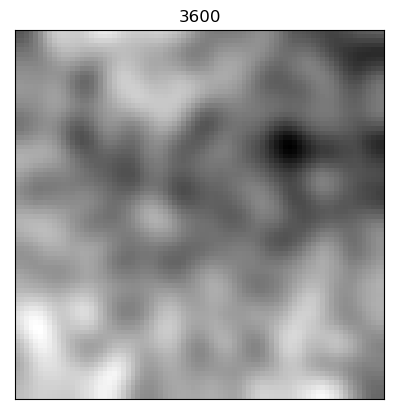

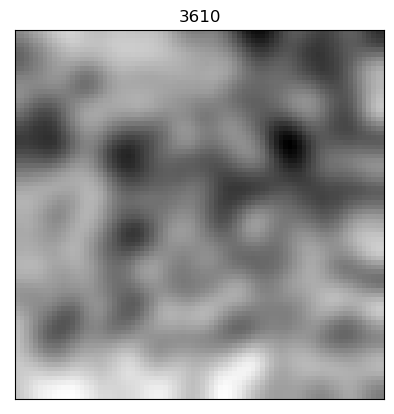

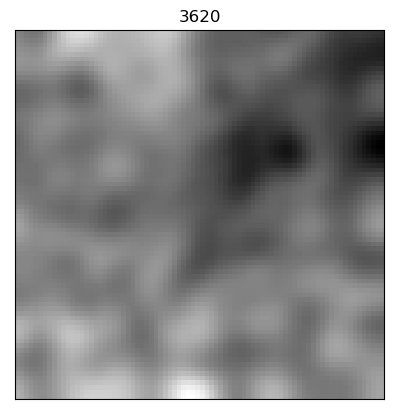

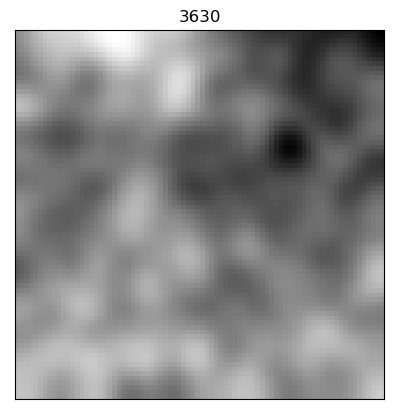

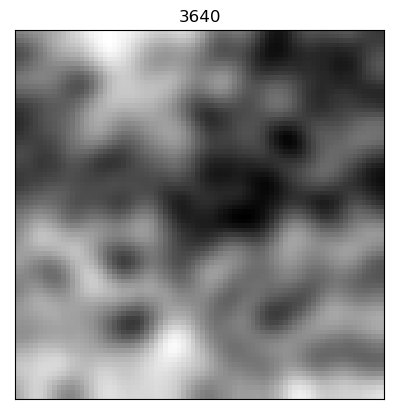

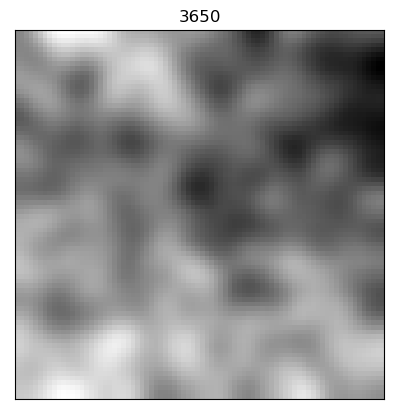

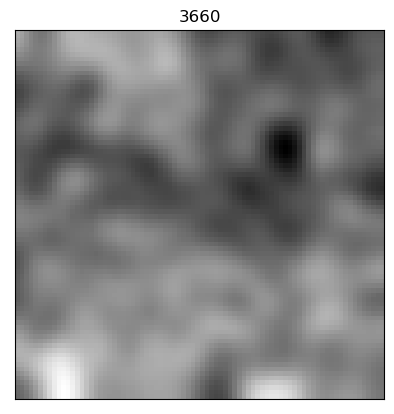

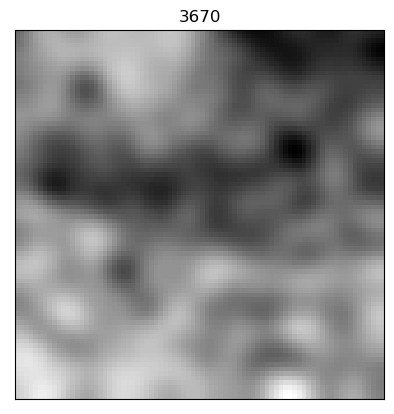

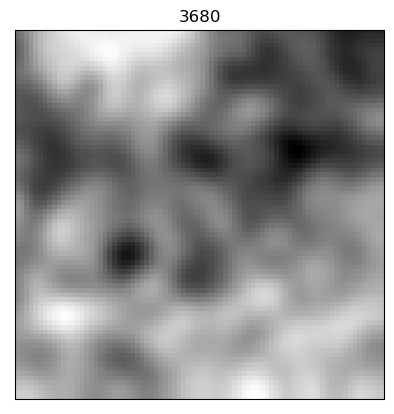

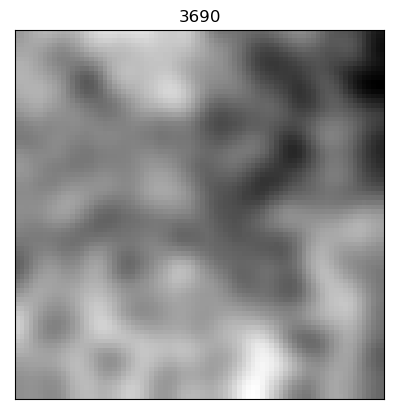

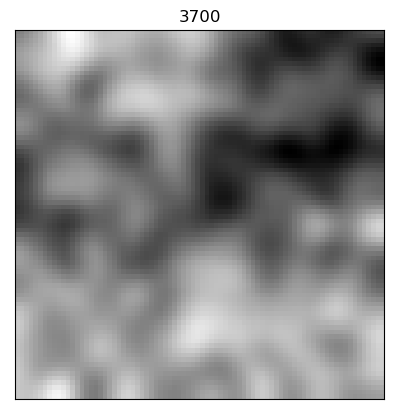

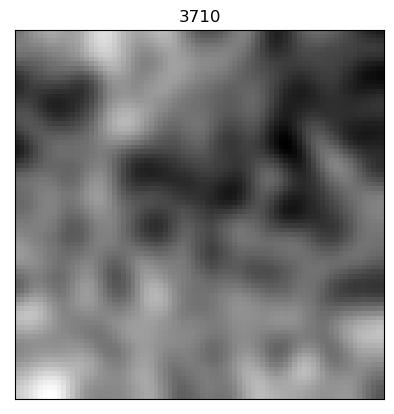

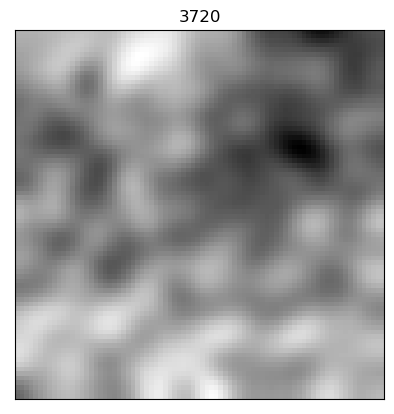

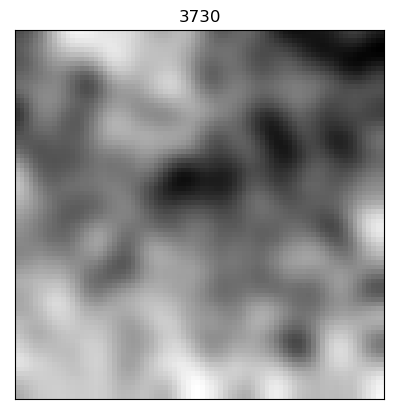

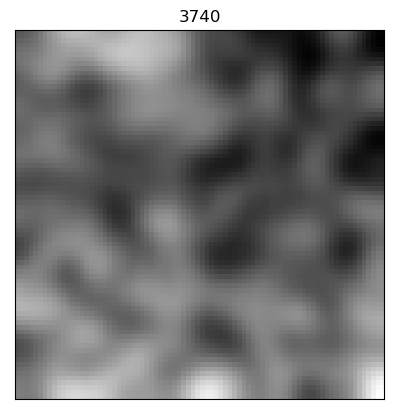

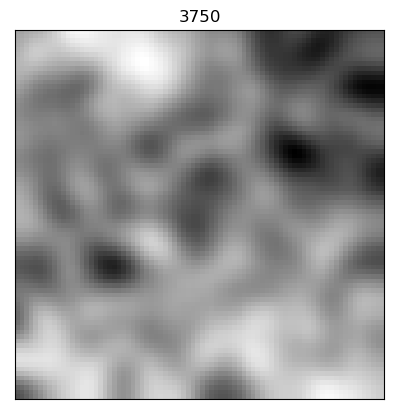

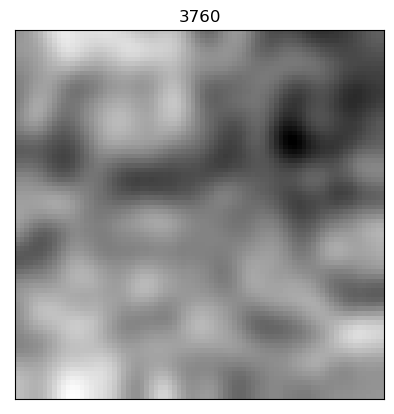

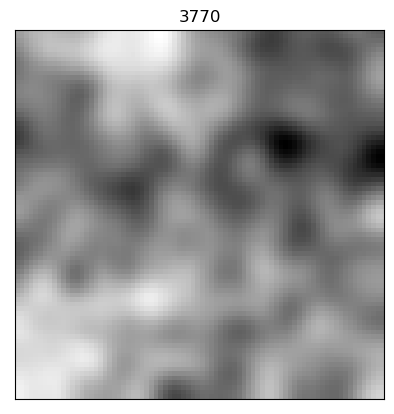

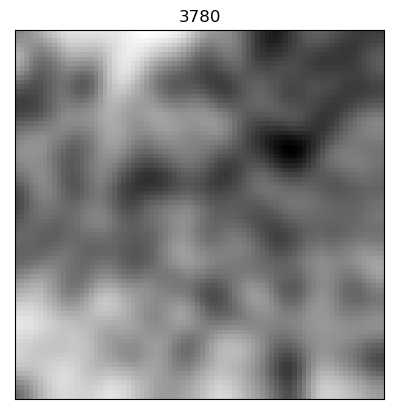

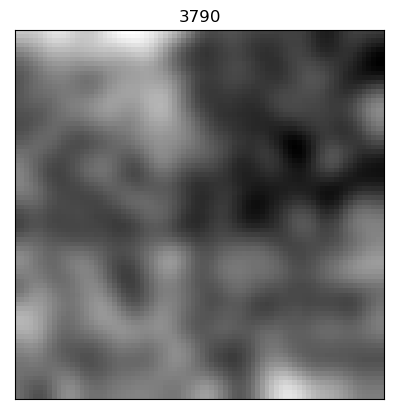

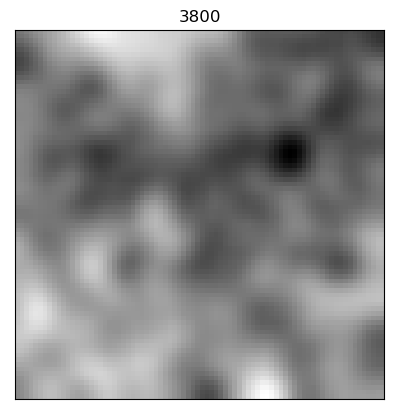

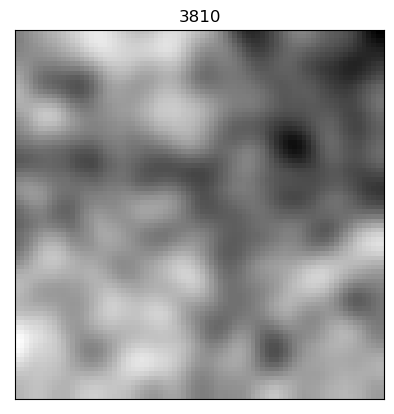

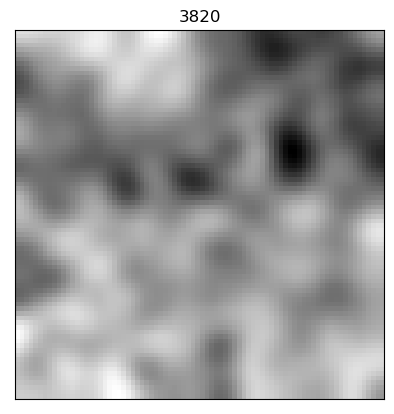

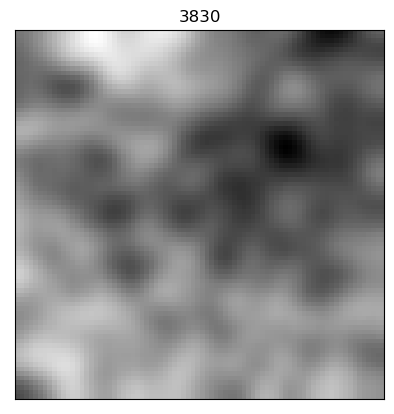

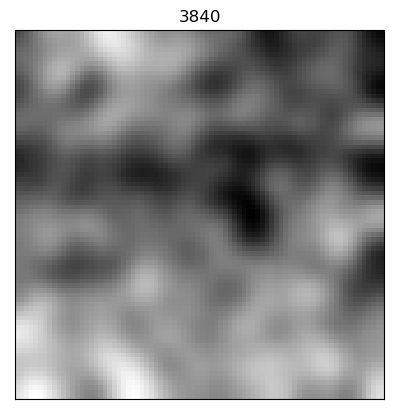

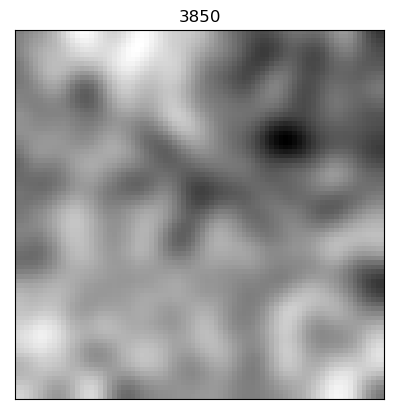

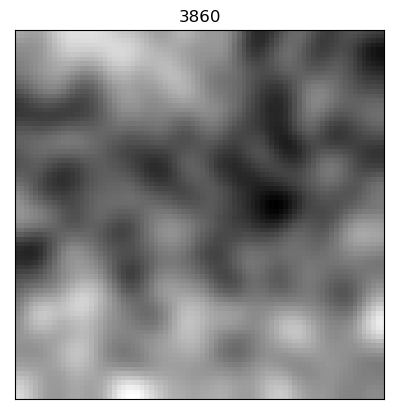

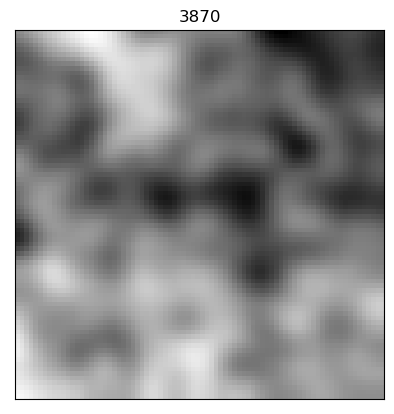

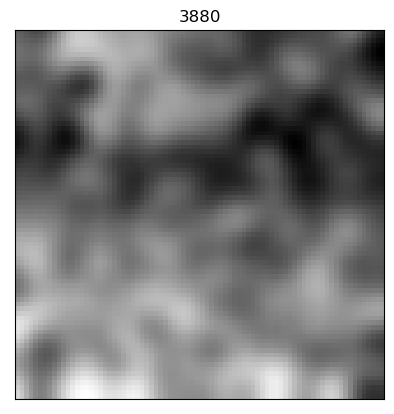

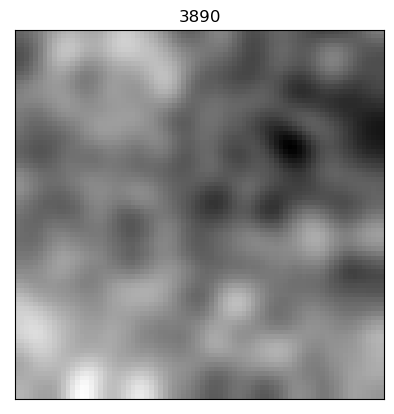

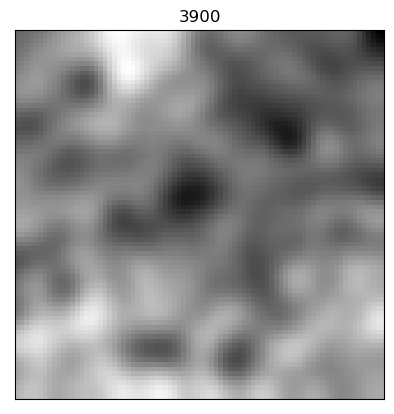

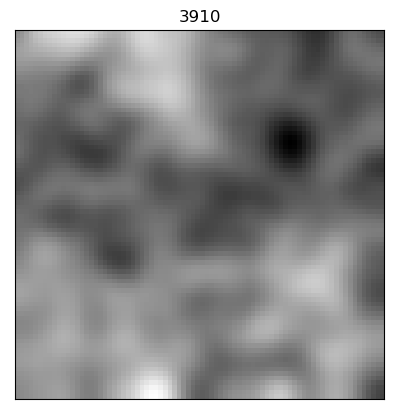

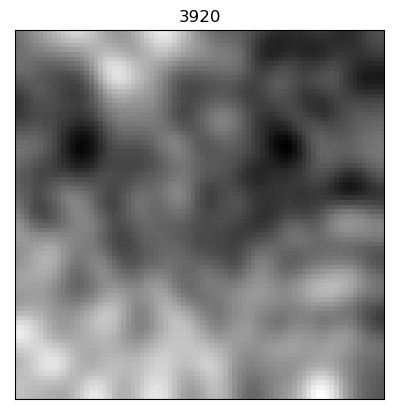

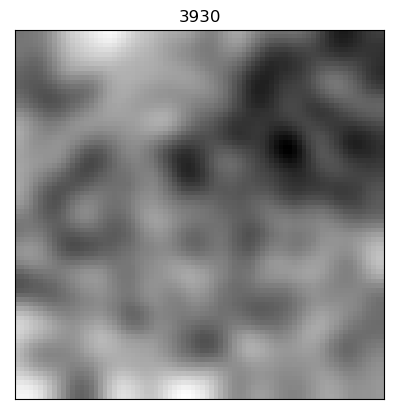

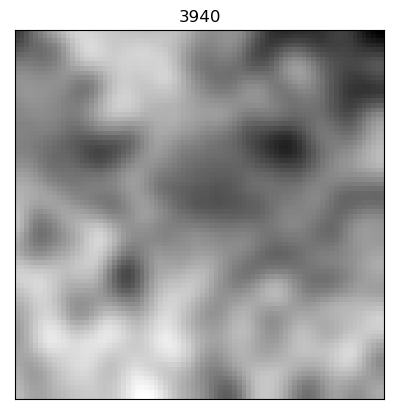

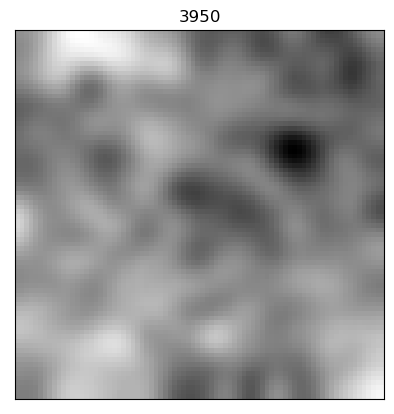

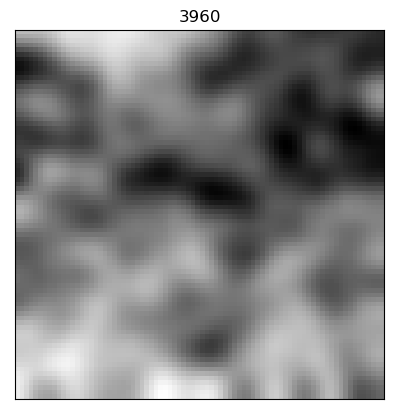

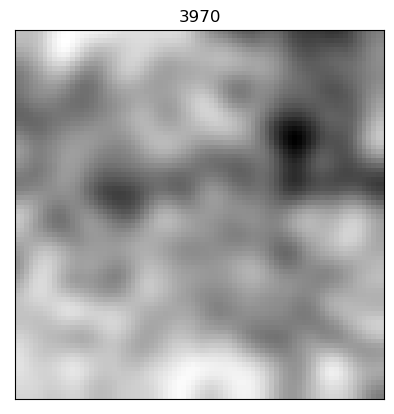

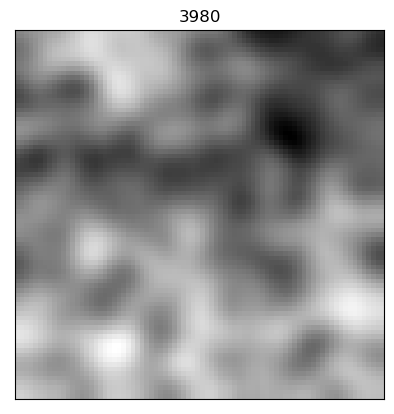

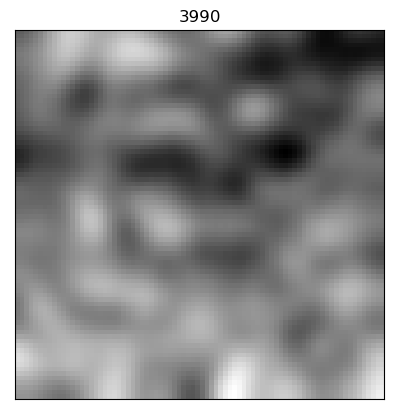

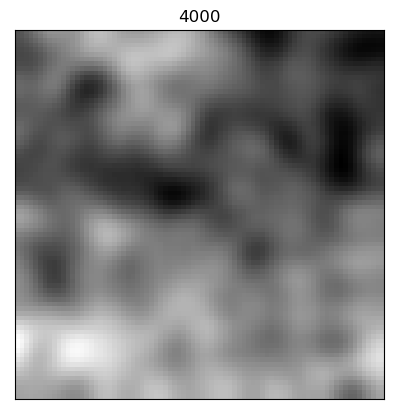

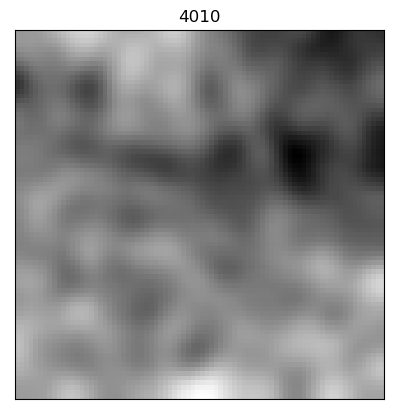

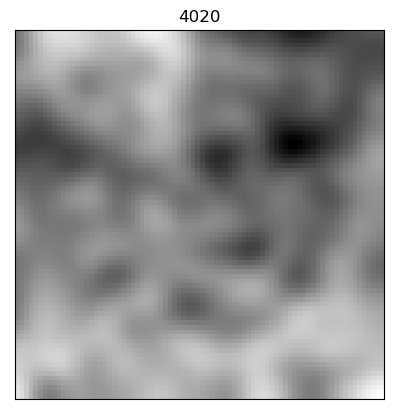

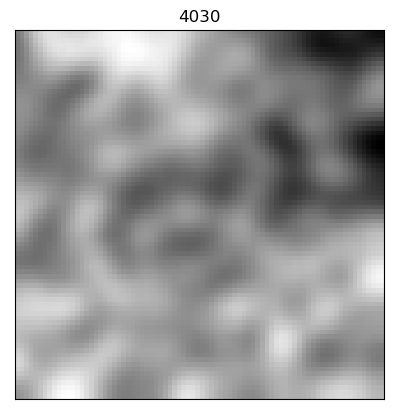

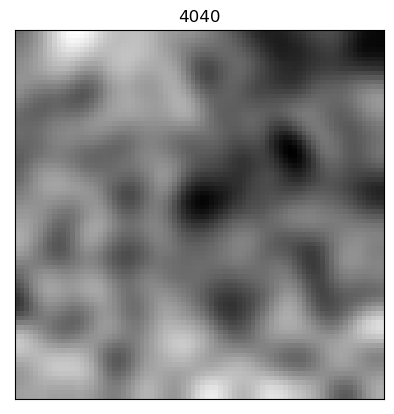

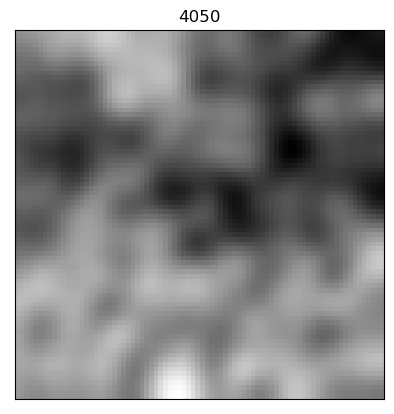

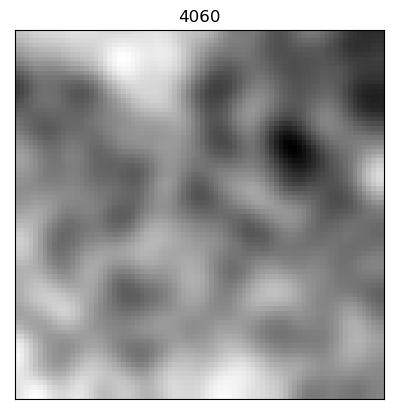

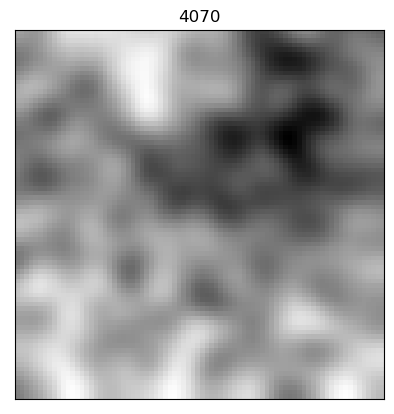

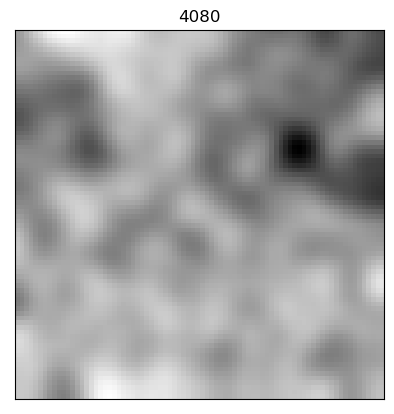

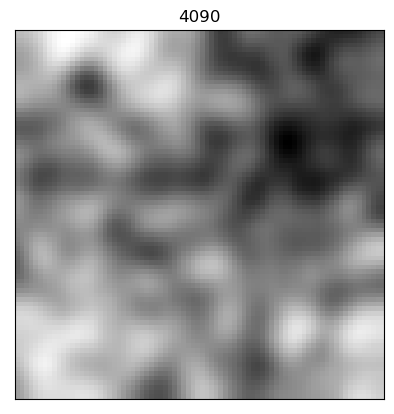

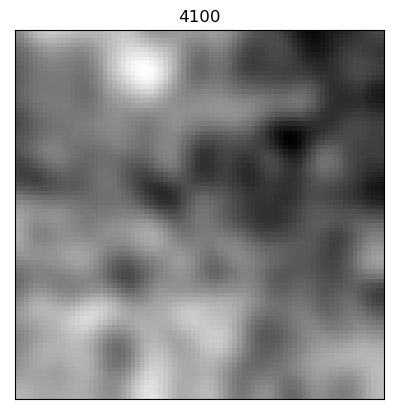

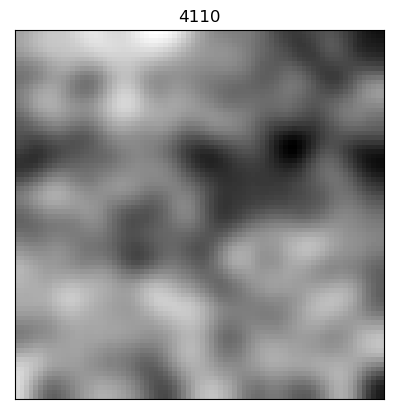

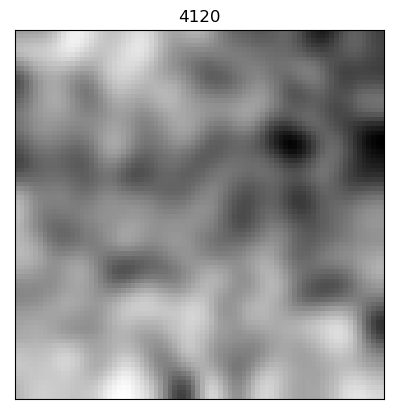

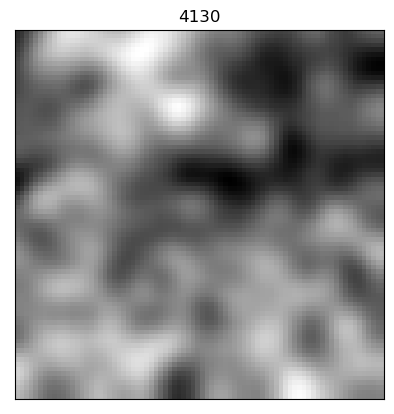

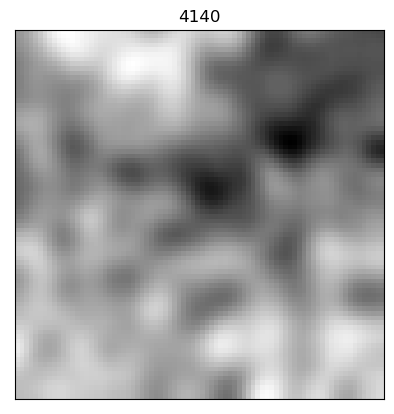

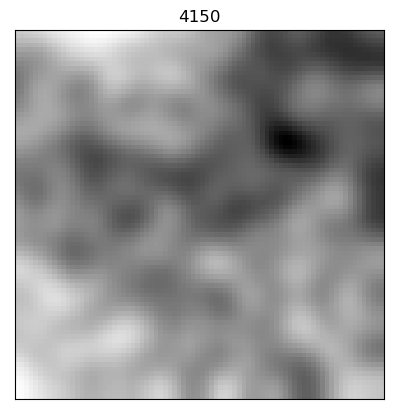

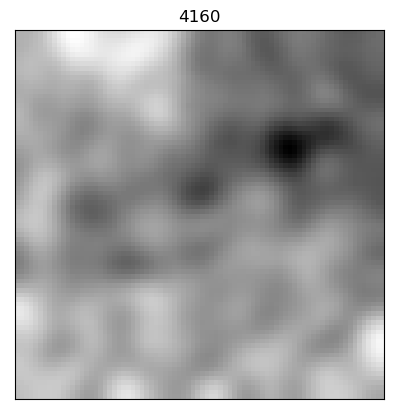

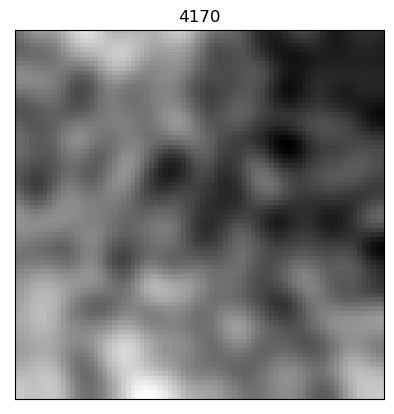

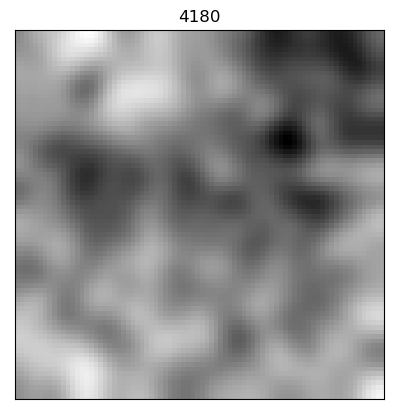

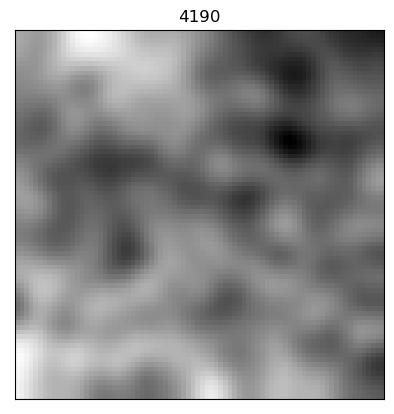

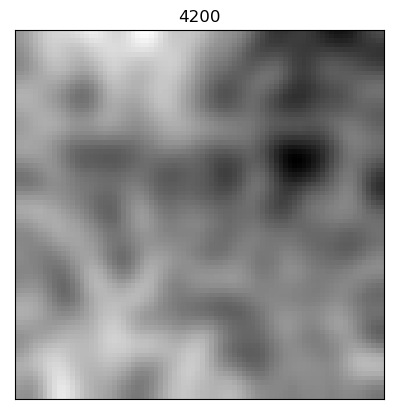

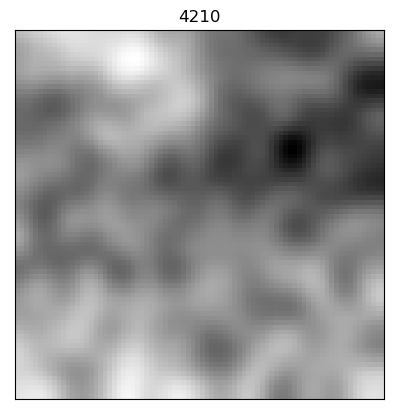

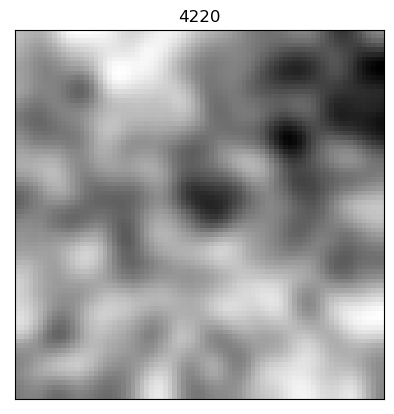

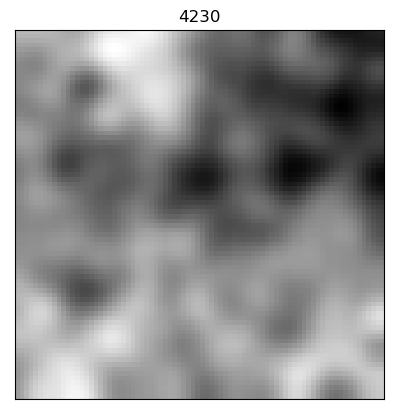

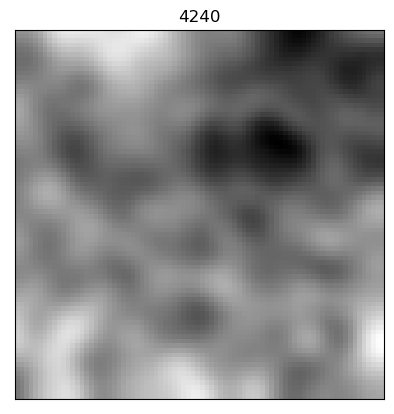

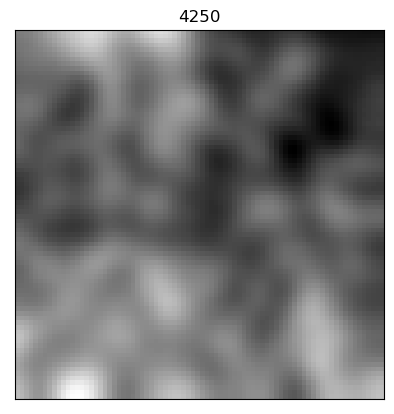

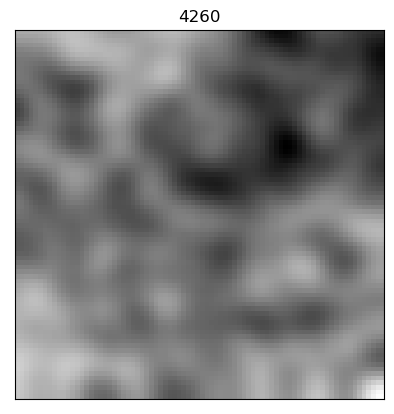

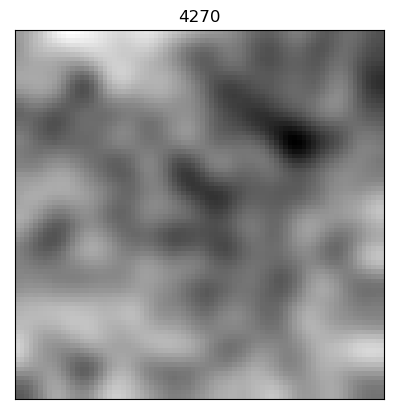

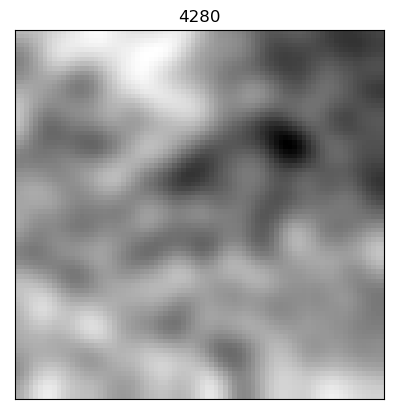

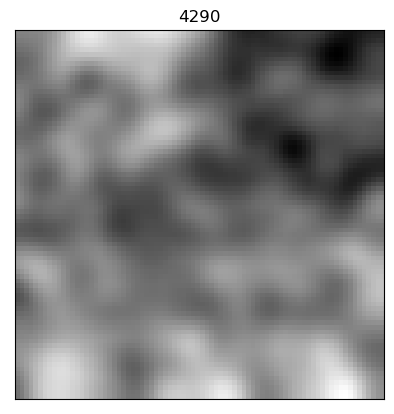

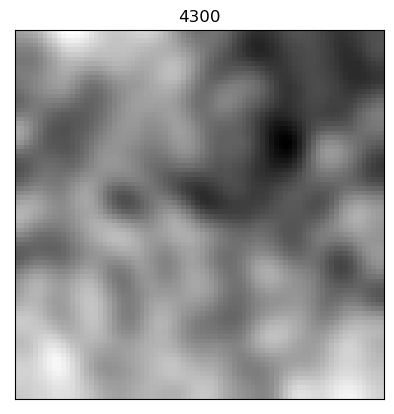

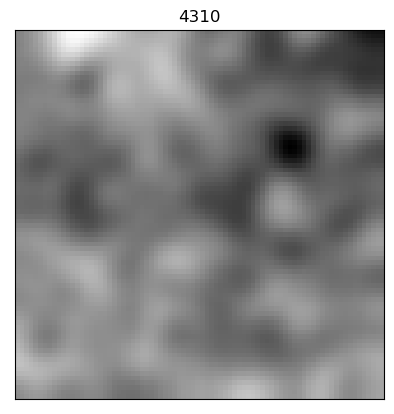

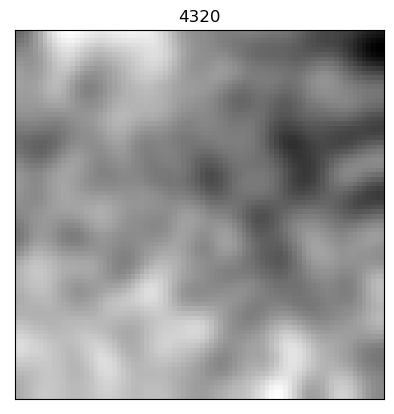

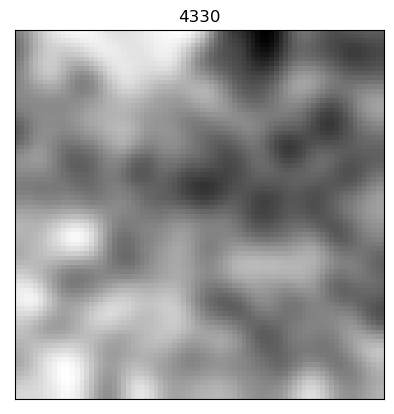

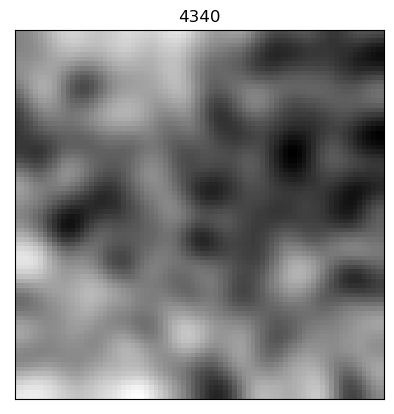

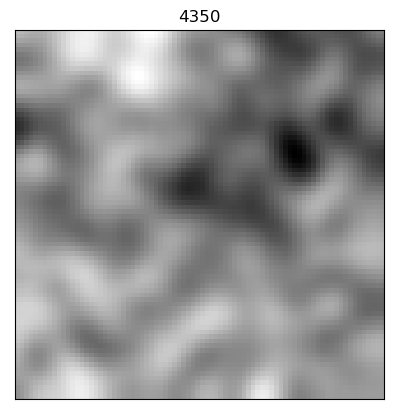

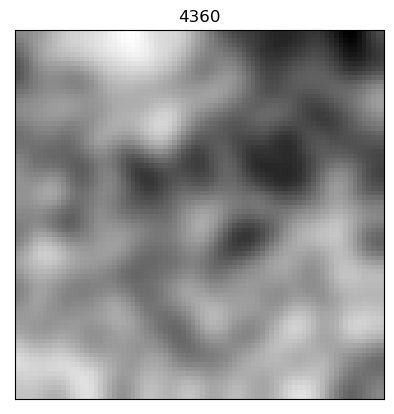

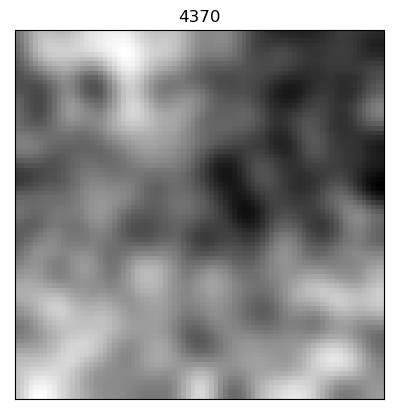

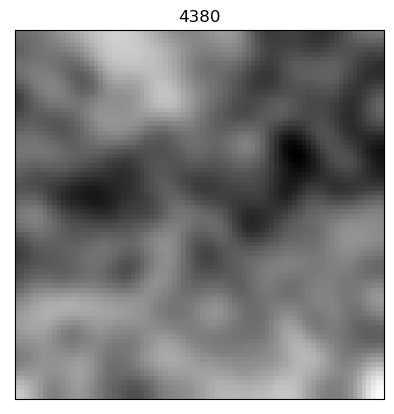

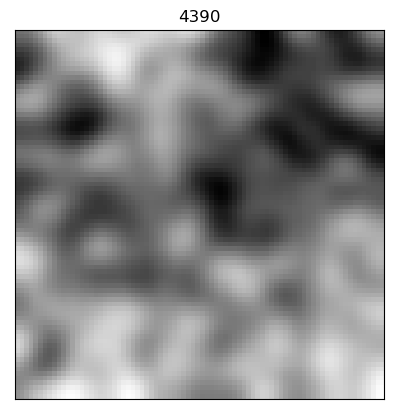

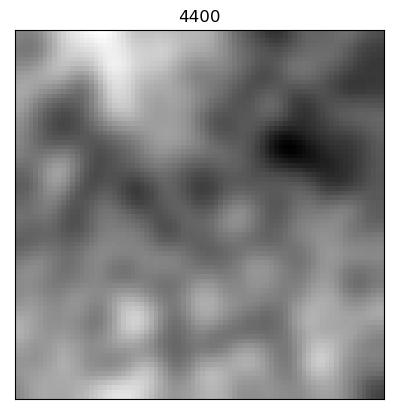

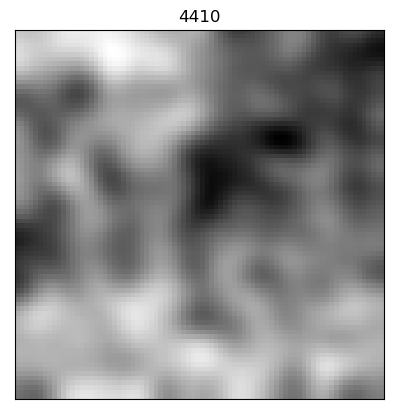

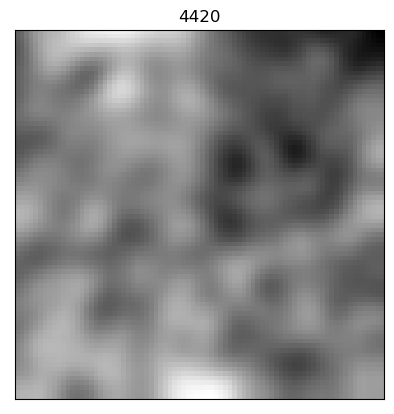

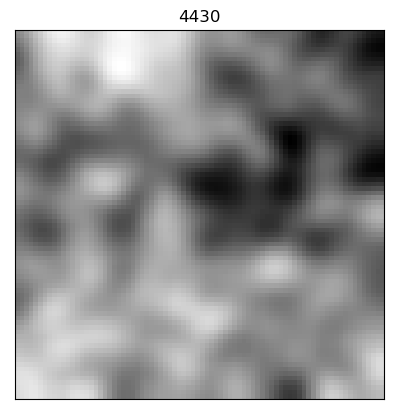

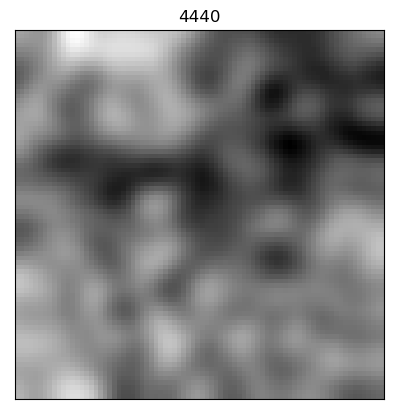

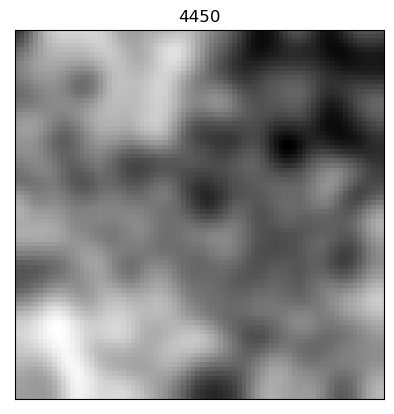

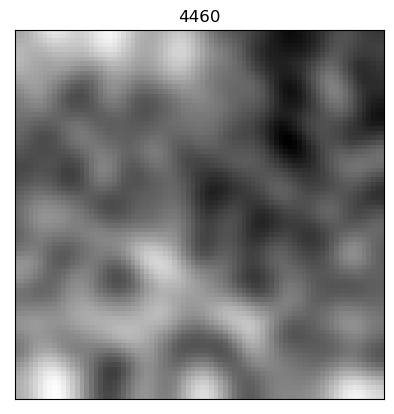

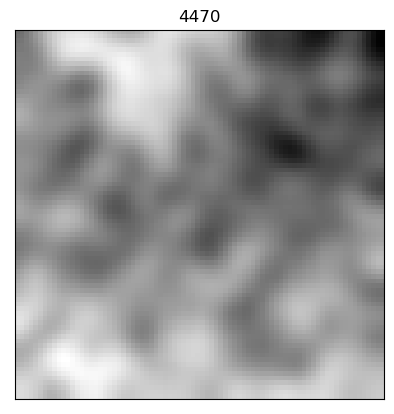

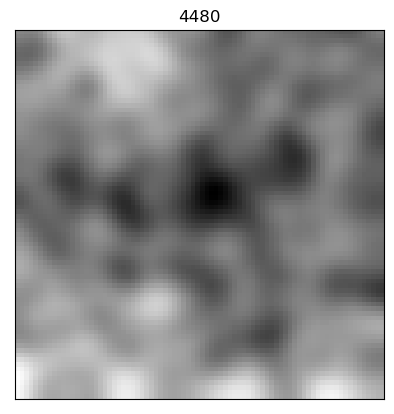

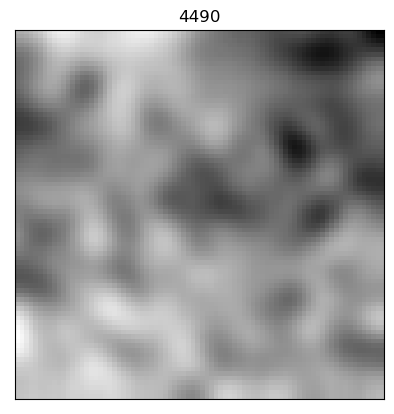

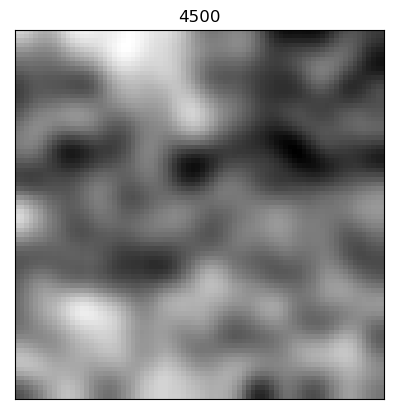

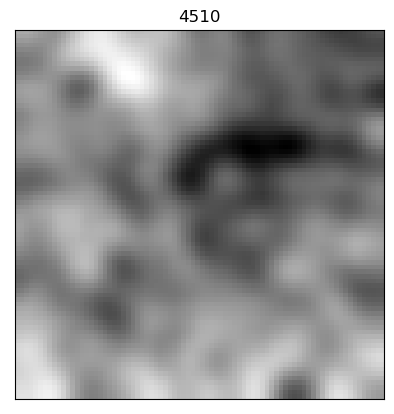

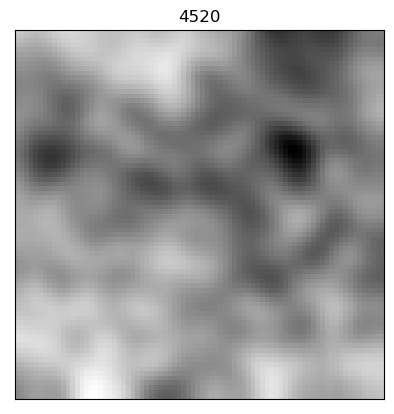

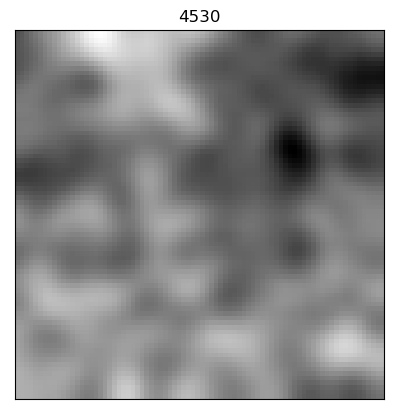

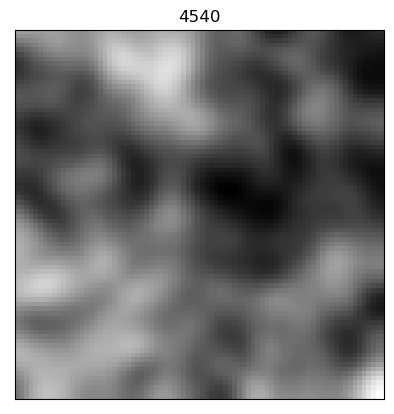

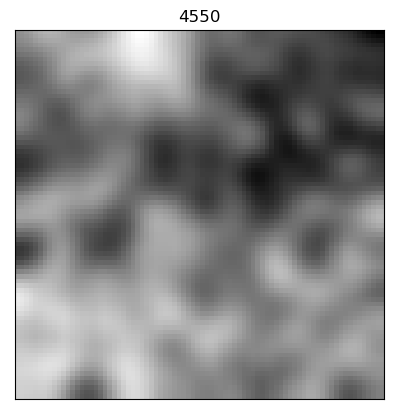

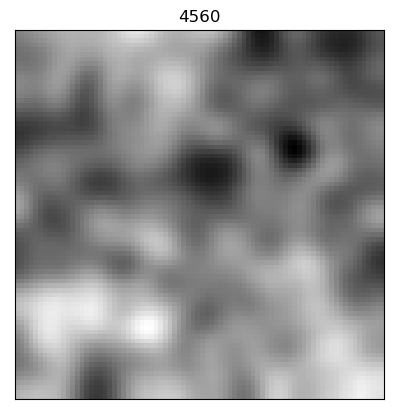

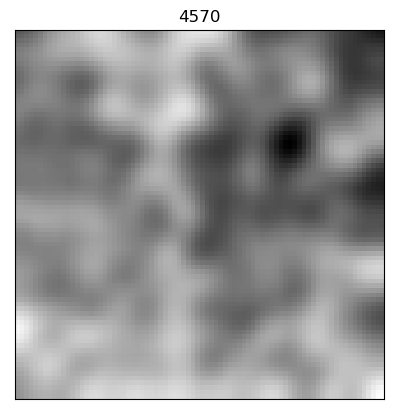

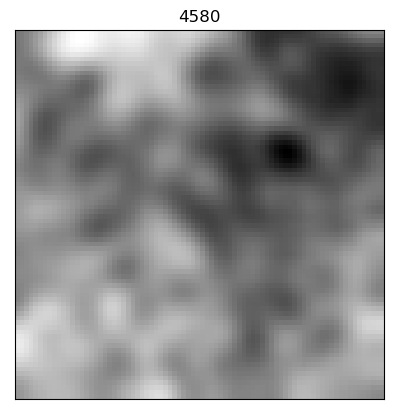

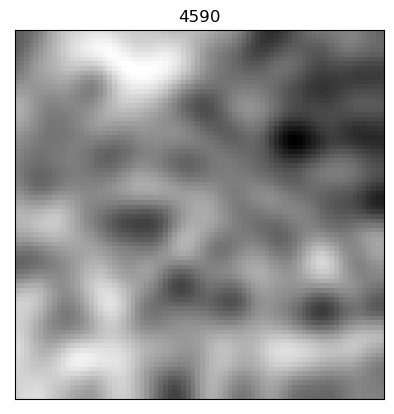

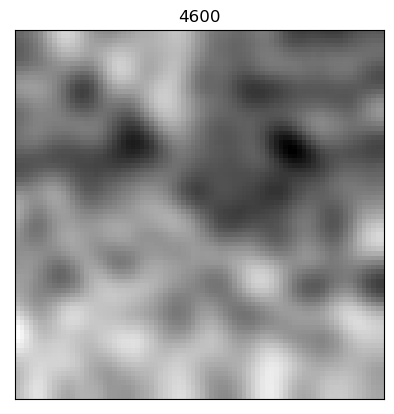

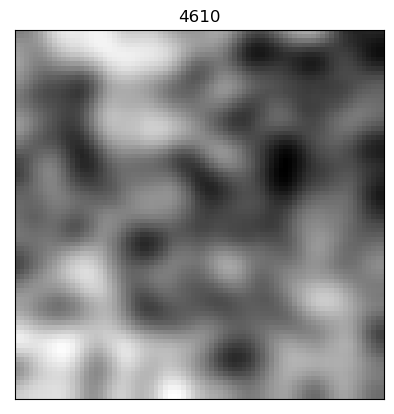

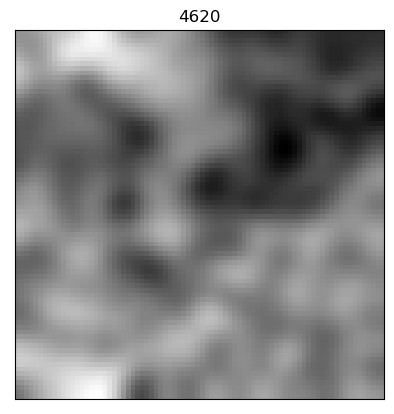

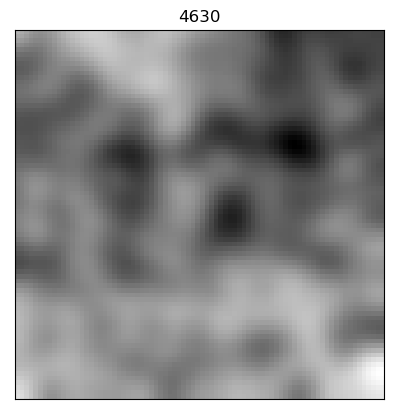

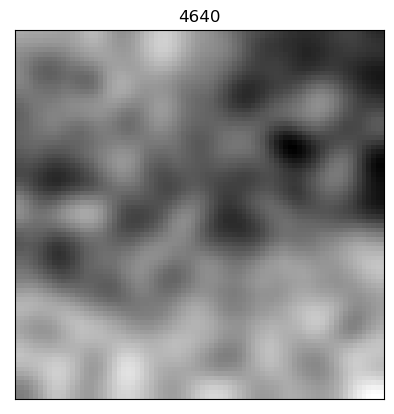

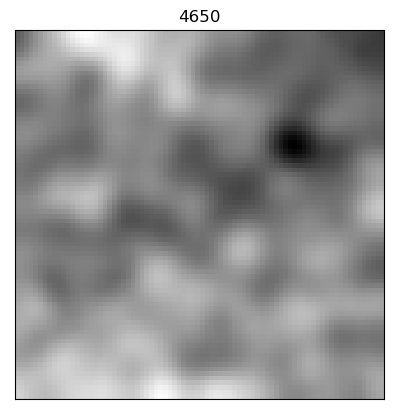

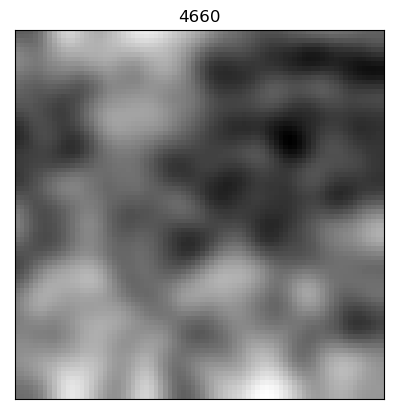

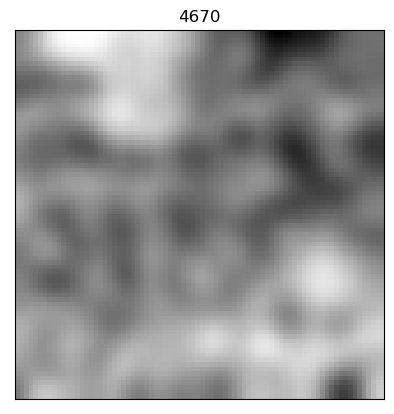

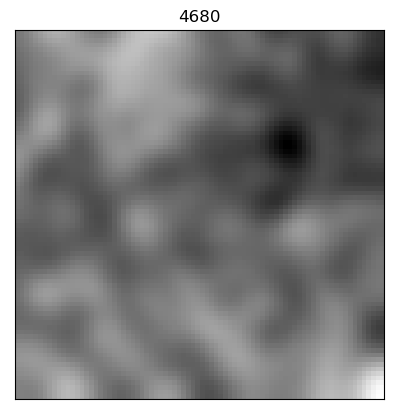

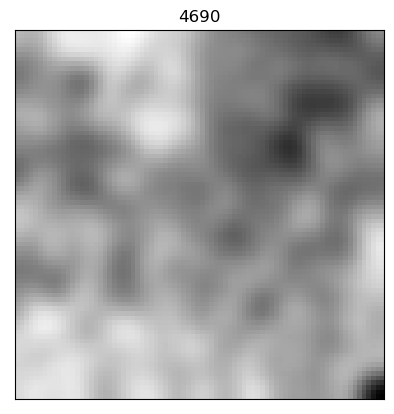

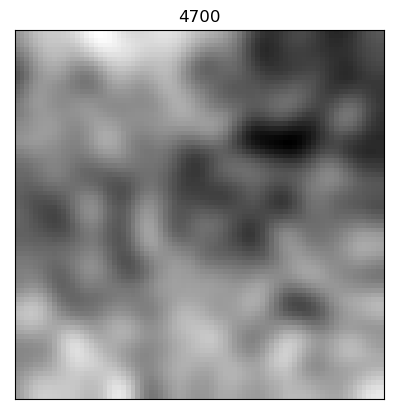

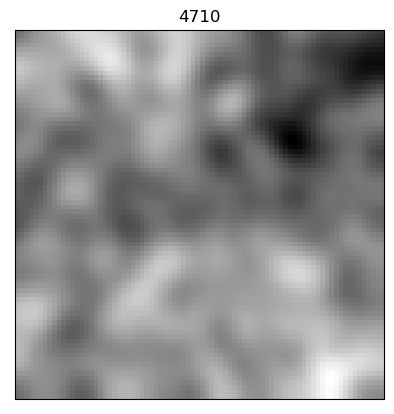

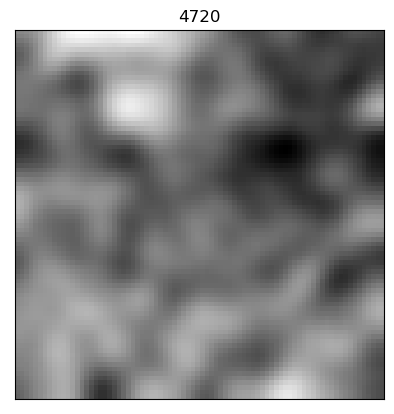

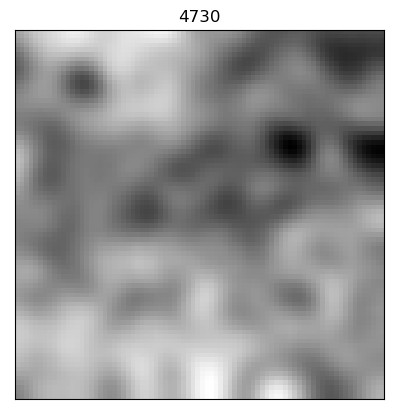

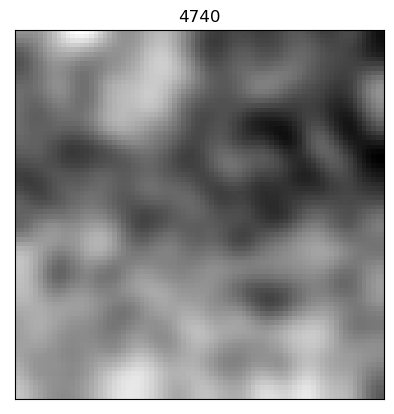

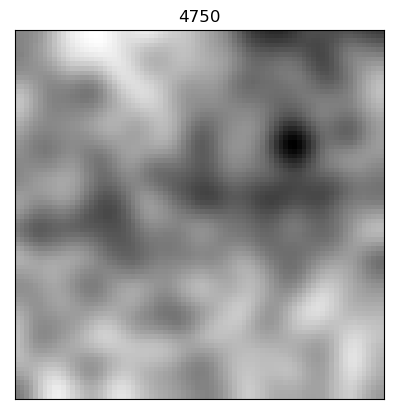

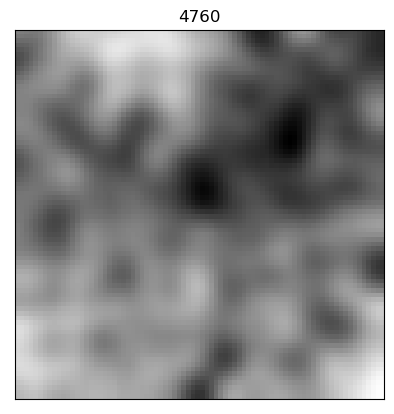

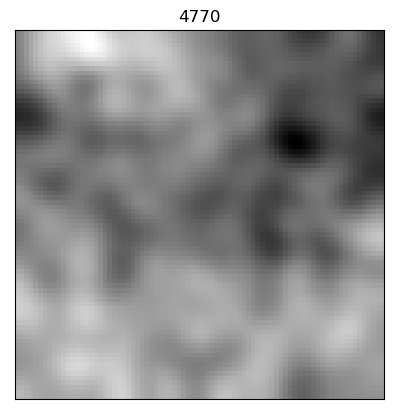

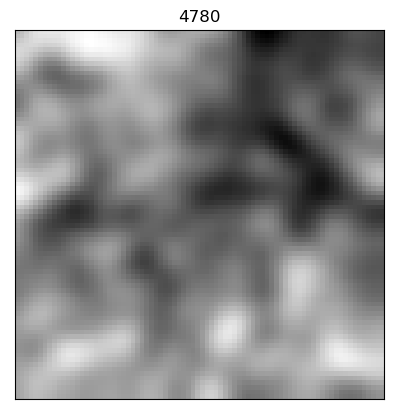

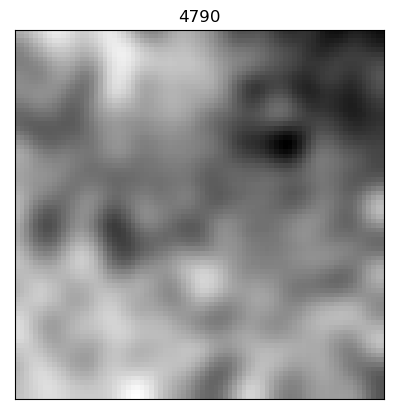

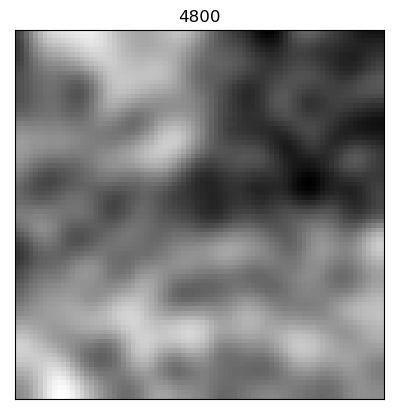

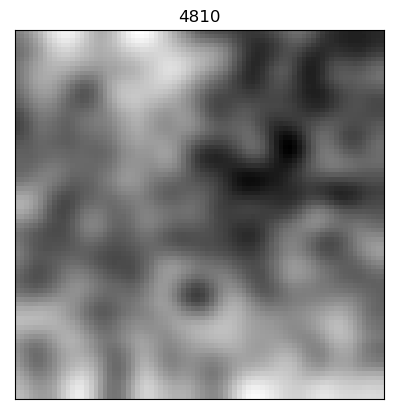

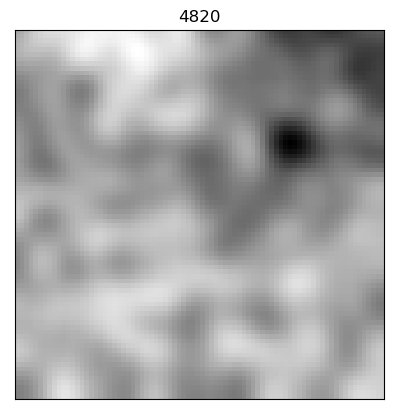

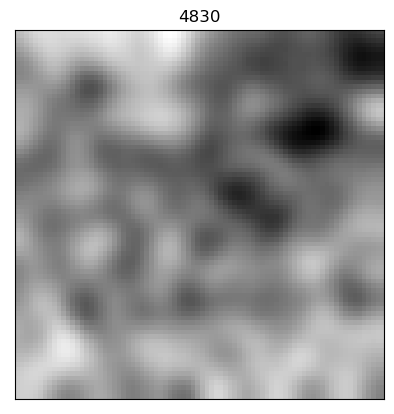

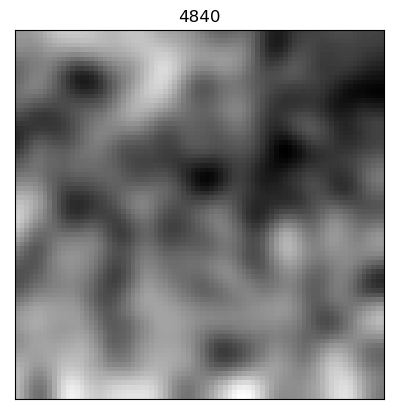

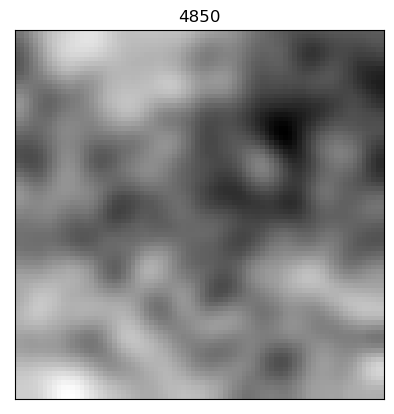

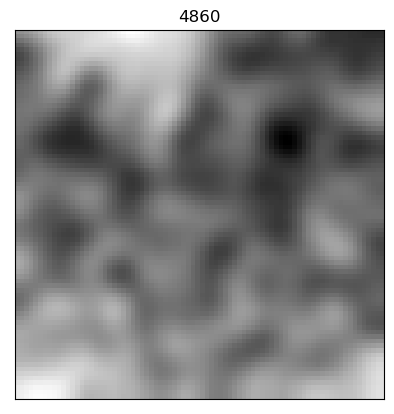

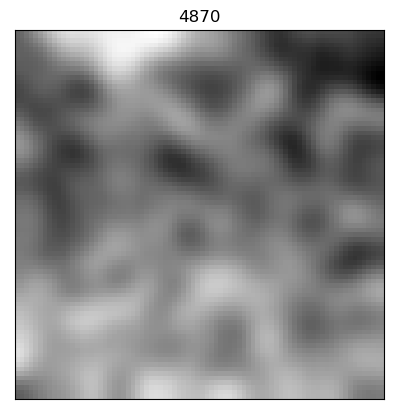

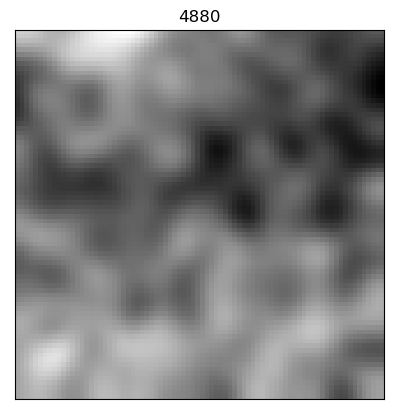

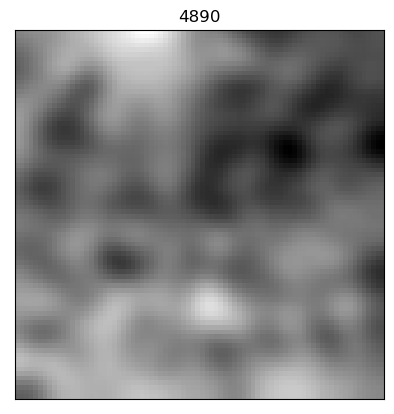

In [51]:
for frame_num in range(0, space_data2.shape[0], 10):
    plt.imshow(space_data2[frame_num, :, :], cmap='gray') # matplotlib.colors.ListedColormap(colors))
    plt.xticks([])
    plt.yticks([])
    plt.title(f'{frame_num+100}')
    plt.savefig(os.path.join(fig_dir, f'Frames_{data_type}\\{frame_num+100}.png'))
    plt.show()

- Generate a discrete colored mask

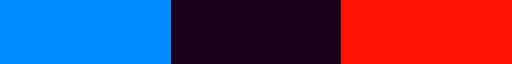

In [87]:
if data_file == 'Fig3_ver01_221025_data119.cathodic.dF.dFF':
    colors = ['#008cfd', '#1a0119', '#1a0119', '#1a0119', '#1a0119', '#ff1203']
else:
    colors = ['#008cfd', '#1a0119', '#ff1203']

matplotlib.colors.ListedColormap(colors)

In [88]:
mask = np.zeros(space_data3.shape)

for x_coord in tqdm(range(space_data3.shape[1])):
    for y_coord in range(space_data3.shape[-1]):
        max = space_data3[:, x_coord, y_coord].max()
        min = space_data3[:, x_coord, y_coord].min()
        one_interval = (max - min) / len(colors)

        for frame_num in range(800, space_data3.shape[0], 2):

            signal_pnt = space_data3[frame_num, x_coord, y_coord]
            if signal_pnt == max:
                bin_pnt = len(colors)-1
            else:
                bin_pnt = (signal_pnt - min) // one_interval

            # Detect depolarization
            if (bin_pnt == 0) and (signal_pnt < low_thres):
                mask[frame_num, x_coord, y_coord] = 0
            # Detect hyperpolarization
            elif (bin_pnt == len(colors)-1) and (signal_pnt > high_thres):
                mask[frame_num, x_coord, y_coord] = 2
            else:
                mask[frame_num, x_coord, y_coord] = 1

unique, counts = np.unique(mask, return_counts=True)
print("Colors: ", unique, "Counts: ", counts)

100%|██████████| 80/80 [00:20<00:00,  3.87it/s]


Colors:  [0. 1. 2.] Counts:  [18132838 12196765   390397]


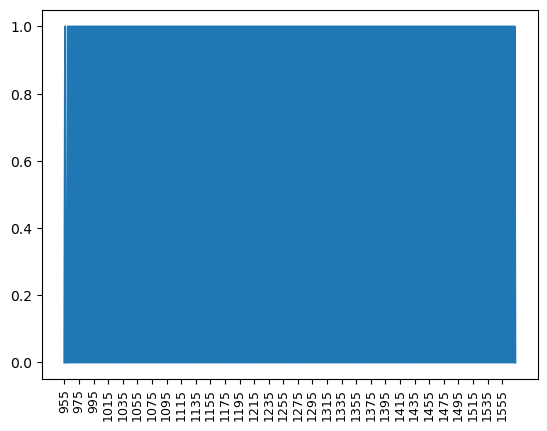

In [89]:
plt.plot(range(955, 1574), mask[955:1574, 65, 46])
plt.xticks(range(955, 1574, 20), fontsize=9, rotation=90)
plt.show()

- Color the processed frames using the mask

In [90]:
for frame_num in tqdm(range(800, space_data3.shape[0], 2)):
    data = mask[frame_num, :, :]
    if np.array_equal(np.unique(mask[frame_num, :, :], return_counts=True)[0], np.array([0., 1., 2.])):
        colors = ['#008cfd', '#1a0119', '#ff1203']
    elif np.array_equal(np.unique(mask[frame_num, :, :], return_counts=True)[0], np.array([0., 1.])):
        colors = ['#008cfd', '#1a0119']
    elif np.array_equal(np.unique(mask[frame_num, :, :], return_counts=True)[0], np.array([0., 2.])):
        colors = ['#008cfd', '#ff1203']
    elif np.array_equal(np.unique(mask[frame_num, :, :], return_counts=True)[0], np.array([1., 2.])):
        colors = ['#1a0119', '#ff1203']
    elif np.array_equal(np.unique(mask[frame_num, :, :], return_counts=True)[0], np.array([0.])):
        colors = ['#008cfd']
    elif np.array_equal(np.unique(mask[frame_num, :, :], return_counts=True)[0], np.array([1.])):
        colors = ['#1a0119']
    elif np.array_equal(np.unique(mask[frame_num, :, :], return_counts=True)[0], np.array([2.])):
        colors = ['#ff1203']

    fig, ax = plt.subplots(1)
    ax.imshow(img_data[:, :], cmap='gray')
    ax.imshow(data, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.4)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title(f'Frame {frame_num+100}')
    plt.savefig(f'c:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\figures\\Fig3\\Results_{data_type}\\{frame_num+100}.png')

  1%|          | 20/2000 [00:02<03:08, 10.49it/s]C:\Users\Na Min An\AppData\Local\Temp\ipykernel_3184\3215066820.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)
 29%|██▉       | 588/2000 [00:47<01:36, 14.70it/s]